# visualize global performance 

In [6]:
import torch
import matplotlib.pyplot as plt
import collections


# Load PyTorch checkpoint file

def visualize_global(data, n_adv= 0, n_s = 10):
    # Track seller selection counts
    seller_selection_counts = collections.Counter()

    # Track final performance changes
    round_numbers = []
    final_loss = []
    final_acc = []

    # Process each round
    for round_data in data:
        round_numbers.append(round_data["round_number"])
        final_loss.append(round_data["final_perf_local"]["loss"])
        final_acc.append(round_data["final_perf_local"]["acc"])

        # Count selections per seller
        for seller in round_data["used_sellers"]:
            seller_selection_counts[seller] += 1

    # Create an ordered dictionary for seller names to maintain the sequence
    seller_names = collections.OrderedDict()
    for i in range(n_adv):
        seller_names[i] = f"adv_{i}"
    for i in range(n_adv, n_s):
        seller_names[i] = f"seller_{i}"

    # Ensure that all sellers (even those with 0 selections) are included in the order
    sorted_seller_counts = collections.OrderedDict()
    for seller_id in seller_names.keys():
        sorted_seller_counts[seller_id] = seller_selection_counts.get(seller_id, 0)

    # Map seller IDs to their corresponding names in the correct order
    mapped_sellers = list(seller_names.values())
    selection_counts = list(sorted_seller_counts.values())

    # Plot seller selection counts
    plt.figure(figsize=(10, 5))
    plt.bar(mapped_sellers, selection_counts, color="skyblue")

    plt.xlabel("Seller Name")
    plt.ylabel("Number of Selections")
    plt.title("Number of Selections per Seller")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")  

    plt.show()

    # Plot final loss and accuracy changes over rounds
    plt.figure(figsize=(10, 5))
    plt.plot(round_numbers, final_loss, label="Loss", marker="o")
    plt.plot(round_numbers, final_acc, label="Accuracy", marker="s")
    plt.xlabel("Round Number")
    plt.ylabel("Value")
    plt.title("Change in Final Performance (Local) Over Rounds")
    plt.legend()
    plt.grid()
    plt.show()


Client splits:
  Client buyer: 5000 samples
  Client seller_0: 55000 samples


In [9]:
strength = 1.0
# bm = "single"
bm = "cmd"
# bm = "None"
n_adv = 1
file_name = f"./result/backdoor_mode_{bm}_strength_{strength}/n_seller_10_n_adv_{n_adv}_local_epoch_2_local_lr_0.01/market_log.ckpt"

data = torch.load(file_name, weights_only=False )  # Change filename as needed

visualize_global(data, n_adv=n_adv)

In [14]:
import matplotlib.pyplot as plt
import collections
import numpy as np

def visualize_comparative(data_by_adv):
    """
    Visualize and compare the experimental results for different numbers of adversaries.

    Parameters:
      data_by_adv (dict): Dictionary mapping adversary count (int) to a list of round_data.
                          Each round_data should be a dict with:
                              "round_number": int,
                              "final_perf_local": dict with keys "loss" and "acc",
                              "used_sellers": list of seller IDs.
    """
    # Define colors for each curve using a colormap.
    adv_counts = sorted(data_by_adv.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(adv_counts)))
    
    # Create subplots for loss and accuracy over rounds.
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(14, 6))
    
    for i, adv in enumerate(adv_counts):
        round_numbers = []
        final_loss = []
        final_acc = []
        for rd in data_by_adv[adv]:
            round_numbers.append(rd["round_number"])
            final_loss.append(rd["final_perf_local"]["loss"])
            final_acc.append(rd["final_perf_local"]["acc"])
        
        ax_loss.plot(round_numbers, final_loss, label=f"Adv: {adv}", marker="o", color=colors[i])
        ax_acc.plot(round_numbers, final_acc, label=f"Adv: {adv}", marker="s", color=colors[i])
    
    ax_loss.set_xlabel("Round Number")
    ax_loss.set_ylabel("Loss")
    ax_loss.set_title("Loss over Rounds")
    ax_loss.legend(title="Number of Adversaries")
    ax_loss.grid(True)
    
    ax_acc.set_xlabel("Round Number")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_title("Accuracy over Rounds")
    ax_acc.legend(title="Number of Adversaries")
    ax_acc.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Additionally, visualize seller selection counts across experiments.
    plt.figure(figsize=(12, 6))
    for adv in adv_counts:
        seller_selection_counts = collections.Counter()
        for rd in data_by_adv[adv]:
            for seller in rd["used_sellers"]:
                seller_selection_counts[seller] += 1
        # Plot counts for this adversary count.
        sellers = list(seller_selection_counts.keys())
        counts = list(seller_selection_counts.values())
        plt.plot(sellers, counts, marker="o", label=f"Adv: {adv}")
    
    plt.xlabel("Seller ID")
    plt.ylabel("Number of Selections")
    plt.title("Seller Selection Counts across Different Adversary Numbers")
    plt.legend(title="Number of Adversaries")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



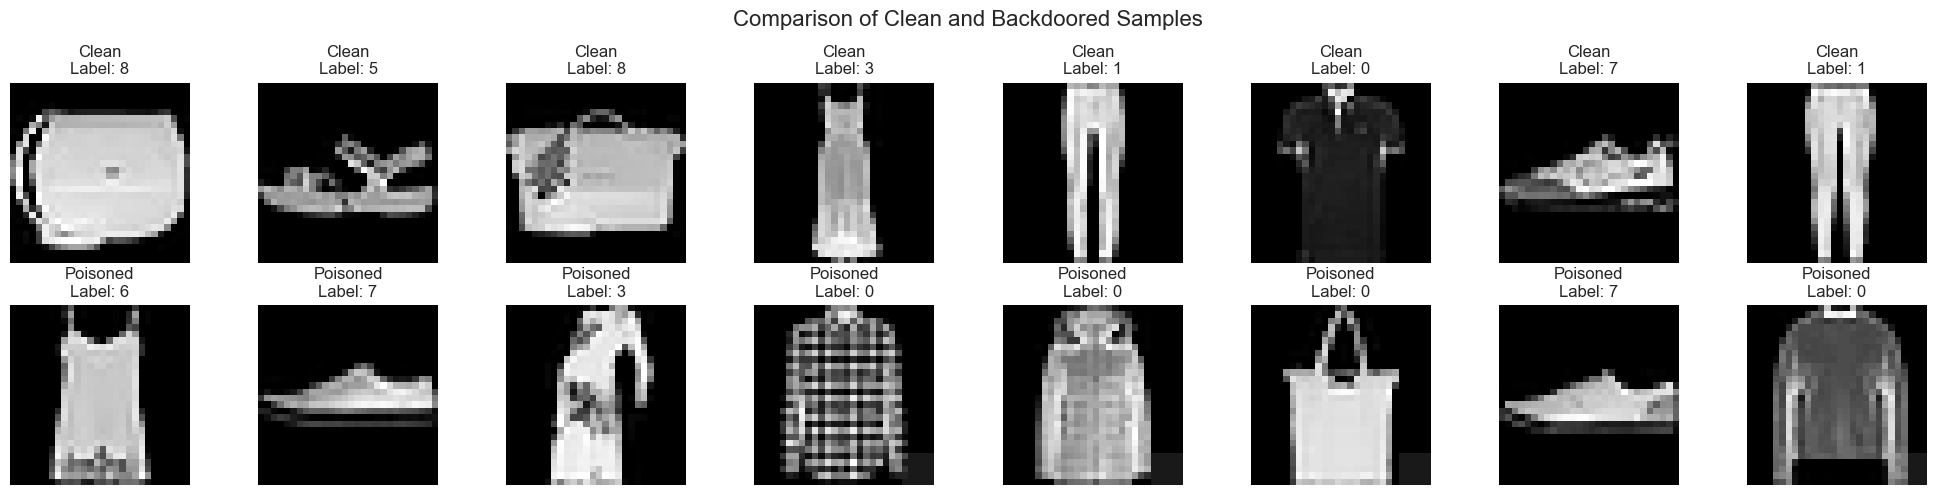


Statistics:
Number of samples shown: 8
Number of label changes: 56

Label changes:
Sample 0: 8 → 6
Sample 1: 5 → 7
Sample 2: 8 → 3
Sample 3: 3 → 0
Sample 4: 1 → 0
Sample 7: 1 → 0
Sample 8: 8 → 0
Sample 9: 2 → 0
Sample 10: 9 → 0
Sample 11: 6 → 0
Sample 12: 1 → 0
Sample 13: 7 → 8
Sample 14: 0 → 5
Sample 16: 7 → 0
Sample 17: 3 → 9
Sample 18: 7 → 5
Sample 19: 3 → 7
Sample 20: 4 → 8
Sample 21: 2 → 5
Sample 22: 2 → 0
Sample 23: 2 → 3
Sample 24: 1 → 3
Sample 25: 8 → 0
Sample 26: 5 → 4
Sample 27: 5 → 0
Sample 28: 3 → 0
Sample 30: 1 → 0
Sample 31: 1 → 3
Sample 32: 4 → 5
Sample 33: 7 → 0
Sample 34: 8 → 1
Sample 35: 6 → 0
Sample 36: 1 → 0
Sample 37: 3 → 0
Sample 38: 8 → 9
Sample 39: 4 → 0
Sample 40: 7 → 0
Sample 41: 1 → 0
Sample 42: 4 → 1
Sample 43: 5 → 0
Sample 45: 4 → 0
Sample 47: 8 → 0
Sample 48: 1 → 0
Sample 49: 6 → 0
Sample 50: 4 → 7
Sample 52: 5 → 1
Sample 53: 6 → 0
Sample 54: 7 → 9
Sample 55: 1 → 0
Sample 56: 2 → 0
Sample 57: 0 → 1
Sample 58: 2 → 0
Sample 59: 5 → 0
Sample 60: 3 → 0
Sample

In [15]:

strength = 0.1
bm = "single"
# bm = "cmd"
# bm = "None"
n_adv = 1


data_diff_adv = collections.OrderedDict()
for n_adv in range(1,6):
    file_name = f"./result/backdoor_mode_{bm}_strength_{strength}/n_seller_10_n_adv_{n_adv}_local_epoch_2_local_lr_0.01/market_log.ckpt"
    cur_data = torch.load(file_name, weights_only=False )  # Change filename as needed
    data_diff_adv[n_adv] = (cur_data)
visualize_comparative(data_diff_adv)




In [16]:
records = torch.load("./result/backdoor_mode_single_strength_0.1/n_seller_10_n_adv_1_local_epoch_2_local_lr_0.01/local_log_adv_seller_0.ckpt", weights_only=False)


SyntaxError: invalid syntax (3975885806.py, line 73)

# Visualize local

In [44]:
import torch
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory where your ckpt files are stored (adjust as needed)
log_dir = "./result/backdoor_mode_single_strength_0.1/n_seller_10_n_adv_1_local_epoch_2_local_lr_0.01"  # assuming they are in the current directory

# Find all files matching the pattern local_log_*.ckpt
file_pattern = os.path.join(log_dir, "local_log_*.ckpt")
files = glob.glob(file_pattern)

all_records = []

# Loop over each file and read the records
for filename in files:
    # Extract client id from filename (assuming pattern: local_log_{client_id}.ckpt)
    print(filename)
    base = os.path.basename(filename)
    client_id = int(base.split("_")[-1].split(".")[0])
    print(client_id)
    
    # Load the checkpoint file (assuming it's saved with torch.save)
    # Adjust the loading method if your ckpt files use a different format.
    records = torch.load(filename, weights_only=False)
    
    # Assume records is a list of dictionaries for each round
    # with keys: "round_number", "is_selected", etc.
    for record in records:
        record["client_id"] = client_id
        all_records.append(record)

# Convert the list of records to a pandas DataFrame
df = pd.DataFrame(all_records)

# Ensure that the is_selected field is integer (1 for True, 0 for False)
df["is_selected"] = df["is_selected"].astype(int)

# Pivot the DataFrame: rows = round_number, columns = client_id, values = is_selected
pivot_df = df.pivot(index="round_number", columns="client_id", values="is_selected")
pivot_df = pivot_df.sort_index()

# Create a heatmap of the selection status over rounds
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5, linecolor='gray')
plt.title("Selection Pattern for All Clients Over Rounds")
plt.xlabel("Client ID")
plt.ylabel("Global Round")
plt.show()


./result/backdoor_mode_single_strength_0.1/n_seller_10_n_adv_1_local_epoch_2_local_lr_0.01\local_log_adv_seller_0.ckpt
0


SyntaxError: invalid syntax (utils.py, line 223)

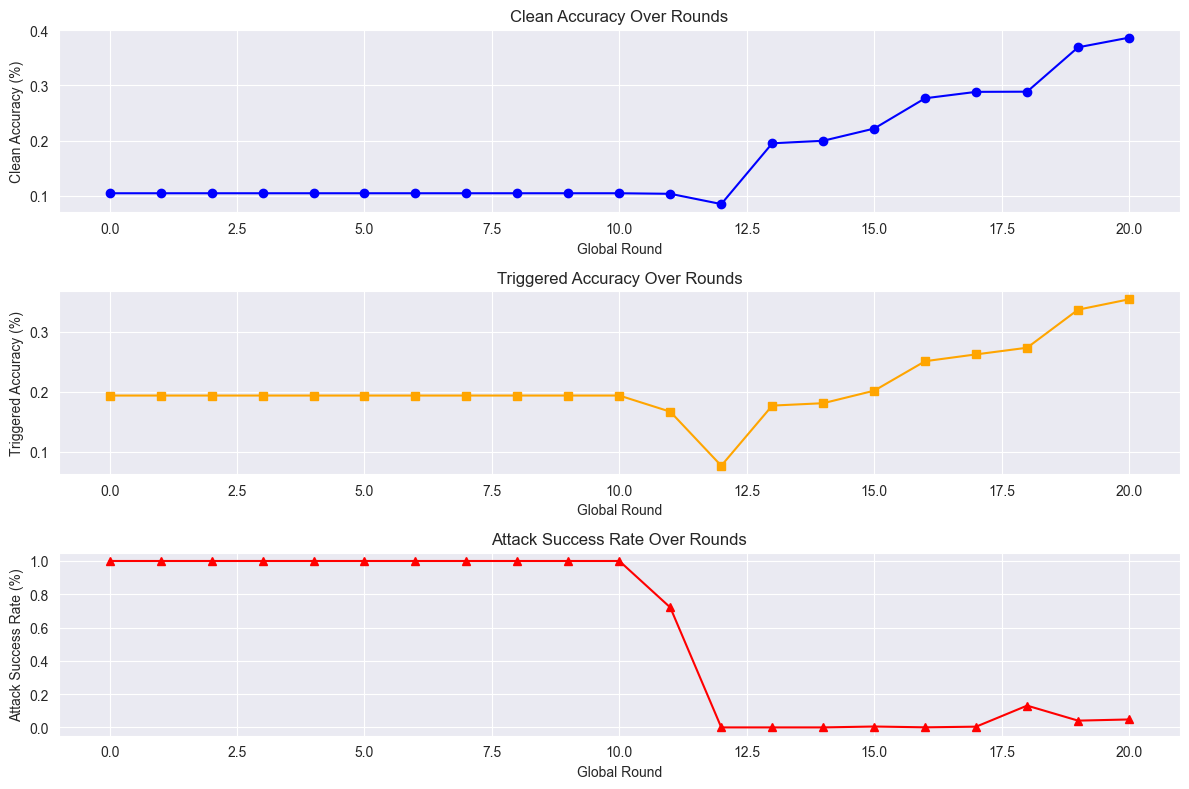

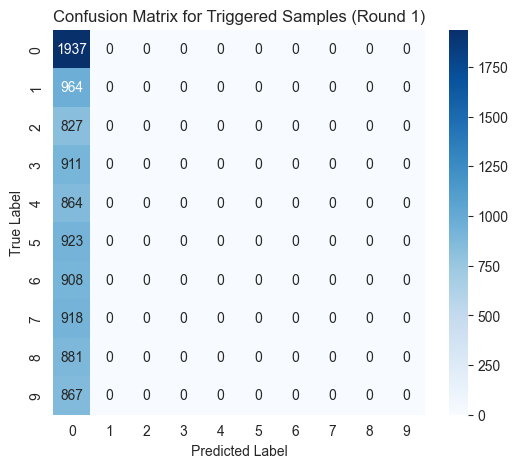

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch

# Assume round_records is your list of dictionaries, one per round.
# Each record is assumed to have a structure similar to:
# {
#    "round_number": <int>,
#    "extra_info": {
#         "poison_metrics": {
#              "clean_accuracy": float,
#              "triggered_accuracy": float,
#              "attack_success_rate": float,
#              "confusion_matrix_triggered": np.array or similar
#         },
#         ... other info ...
#    },
#    ... other keys ...
# }

def extract_metrics(round_records):
    rounds = []
    clean_acc = []
    triggered_acc = []
    asr = []
    confusion_matrices = []

    for record in round_records:
        round_num = record.get("round_number", None)
        if round_num is None:
            continue
        rounds.append(round_num)
        poison_metrics = record.get("extra_info", {}).get("poison_metrics", {})
        clean_acc.append(poison_metrics.get("clean_accuracy", np.nan))
        triggered_acc.append(poison_metrics.get("triggered_accuracy", np.nan))
        asr.append(poison_metrics.get("attack_success_rate", np.nan))
        confusion_matrices.append(poison_metrics.get("confusion_matrix_triggered", None))
    return rounds, clean_acc, triggered_acc, asr, confusion_matrices

def plot_attack_metrics(rounds, clean_acc, triggered_acc, asr):
    plt.figure(figsize=(12, 8))
    
    # Plot Clean Accuracy
    plt.subplot(3,1,1)
    plt.plot(rounds, clean_acc, marker='o', linestyle='-', color='blue')
    plt.xlabel("Global Round")
    plt.ylabel("Clean Accuracy (%)")
    plt.title("Clean Accuracy Over Rounds")
    plt.grid(True)
    
    # Plot Triggered Accuracy
    plt.subplot(3,1,2)
    plt.plot(rounds, triggered_acc, marker='s', linestyle='-', color='orange')
    plt.xlabel("Global Round")
    plt.ylabel("Triggered Accuracy (%)")
    plt.title("Triggered Accuracy Over Rounds")
    plt.grid(True)
    
    # Plot Attack Success Rate
    plt.subplot(3,1,3)
    plt.plot(rounds, asr, marker='^', linestyle='-', color='red')
    plt.xlabel("Global Round")
    plt.ylabel("Attack Success Rate (%)")
    plt.title("Attack Success Rate Over Rounds")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_confusion_matrix(conf_matrix, round_number):
    """
    Visualize a confusion matrix (assumed to be a numpy array) for a given round.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for Triggered Samples (Round {round_number})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

round_records = []  # e.g., load from a file or variable

# For demonstration, here's a dummy record list
dummy_conf_matrix = np.array([[50, 10], [5, 35]])
round_records = torch.load(file_name, weights_only=False )  


# Extract metrics
rounds, clean_acc, triggered_acc, asr, conf_matrices = extract_metrics(round_records)

# Plot the main metrics over rounds
plot_attack_metrics(rounds, clean_acc, triggered_acc, asr)

# Optionally, visualize confusion matrix for a selected round, e.g., round 2
# You can loop over or choose a round based on some criteria.
selected_round_index = 1  # corresponds to round 2 in our dummy data
if conf_matrices[selected_round_index] is not None:
    visualize_confusion_matrix(conf_matrices[selected_round_index], rounds[selected_round_index])


In [5]:

import torch


t = torch.load("result/backdoor_mode_cmd_strength_0.1/n_seller_10_n_adv_1_local_epoch_2_local_lr_0.01/local_log_adv_seller_0.ckpt", map_location=torch.device("cpu"))

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_379492\1553917950.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load("result/backdoor_mode_cmd_strength_0.1/n

SyntaxError: invalid syntax (utils.py, line 223)

In [ ]:
import sys
print(sys.version)

In [ ]:
experiment_log = []  # will be a list of dicts

# For each combination of parameters you run:
#   is_sybil, sybil_mode, grad_mode, poison_strength, trigger_rate, n_advs, ...
# you record final metrics: final_acc, final_asr, final_mal_sel_rate, etc.

experiment_log.append({
    "is_sybil": is_sybil,
    "sybil_mode": sybil_mode,
    "grad_mode": grad_mode,
    "poison_strength": ps,
    "trigger_rate": tr,
    "n_advs": advs,
    "final_accuracy": final_acc,
    "final_backdoor_success": final_asr,
    "malicious_selection_rate": mal_rate,
    # possibly more metrics
})

# Then convert to a DataFrame for easy pivoting or plotting:
import pandas as pd
df = pd.DataFrame(experiment_log)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_sybil_attack_success_n_adv_grad_modes(df):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
    # Rows = grad_mode in ["single", "cmd"]
    # Cols = is_sybil in [False, True]
    grad_modes = ["single", "cmd"]
    is_sybil_vals = [False, True]

    for row, gm in enumerate(grad_modes):
        for col, syb in enumerate(is_sybil_vals):
            ax = axes[row, col]

            # Filter data for that grad_mode & is_sybil
            sub_df = df[(df["grad_mode"] == gm) & (df["is_sybil"] == syb)]

            # We want to plot final_backdoor_success (for instance) vs. n_advs,
            # possibly multiple lines for (trigger_rate, poison_strength)
            # We'll combine them into one "parameter combo" to differentiate by color:
            for (tr, ps), group in sub_df.groupby(["trigger_rate", "poison_strength"]):
                # group => all rows with that TR, PS
                # x => n_advs, y => final_backdoor_success
                # We can sort by n_advs so lines are drawn in order
                group_sorted = group.sort_values("n_advs")
                ax.plot(group_sorted["n_advs"], group_sorted["final_backdoor_success"],
                        marker='o', label=f"TR={tr},PS={ps}")

            ax.set_title(f"GM={gm}, Sybil={syb}")
            ax.set_xlabel("# Adversaries")
            ax.set_ylabel("Backdoor Success")
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_bar_for_cmd_trigger_ps(df):
    # Suppose we fix grad_mode="cmd", is_sybil=True, n_advs=3
    sub_df = df[(df["grad_mode"] == "cmd") &
                (df["is_sybil"] == True) &
                (df["n_advs"] == 3)]

    # We'll make a grouped bar chart for each (trigger_rate, poison_strength).
    # x-axis => "param combo", left bar => final_accuracy, right bar => final_backdoor_success
    sub_df["param_combo"] = sub_df.apply(lambda row: f"TR={row.trigger_rate},PS={row.poison_strength}", axis=1)

    x_vals = sub_df["param_combo"]
    final_acc = sub_df["final_accuracy"]
    final_asr = sub_df["final_backdoor_success"]

    import numpy as np
    x_index = np.arange(len(sub_df))
    width = 0.3

    fig, ax = plt.subplots(figsize=(8,4))
    bar1 = ax.bar(x_index - width/2, final_acc, width, label='Final Acc')
    bar2 = ax.bar(x_index + width/2, final_asr, width, label='Backdoor SR')

    ax.set_xticks(x_index)
    ax.set_xticklabels(x_vals, rotation=45, ha='right')
    ax.legend()
    ax.set_title("Comparison at grad_mode=cmd, is_sybil=True, n_advs=3")
    ax.set_ylabel("Metric Value")

    plt.tight_layout()
    plt.show()


In [ ]:
# process the result, save into logs

In [4]:
import os
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from collections import defaultdict

def process_single_experiment(file_path, attack_params):
    """
    Process a single experiment file and extract metrics.

    Args:
        file_path: Path to the market_log.ckpt file
        attack_params: Dictionary containing attack parameters

    Returns:
        processed_data: List of dictionaries with processed round data
        summary_data: Dictionary with summary metrics
    """
    # Load the experiment data
    experiment_data = torch.load(file_path, weights_only=False, map_location=torch.device('cpu'))

    # Extract round records
    round_records = experiment_data
    if not round_records:
        print(f"Warning: No round records found in {file_path}")
        return [], {}

    processed_data = []

    for i, record in enumerate(round_records):
        round_num = record.get('round_number', i)

        # Extract basic round info
        round_data = {
            'round': round_num,
            **attack_params  # Include attack parameters
        }

        # Extract performance metrics
        if 'final_perf_global' in record and record['final_perf_global'] is not None:
            round_data['main_acc'] = record['final_perf_global'].get('acc', None)
            round_data['main_loss'] = record['final_perf_global'].get('loss', None)

        # Extract backdoor attack metrics
        extra_info = record.get('extra_info', {})
        if 'poison_metrics' in extra_info:
            poison_metrics = extra_info['poison_metrics']
            round_data['clean_acc'] = poison_metrics.get('clean_accuracy', None)
            round_data['triggered_acc'] = poison_metrics.get('triggered_accuracy', None)
            round_data['asr'] = poison_metrics.get('attack_success_rate', None)

        # Extract selection rates
        if 'selection_rate_info' in record:
            selection_info = record['selection_rate_info']
            round_data['malicious_rate'] = selection_info.get('malicious_rate', None)
            round_data['benign_rate'] = selection_info.get('benign_rate', None)
            round_data['avg_malicious_rate'] = selection_info.get('avg_malicious_rate', None)
            round_data['avg_benign_rate'] = selection_info.get('avg_benign_rate', None)

        processed_data.append(round_data)

    # Calculate summary metrics
    if processed_data:
        # Sort records by round
        sorted_records = sorted(processed_data, key=lambda x: x['round'])

        # Calculate summary metrics
        summary = {
            **attack_params,

            # Calculate max ASR achieved during training
            'MAX_ASR': max([r.get('asr', 0) or 0 for r in sorted_records]),

            # Calculate final metrics (last round)
            'FINAL_ASR': sorted_records[-1].get('asr', None),
            'FINAL_MAIN_ACC': sorted_records[-1].get('main_acc', None),
            'FINAL_CLEAN_ACC': sorted_records[-1].get('clean_acc', None),
            'FINAL_TRIGGERED_ACC': sorted_records[-1].get('triggered_acc', None),

            # Calculate ASR at different stages of training
            'ASR_25PCT': next((r.get('asr', None) for r in sorted_records if r['round'] >= len(sorted_records) * 0.25), None),
            'ASR_50PCT': next((r.get('asr', None) for r in sorted_records if r['round'] >= len(sorted_records) * 0.5), None),
            'ASR_75PCT': next((r.get('asr', None) for r in sorted_records if r['round'] >= len(sorted_records) * 0.75), None),

            # Calculate rounds to reach specific ASR thresholds
            'ROUNDS_TO_50PCT_ASR': next((r['round'] for r in sorted_records if (r.get('asr', 0) or 0) >= 0.5), float('inf')),
            'ROUNDS_TO_75PCT_ASR': next((r['round'] for r in sorted_records if (r.get('asr', 0) or 0) >= 0.75), float('inf')),
            'ROUNDS_TO_90PCT_ASR': next((r['round'] for r in sorted_records if (r.get('asr', 0) or 0) >= 0.9), float('inf')),

            # Calculate average selection rates
            'AVG_MALICIOUS_RATE': np.mean([r.get('malicious_rate', 0) or 0 for r in sorted_records]),
            'AVG_BENIGN_RATE': np.mean([r.get('benign_rate', 0) or 0 for r in sorted_records]),

            # Calculate attack efficiency
            'ASR_PER_ADV': (sorted_records[-1].get('asr', 0) or 0) / attack_params['N_ADV'] if attack_params['N_ADV'] > 0 else 0,

            # Calculate stealth (1 - abs difference between clean and final accuracy)
            'STEALTH': 1 - abs((sorted_records[-1].get('main_acc', 0) or 0) - (sorted_records[-1].get('clean_acc', 0) or 0)),

            # Total rounds
            'TOTAL_ROUNDS': len(sorted_records)
        }

        # Handle infinite values for CSV export
        for key, value in summary.items():
            if value == float('inf'):
                summary[key] = -1  # Use -1 to represent "never reached threshold"

        return processed_data, summary
    else:
        return [], {}
    # 
    # except Exception as e:
    #     print(f"Error processing {file_path}: {e}")
    #     return [], {}

def get_save_path(n_sellers, n_adversaries, local_epoch, local_lr, gradient_manipulation_mode,
                  poison_strength, trigger_type, is_sybil, trigger_rate,
                  aggregation_method='martfl', dataset_name='FMNIST', sybil_mode='mimic'):
    """
    Construct a save path based on the experiment parameters.
    This is a copy of your function.
    """
    # Use is_sybil flag or, if not true, use sybil_mode
    sybil_str = str(sybil_mode) if is_sybil else False
    base_dir = Path("./results") / f"is_sybil_{sybil_str}" / "backdoor" / aggregation_method / dataset_name

    if gradient_manipulation_mode == "None":
        subfolder = "no_attack"
        param_str = f"n_seller_{n_sellers}_local_epoch_{local_epoch}_local_lr_{local_lr}"
    elif gradient_manipulation_mode == "cmd":
        subfolder = f"backdoor_mode_{gradient_manipulation_mode}_strength_{poison_strength}_trigger_type_{trigger_type}"
        param_str = f"n_seller_{n_sellers}_n_adv_{n_adversaries}_local_epoch_{local_epoch}_local_lr_{local_lr}"
    elif gradient_manipulation_mode == "single":
        subfolder = f"backdoor_mode_{gradient_manipulation_mode}_trigger_rate_{trigger_rate}_trigger_type_{trigger_type}"
        param_str = f"n_seller_{n_sellers}_n_adv_{n_adversaries}_local_epoch_{local_epoch}_local_lr_{local_lr}"
    else:
        raise NotImplementedError(f"No such attack type: {gradient_manipulation_mode}")

    # Construct the full save path
    save_path = base_dir / subfolder / param_str
    return str(save_path)

def process_all_experiments(output_dir='./processed_data', local_epoch=5):
    """
    Process all experiment files using the same parameter combinations as in your loop.
    """
    all_processed_data = []
    all_summary_data = []

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Use the same parameter combinations as in your loop
    for grad_mode in ['cmd', 'single']:
        for trigger_rate in [0.1, 0.5, 0.7]:
            for poison_strength in [0.1, 0.5, 1.0]:
                for is_sybil in [False, True]:
                    for n_adv in [1, 3, 5]:
                        # Skip invalid combinations
                        if grad_mode == 'single' and poison_strength != 0.1:
                            continue
                        if trigger_rate == 0.7 and grad_mode == 'cmd':
                            continue

                        # Get the file path
                        save_path = get_save_path(
                            n_sellers=10,
                            n_adversaries=n_adv,
                            local_epoch=local_epoch,
                            local_lr=1e-2,
                            gradient_manipulation_mode=grad_mode,
                            poison_strength=poison_strength,
                            trigger_type="blended_patch",
                            is_sybil=is_sybil,
                            trigger_rate=trigger_rate
                        )

                        # Construct the full file path
                        file_path = f"{save_path}/market_log.ckpt"

                        if not os.path.exists(file_path):
                            print(f"File not found: {file_path}")
                            continue

                        print(f"Processing: {file_path}")

                        # Extract attack parameters
                        attack_params = {
                            'GRAD_MODE': grad_mode,
                            'TRIGGER_RATE': trigger_rate,
                            'POISON_STRENGTH': poison_strength,
                            'IS_SYBIL': is_sybil,
                            'N_ADV': n_adv
                        }

                        # Process the file
                        processed_data, summary = process_single_experiment(file_path, attack_params)

                        # Add to the overall data
                        all_processed_data.extend(processed_data)
                        if summary:
                            all_summary_data.append(summary)

    # Convert to DataFrames
    all_rounds_df = pd.DataFrame(all_processed_data)
    summary_df = pd.DataFrame(all_summary_data)

    # Save to CSV
    if not all_rounds_df.empty:
        all_rounds_csv = f"{output_dir}/all_rounds.csv"
        all_rounds_df.to_csv(all_rounds_csv, index=False)
        print(f"Saved all rounds data to {all_rounds_csv}")

    if not summary_df.empty:
        summary_csv = f"{output_dir}/summary.csv"
        summary_df.to_csv(summary_csv, index=False)
        print(f"Saved summary data to {summary_csv}")

    return all_rounds_df, summary_df

if __name__ == "__main__":
    # Process all experiments
    file_path = "./result/market_log.ckpt"
    attack_params = {
    'GRAD_MODE': "cmd",
    'TRIGGER_RATE': 0.5,
    'POISON_STRENGTH': 1.0,
    'IS_SYBIL': "mimic",
    'N_ADV': 3
    }
    
    # Process the file
    processed_data, summary = process_single_experiment(file_path, attack_params)


    # all_rounds_df, summary_df = process_all_experiments()

    # # Print summary statistics
    # if not summary_df.empty:
    #     print("\nSummary Statistics:")
    #     print(f"Total experiments processed: {len(summary_df)}")
    #     print(f"Average Final ASR: {summary_df['FINAL_ASR'].mean():.4f}")
    #     print(f"Average Main Accuracy: {summary_df['FINAL_MAIN_ACC'].mean():.4f}")
    # 
    #     # Group by attack type
    #     for grad_mode in summary_df['GRAD_MODE'].unique():
    #         grad_data = summary_df[summary_df['GRAD_MODE'] == grad_mode]
    #         print(f"\nGradient Mode: {grad_mode}")
    #         print(f"  Average ASR: {grad_data['FINAL_ASR'].mean():.4f}")
    #         print(f"  Average Main Accuracy: {grad_data['FINAL_MAIN_ACC'].mean():.4f}")
    # 
    #     # Group by Sybil mode
    #     for is_sybil in summary_df['IS_SYBIL'].unique():
    #         sybil_data = summary_df[summary_df['IS_SYBIL'] == is_sybil]
    #         print(f"\nSybil Mode: {is_sybil}")
    #         print(f"  Average ASR: {sybil_data['FINAL_ASR'].mean():.4f}")
    #         print(f"  Average Main Accuracy: {sybil_data['FINAL_MAIN_ACC'].mean():.4f}")

# visualize the csv file

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def load_processed_data(summary_csv, all_rounds_csv):
    """
    Load the processed summary and round-by-round data.
    """
    summary_df = pd.read_csv(summary_csv)
    all_rounds_df = pd.read_csv(all_rounds_csv)

    # Convert boolean columns
    if 'IS_SYBIL' in summary_df.columns:
        summary_df['IS_SYBIL'] = summary_df['IS_SYBIL'].astype(bool)
    if 'IS_SYBIL' in all_rounds_df.columns:
        all_rounds_df['IS_SYBIL'] = all_rounds_df['IS_SYBIL'].astype(bool)

    return summary_df, all_rounds_df

def create_output_dir(output_dir):
    """Create output directory if it doesn't exist"""
    os.makedirs(output_dir, exist_ok=True)

def plot_attack_success_comparison(summary_df, output_dir):
    """
    Plot comparisons of Attack Success Rate (ASR) across different parameters.
    """
    plt.figure(figsize=(20, 16))

    # 1. ASR by Gradient Manipulation Method
    plt.subplot(2, 2, 1)
    sns.barplot(x='GRAD_MODE', y='FINAL_ASR', data=summary_df, ci=None)
    plt.title('Attack Success Rate by Gradient Method', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. ASR by Trigger Rate
    plt.subplot(2, 2, 2)
    sns.barplot(x='TRIGGER_RATE', y='FINAL_ASR', data=summary_df, ci=None)
    plt.title('Attack Success Rate by Trigger Rate', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 3. ASR by Number of Adversaries
    plt.subplot(2, 2, 3)
    sns.barplot(x='N_ADV', y='FINAL_ASR', data=summary_df, ci=None)
    plt.title('Attack Success Rate by Number of Adversaries', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. ASR with and without Sybil Attack
    plt.subplot(2, 2, 4)
    sns.barplot(x='IS_SYBIL', y='FINAL_ASR', data=summary_df, ci=None)
    plt.title('Attack Success Rate with/without Sybil Attack', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Sybil Attack Enabled')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/asr_comparison.png", dpi=300)
    plt.close()

def plot_parameter_interactions(summary_df, output_dir):
    """
    Plot interactions between different attack parameters.
    """
    plt.figure(figsize=(20, 16))

    # 1. ASR by Poison Strength for CMD mode
    plt.subplot(2, 2, 1)
    cmd_data = summary_df[summary_df['GRAD_MODE'] == 'cmd']
    if not cmd_data.empty:
        sns.barplot(x='POISON_STRENGTH', y='FINAL_ASR', data=cmd_data, ci=None)
        plt.title('ASR by Poison Strength (CMD Mode)', fontsize=14)
        plt.ylim(0, 1.05)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. ASR by Trigger Rate and Gradient Mode
    plt.subplot(2, 2, 2)
    sns.barplot(x='TRIGGER_RATE', y='FINAL_ASR', hue='GRAD_MODE', data=summary_df, ci=None)
    plt.title('ASR by Trigger Rate and Gradient Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 3. ASR by Number of Adversaries and Sybil Mode
    plt.subplot(2, 2, 3)
    sns.barplot(x='N_ADV', y='FINAL_ASR', hue='IS_SYBIL', data=summary_df, ci=None)
    plt.title('ASR by Number of Adversaries and Sybil Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. ASR by Sybil Mode and Gradient Mode
    plt.subplot(2, 2, 4)
    sns.barplot(x='IS_SYBIL', y='FINAL_ASR', hue='GRAD_MODE', data=summary_df, ci=None)
    plt.title('ASR by Sybil Mode and Gradient Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Sybil Attack Enabled')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/parameter_interactions.png", dpi=300)
    plt.close()

def plot_tradeoff_analysis(summary_df, output_dir):
    """
    Plot trade-off between attack success and model accuracy.
    """
    plt.figure(figsize=(20, 10))

    # 1. ASR vs Main Task Accuracy by Gradient Mode
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x='FINAL_MAIN_ACC',
        y='FINAL_ASR',
        hue='GRAD_MODE',
        size='TRIGGER_RATE',
        data=summary_df,
        sizes=(50, 200),
        alpha=0.7
    )
    plt.title('ASR vs Main Task Accuracy by Gradient Mode', fontsize=14)
    plt.xlim(0.5, 1.05)
    plt.ylim(0, 1.05)
    plt.grid(linestyle='--', alpha=0.7)

    # 2. ASR vs Main Task Accuracy by Sybil Mode
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x='FINAL_MAIN_ACC',
        y='FINAL_ASR',
        hue='IS_SYBIL',
        size='N_ADV',
        data=summary_df,
        sizes=(50, 200),
        alpha=0.7
    )
    plt.title('ASR vs Main Task Accuracy by Sybil Mode', fontsize=14)
    plt.xlim(0.5, 1.05)
    plt.ylim(0, 1.05)
    plt.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/tradeoff_analysis.png", dpi=300)
    plt.close()

def plot_efficiency_analysis(summary_df, output_dir):
    """
    Plot attack efficiency metrics.
    """
    plt.figure(figsize=(20, 10))

    # 1. ASR per Adversary by Number of Adversaries
    plt.subplot(1, 2, 1)
    sns.barplot(x='N_ADV', y='ASR_PER_ADV', data=summary_df, ci=None)
    plt.title('Attack Efficiency (ASR per Adversary)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. ASR per Adversary by Gradient Mode and Sybil Mode
    plt.subplot(1, 2, 2)
    sns.barplot(x='GRAD_MODE', y='ASR_PER_ADV', hue='IS_SYBIL', data=summary_df, ci=None)
    plt.title('Attack Efficiency by Gradient Mode and Sybil Mode', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/efficiency_analysis.png", dpi=300)
    plt.close()

def plot_stealth_analysis(summary_df, output_dir):
    """
    Plot stealth metrics to see how well attacks preserve model accuracy.
    """
    plt.figure(figsize=(20, 10))

    # 1. Stealth by Gradient Mode
    plt.subplot(1, 2, 1)
    sns.barplot(x='GRAD_MODE', y='STEALTH', data=summary_df, ci=None)
    plt.title('Attack Stealth by Gradient Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Stealth by Trigger Rate and Number of Adversaries
    plt.subplot(1, 2, 2)
    # Create a new column for trigger rate and adversary combinations
    summary_df['TR_ADV'] = summary_df['TRIGGER_RATE'].astype(str) + '_' + summary_df['N_ADV'].astype(str)
    sns.barplot(x='TR_ADV', y='STEALTH', data=summary_df, ci=None)
    plt.title('Attack Stealth by Trigger Rate and N_ADV', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/stealth_analysis.png", dpi=300)
    plt.close()

def plot_attack_progression(all_rounds_df, output_dir):
    """
    Plot progression of attack success and model accuracy over rounds.
    """
    # Group data by attack configuration for grad mode comparison
    plt.figure(figsize=(15, 10))

    # For meaningful average trends, group by GRAD_MODE and calculate statistics
    grouped_data = all_rounds_df.groupby(['GRAD_MODE', 'round']).agg({
        'asr': ['mean', 'std'],
        'main_acc': ['mean', 'std']
    }).reset_index()

    # Flatten multi-level columns
    grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

    # Plot ASR progression by gradient mode
    plt.subplot(2, 1, 1)
    for grad_mode in all_rounds_df['GRAD_MODE'].unique():
        data = grouped_data[grouped_data['GRAD_MODE'] == grad_mode]

        # Plot mean with shaded std deviation
        plt.plot(data['round'], data['asr_mean'], label=f'{grad_mode}', marker='o', markersize=4)
        plt.fill_between(
            data['round'],
            data['asr_mean'] - data['asr_std'],
            data['asr_mean'] + data['asr_std'],
            alpha=0.2
        )

    plt.title('ASR Progression by Gradient Mode', fontsize=14)
    plt.xlabel('Round')
    plt.ylabel('Attack Success Rate')
    plt.ylim(0, 1.05)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    # Plot Main Accuracy progression by gradient mode
    plt.subplot(2, 1, 2)
    for grad_mode in all_rounds_df['GRAD_MODE'].unique():
        data = grouped_data[grouped_data['GRAD_MODE'] == grad_mode]

        plt.plot(data['round'], data['main_acc_mean'], label=f'{grad_mode}', marker='o', markersize=4)
        plt.fill_between(
            data['round'],
            data['main_acc_mean'] - data['main_acc_std'],
            data['main_acc_mean'] + data['main_acc_std'],
            alpha=0.2
        )

    plt.title('Main Task Accuracy Progression by Gradient Mode', fontsize=14)
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.05)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/progression_by_grad_mode.png", dpi=300)
    plt.close()

    # Group data by attack configuration for Sybil mode comparison
    plt.figure(figsize=(15, 10))

    # For meaningful average trends, group by IS_SYBIL and calculate statistics
    grouped_data = all_rounds_df.groupby(['IS_SYBIL', 'round']).agg({
        'asr': ['mean', 'std'],
        'main_acc': ['mean', 'std']
    }).reset_index()

    # Flatten multi-level columns
    grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

    # Plot ASR progression by Sybil mode
    plt.subplot(2, 1, 1)
    for is_sybil in all_rounds_df['IS_SYBIL'].unique():
        data = grouped_data[grouped_data['IS_SYBIL'] == is_sybil]

        # Plot mean with shaded std deviation
        plt.plot(data['round'], data['asr_mean'], label=f'Sybil={is_sybil}', marker='o', markersize=4)
        plt.fill_between(
            data['round'],
            data['asr_mean'] - data['asr_std'],
            data['asr_mean'] + data['asr_std'],
            alpha=0.2
        )

    plt.title('ASR Progression by Sybil Mode', fontsize=14)
    plt.xlabel('Round')
    plt.ylabel('Attack Success Rate')
    plt.ylim(0, 1.05)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    # Plot Main Accuracy progression by Sybil mode
    plt.subplot(2, 1, 2)
    for is_sybil in all_rounds_df['IS_SYBIL'].unique():
        data = grouped_data[grouped_data['IS_SYBIL'] == is_sybil]

        plt.plot(data['round'], data['main_acc_mean'], label=f'Sybil={is_sybil}', marker='o', markersize=4)
        plt.fill_between(
            data['round'],
            data['main_acc_mean'] - data['main_acc_std'],
            data['main_acc_mean'] + data['main_acc_std'],
            alpha=0.2
        )

    plt.title('Main Task Accuracy Progression by Sybil Mode', fontsize=14)
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.05)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/progression_by_sybil_mode.png", dpi=300)
    plt.close()

    # Group data by number of adversaries
    plt.figure(figsize=(15, 10))

    # For meaningful average trends, group by N_ADV and calculate statistics
    grouped_data = all_rounds_df.groupby(['N_ADV', 'round']).agg({
        'asr': ['mean', 'std'],
        'main_acc': ['mean', 'std']
    }).reset_index()

    # Flatten multi-level columns
    grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

    # Plot ASR progression by number of adversaries
    plt.subplot(2, 1, 1)
    for n_adv in sorted(all_rounds_df['N_ADV'].unique()):
        data = grouped_data[grouped_data['N_ADV'] == n_adv]

        # Plot mean with shaded std deviation
        plt.plot(data['round'], data['asr_mean'], label=f'N_ADV={n_adv}', marker='o', markersize=4)
        plt.fill_between(
            data['round'],
            data['asr_mean'] - data['asr_std'],
            data['asr_mean'] + data['asr_std'],
            alpha=0.2
        )

    plt.title('ASR Progression by Number of Adversaries', fontsize=14)
    plt.xlabel('Round')
    plt.ylabel('Attack Success Rate')
    plt.ylim(0, 1.05)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    # Plot Main Accuracy progression by number of adversaries
    plt.subplot(2, 1, 2)
    for n_adv in sorted(all_rounds_df['N_ADV'].unique()):
        data = grouped_data[grouped_data['N_ADV'] == n_adv]

        plt.plot(data['round'], data['main_acc_mean'], label=f'N_ADV={n_adv}', marker='o', markersize=4)
        plt.fill_between(
            data['round'],
            data['main_acc_mean'] - data['main_acc_std'],
            data['main_acc_mean'] + data['main_acc_std'],
            alpha=0.2
        )

    plt.title('Main Task Accuracy Progression by Number of Adversaries', fontsize=14)
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.05)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/progression_by_n_adv.png", dpi=300)
    plt.close()

    # Add comparative convergence analysis
    plt.figure(figsize=(20, 10))

    # Group data by configuration to find rounds to reach specific ASR thresholds
    config_data = []

    for config, group in all_rounds_df.groupby(['GRAD_MODE', 'TRIGGER_RATE', 'POISON_STRENGTH', 'IS_SYBIL', 'N_ADV']):
        grad_mode, trigger_rate, poison_strength, is_sybil, n_adv = config

        # Find rounds to reach certain ASR thresholds
        rounds_to_50pct = float('inf')
        rounds_to_75pct = float('inf')
        rounds_to_90pct = float('inf')

        # Sort by round
        sorted_group = group.sort_values('round')

        for _, row in sorted_group.iterrows():
            if row.get('asr', 0) >= 0.5 and rounds_to_50pct == float('inf'):
                rounds_to_50pct = row['round']
            if row.get('asr', 0) >= 0.75 and rounds_to_75pct == float('inf'):
                rounds_to_75pct = row['round']
            if row.get('asr', 0) >= 0.9 and rounds_to_90pct == float('inf'):
                rounds_to_90pct = row['round']

        config_data.append({
            'GRAD_MODE': grad_mode,
            'TRIGGER_RATE': trigger_rate,
            'POISON_STRENGTH': poison_strength,
            'IS_SYBIL': is_sybil,
            'N_ADV': n_adv,
            'ROUNDS_TO_50PCT_ASR': rounds_to_50pct if rounds_to_50pct != float('inf') else None,
            'ROUNDS_TO_75PCT_ASR': rounds_to_75pct if rounds_to_75pct != float('inf') else None,
            'ROUNDS_TO_90PCT_ASR': rounds_to_90pct if rounds_to_90pct != float('inf') else None
        })

    config_df = pd.DataFrame(config_data)

    # Convert to long format for plotting
    plot_data = pd.melt(
        config_df,
        id_vars=['GRAD_MODE', 'TRIGGER_RATE', 'POISON_STRENGTH', 'IS_SYBIL', 'N_ADV'],
        value_vars=['ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ROUNDS_TO_90PCT_ASR'],
        var_name='ASR_THRESHOLD',
        value_name='ROUNDS'
    )

    # Replace None with NaN for plotting
    plot_data['ROUNDS'] = pd.to_numeric(plot_data['ROUNDS'], errors='coerce')

    # Clean up labels
    plot_data['ASR_THRESHOLD'] = plot_data['ASR_THRESHOLD'].map({
        'ROUNDS_TO_50PCT_ASR': '50% ASR',
        'ROUNDS_TO_75PCT_ASR': '75% ASR',
        'ROUNDS_TO_90PCT_ASR': '90% ASR'
    })

    # Plot rounds to reach thresholds by gradient mode
    plt.subplot(1, 2, 1)
    sns.barplot(x='GRAD_MODE', y='ROUNDS', hue='ASR_THRESHOLD', data=plot_data)
    plt.title('Rounds to Reach ASR Thresholds by Gradient Mode', fontsize=14)
    plt.ylabel('Rounds')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot rounds to reach thresholds by Sybil mode
    plt.subplot(1, 2, 2)
    sns.barplot(x='IS_SYBIL', y='ROUNDS', hue='ASR_THRESHOLD', data=plot_data)
    plt.title('Rounds to Reach ASR Thresholds by Sybil Mode', fontsize=14)
    plt.ylabel('Rounds')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Sybil Attack Enabled')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/threshold_convergence_analysis.png", dpi=300)
    plt.close()

def plot_detailed_heatmaps(summary_df, output_dir):
    """
    Create heatmaps to show interactions between pairs of parameters.
    """
    # 1. ASR Heatmap: Trigger Rate vs Number of Adversaries
    plt.figure(figsize=(12, 10))
    pivot = summary_df.pivot_table(
        values='FINAL_ASR',
        index='TRIGGER_RATE',
        columns='N_ADV',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt='.2f')
    plt.title('ASR by Trigger Rate and Number of Adversaries', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/heatmap_trigger_rate_vs_n_adv.png", dpi=300)
    plt.close()

    # 2. ASR Heatmap: Gradient Mode vs Sybil Mode
    plt.figure(figsize=(12, 10))
    pivot = summary_df.pivot_table(
        values='FINAL_ASR',
        index='GRAD_MODE',
        columns='IS_SYBIL',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt='.2f')
    plt.title('ASR by Gradient Mode and Sybil Mode', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/heatmap_grad_mode_vs_sybil.png", dpi=300)
    plt.close()

    # 3. For CMD mode: ASR Heatmap by Poison Strength and Trigger Rate
    cmd_data = summary_df[summary_df['GRAD_MODE'] == 'cmd']
    if not cmd_data.empty:
        plt.figure(figsize=(12, 10))
        pivot = cmd_data.pivot_table(
            values='FINAL_ASR',
            index='POISON_STRENGTH',
            columns='TRIGGER_RATE',
            aggfunc='mean'
        )
        sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt='.2f')
        plt.title('ASR by Poison Strength and Trigger Rate (CMD Mode)', fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/heatmap_poison_strength_vs_trigger_rate.png", dpi=300)
        plt.close()

    # 4. Main Accuracy Heatmap: Gradient Mode vs Sybil Mode
    plt.figure(figsize=(12, 10))
    pivot = summary_df.pivot_table(
        values='FINAL_MAIN_ACC',
        index='GRAD_MODE',
        columns='IS_SYBIL',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0.7, vmax=1, fmt='.2f')
    plt.title('Main Task Accuracy by Gradient Mode and Sybil Mode', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/heatmap_accuracy_grad_mode_vs_sybil.png", dpi=300)
    plt.close()

    # 5. Stealth Heatmap: Trigger Rate vs Gradient Mode
    if 'STEALTH' in summary_df.columns:
        plt.figure(figsize=(12, 10))
        pivot = summary_df.pivot_table(
            values='STEALTH',
            index='TRIGGER_RATE',
            columns='GRAD_MODE',
            aggfunc='mean'
        )
        sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0.7, vmax=1, fmt='.2f')
        plt.title('Attack Stealth by Trigger Rate and Gradient Mode', fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/heatmap_stealth_trigger_rate_vs_grad_mode.png", dpi=300)
        plt.close()

def plot_trigger_rate_impact(summary_df, all_rounds_df, output_dir):
    """
    Analyze the impact of trigger rates on different metrics.
    """
    # Skip if trigger rate column is missing or only has one value
    if 'TRIGGER_RATE' not in summary_df.columns or len(summary_df['TRIGGER_RATE'].unique()) <= 1:
        return

    plt.figure(figsize=(20, 15))

    # 1. Trigger Rate Impact on Final ASR
    plt.subplot(2, 2, 1)
    sns.boxplot(x='TRIGGER_RATE', y='FINAL_ASR', data=summary_df)
    plt.title('Trigger Rate Impact on Final ASR', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Trigger Rate Impact on Main Task Accuracy
    plt.subplot(2, 2, 2)
    sns.boxplot(x='TRIGGER_RATE', y='FINAL_MAIN_ACC', data=summary_df)
    plt.title('Trigger Rate Impact on Main Task Accuracy', fontsize=14)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 3. Trigger Rate Impact on ASR by Gradient Mode
    plt.subplot(2, 2, 3)
    sns.boxplot(x='TRIGGER_RATE', y='FINAL_ASR', hue='GRAD_MODE', data=summary_df)
    plt.title('Trigger Rate Impact on ASR by Gradient Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. Trigger Rate Impact on Main Task Accuracy by Gradient Mode
    plt.subplot(2, 2, 4)
    sns.boxplot(x='TRIGGER_RATE', y='FINAL_MAIN_ACC', hue='GRAD_MODE', data=summary_df)
    plt.title('Trigger Rate Impact on Main Task Accuracy by Gradient Mode', fontsize=14)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/trigger_rate_impact.png", dpi=300)
    plt.close()

    # Also analyze convergence speed by trigger rate
    if 'ROUNDS_TO_50PCT_ASR' in summary_df.columns:
        plt.figure(figsize=(15, 10))

        # Convert -1 (never reached) to NaN for visualization
        df_plot = summary_df.copy()
        for col in ['ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ROUNDS_TO_90PCT_ASR']:
            if col in df_plot.columns:
                df_plot[col] = df_plot[col].replace(-1, np.nan)

        sns.boxplot(x='TRIGGER_RATE', y='ROUNDS_TO_50PCT_ASR', data=df_plot)
        plt.title('Rounds to Reach 50% ASR by Trigger Rate', fontsize=14)
        plt.ylabel('Rounds')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig(f"{output_dir}/trigger_rate_convergence.png", dpi=300)
        plt.close()

def plot_poison_strength_impact(summary_df, all_rounds_df, output_dir):
    """
    Analyze the impact of poison strength on different metrics (for CMD mode).
    """
    # Filter to CMD mode only
    cmd_df = summary_df[summary_df['GRAD_MODE'] == 'cmd']

    # Skip if empty or poison strength column is missing or only has one value
    if cmd_df.empty or 'POISON_STRENGTH' not in cmd_df.columns or len(cmd_df['POISON_STRENGTH'].unique()) <= 1:
        return

    plt.figure(figsize=(20, 15))

    # 1. Poison Strength Impact on Final ASR
    plt.subplot(2, 2, 1)
    sns.boxplot(x='POISON_STRENGTH', y='FINAL_ASR', data=cmd_df)
    plt.title('Poison Strength Impact on Final ASR (CMD Mode)', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Poison Strength Impact on Main Task Accuracy
    plt.subplot(2, 2, 2)
    sns.boxplot(x='POISON_STRENGTH', y='FINAL_MAIN_ACC', data=cmd_df)
    plt.title('Poison Strength Impact on Main Task Accuracy (CMD Mode)', fontsize=14)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 3. Poison Strength Impact on ASR by Sybil Mode
    plt.subplot(2, 2, 3)
    sns.boxplot(x='POISON_STRENGTH', y='FINAL_ASR', hue='IS_SYBIL', data=cmd_df)
    plt.title('Poison Strength Impact on ASR by Sybil Mode (CMD Mode)', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. Poison Strength Impact on Main Task Accuracy by Sybil Mode
    plt.subplot(2, 2, 4)
    sns.boxplot(x='POISON_STRENGTH', y='FINAL_MAIN_ACC', hue='IS_SYBIL', data=cmd_df)
    plt.title('Poison Strength Impact on Main Task Accuracy by Sybil Mode (CMD Mode)', fontsize=14)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/poison_strength_impact.png", dpi=300)
    plt.close()

    # Also analyze convergence speed by poison strength
    if 'ROUNDS_TO_50PCT_ASR' in cmd_df.columns:
        plt.figure(figsize=(15, 10))

        # Convert -1 (never reached) to NaN for visualization
        df_plot = cmd_df.copy()
        for col in ['ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ROUNDS_TO_90PCT_ASR']:
            if col in df_plot.columns:
                df_plot[col] = df_plot[col].replace(-1, np.nan)

        sns.boxplot(x='POISON_STRENGTH', y='ROUNDS_TO_50PCT_ASR', data=df_plot)
        plt.title('Rounds to Reach 50% ASR by Poison Strength (CMD Mode)', fontsize=14)
        plt.ylabel('Rounds')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig(f"{output_dir}/poison_strength_convergence.png", dpi=300)
        plt.close()

def plot_sybil_impact(summary_df, all_rounds_df, output_dir):
    """
    Analyze the impact of Sybil attacks on different metrics.
    """
    # Skip if Sybil column is missing or only has one value
    if 'IS_SYBIL' not in summary_df.columns or len(summary_df['IS_SYBIL'].unique()) <= 1:
        return

    plt.figure(figsize=(20, 15))

    # 1. Sybil Impact on Final ASR
    plt.subplot(2, 2, 1)
    sns.boxplot(x='IS_SYBIL', y='FINAL_ASR', data=summary_df)
    plt.title('Sybil Attack Impact on Final ASR', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Sybil Attack Enabled')

    # 2. Sybil Impact on Main Task Accuracy
    plt.subplot(2, 2, 2)
    sns.boxplot(x='IS_SYBIL', y='FINAL_MAIN_ACC', data=summary_df)
    plt.title('Sybil Attack Impact on Main Task Accuracy', fontsize=14)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Sybil Attack Enabled')

    # 3. Sybil Impact on ASR by Number of Adversaries
    plt.subplot(2, 2, 3)
    sns.boxplot(x='N_ADV', y='FINAL_ASR', hue='IS_SYBIL', data=summary_df)
    plt.title('Sybil Attack Impact on ASR by Number of Adversaries', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. Sybil Impact on ASR by Gradient Mode
    plt.subplot(2, 2, 4)
    sns.boxplot(x='GRAD_MODE', y='FINAL_ASR', hue='IS_SYBIL', data=summary_df)
    plt.title('Sybil Attack Impact on ASR by Gradient Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/sybil_impact.png", dpi=300)
    plt.close()

    # Analyze convergence speed difference with Sybil attacks
    if 'ROUNDS_TO_50PCT_ASR' in summary_df.columns:
        plt.figure(figsize=(15, 10))

        # Convert -1 (never reached) to NaN for visualization
        df_plot = summary_df.copy()
        for col in ['ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ROUNDS_TO_90PCT_ASR']:
            if col in df_plot.columns:
                df_plot[col] = df_plot[col].replace(-1, np.nan)

        plt.subplot(1, 2, 1)
        sns.boxplot(x='IS_SYBIL', y='ROUNDS_TO_50PCT_ASR', data=df_plot)
        plt.title('Rounds to Reach 50% ASR by Sybil Mode', fontsize=14)
        plt.ylabel('Rounds')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xlabel('Sybil Attack Enabled')

        plt.subplot(1, 2, 2)
        sns.boxplot(x='IS_SYBIL', y='ROUNDS_TO_75PCT_ASR', data=df_plot)
        plt.title('Rounds to Reach 75% ASR by Sybil Mode', fontsize=14)
        plt.ylabel('Rounds')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xlabel('Sybil Attack Enabled')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/sybil_convergence.png", dpi=300)
        plt.close()

def plot_adversary_scaling(summary_df, all_rounds_df, output_dir):
    """
    Analyze how attack effectiveness scales with the number of adversaries.
    """
    # Skip if adversary number column is missing or only has one value
    if 'N_ADV' not in summary_df.columns or len(summary_df['N_ADV'].unique()) <= 1:
        return

    plt.figure(figsize=(20, 15))

    # 1. Number of Adversaries Impact on Final ASR
    plt.subplot(2, 2, 1)
    sns.boxplot(x='N_ADV', y='FINAL_ASR', data=summary_df)
    plt.title('Number of Adversaries Impact on Final ASR', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Number of Adversaries Impact on Main Task Accuracy
    plt.subplot(2, 2, 2)
    sns.boxplot(x='N_ADV', y='FINAL_MAIN_ACC', data=summary_df)
    plt.title('Number of Adversaries Impact on Main Task Accuracy', fontsize=14)
    plt.ylim(0.5, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 3. Number of Adversaries Impact on ASR by Gradient Mode
    plt.subplot(2, 2, 3)
    sns.boxplot(x='N_ADV', y='FINAL_ASR', hue='GRAD_MODE', data=summary_df)
    plt.title('Number of Adversaries Impact on ASR by Gradient Mode', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 4. Attack Efficiency (ASR per Adversary)
    plt.subplot(2, 2, 4)
    if 'ASR_PER_ADV' not in summary_df.columns:
        summary_df['ASR_PER_ADV'] = summary_df['FINAL_ASR'] / summary_df['N_ADV']

    sns.boxplot(x='N_ADV', y='ASR_PER_ADV', data=summary_df)
    plt.title('Attack Efficiency (ASR per Adversary)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/adversary_scaling.png", dpi=300)
    plt.close()

    # Plot curves showing how ASR scales with number of adversaries
    plt.figure(figsize=(15, 10))

    # Group by all other parameters except N_ADV to see scaling within same configurations
    scaling_data = []

    param_groups = summary_df.groupby(['GRAD_MODE', 'TRIGGER_RATE', 'POISON_STRENGTH', 'IS_SYBIL'])

    for params, group in param_groups:
        if len(group['N_ADV'].unique()) > 1:  # Only include if we have multiple N_ADV values
            grad_mode, trigger_rate, poison_strength, is_sybil = params

            for i, row in group.sort_values('N_ADV').iterrows():
                scaling_data.append({
                    'GRAD_MODE': grad_mode,
                    'TRIGGER_RATE': trigger_rate,
                    'POISON_STRENGTH': poison_strength,
                    'IS_SYBIL': is_sybil,
                    'N_ADV': row['N_ADV'],
                    'FINAL_ASR': row['FINAL_ASR'],
                    'config_id': f"{grad_mode}_{trigger_rate}_{poison_strength}_{is_sybil}"
                })

    scaling_df = pd.DataFrame(scaling_data)

    if not scaling_df.empty:
        # Plot scaling curves for each configuration
        for config_id in scaling_df['config_id'].unique():
            config_data = scaling_df[scaling_df['config_id'] == config_id]
            if len(config_data) > 1:  # Need at least 2 points for a line
                plt.plot(
                    config_data['N_ADV'],
                    config_data['FINAL_ASR'],
                    marker='o',
                    label=config_id
                )

        plt.title('ASR Scaling with Number of Adversaries', fontsize=14)
        plt.xlabel('Number of Adversaries')
        plt.ylabel('Attack Success Rate')
        plt.ylim(0, 1.05)
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend(loc='lower right')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/adversary_scaling_curves.png", dpi=300)
        plt.close()

    # Plot learning dynamics with different numbers of adversaries
    if 'round' in all_rounds_df.columns and 'asr' in all_rounds_df.columns:
        plt.figure(figsize=(15, 10))

        # Group by round and number of adversaries
        grouped = all_rounds_df.groupby(['N_ADV', 'round']).agg({
            'asr': ['mean', 'std']
        }).reset_index()

        # Flatten multi-level columns
        grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]

        # Plot ASR over rounds for each N_ADV value
        for n_adv in sorted(all_rounds_df['N_ADV'].unique()):
            data = grouped[grouped['N_ADV'] == n_adv]

            plt.plot(
                data['round'],
                data['asr_mean'],
                marker='o',
                markersize=4,
                label=f"N_ADV={n_adv}"
            )
            plt.fill_between(
                data['round'],
                data['asr_mean'] - data['asr_std'],
                data['asr_mean'] + data['asr_std'],
                alpha=0.2
            )

        plt.title('ASR Progression by Number of Adversaries', fontsize=14)
        plt.xlabel('Round')
        plt.ylabel('Attack Success Rate')
        plt.ylim(0, 1.05)
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{output_dir}/adversary_learning_dynamics.png", dpi=300)
        plt.close()

def create_summary_table(summary_df, output_dir):
    """
    Create a comprehensive summary table of all attack configurations and their performance.
    """
    if summary_df.empty:
        return

    # Select relevant columns for the summary
    cols = [
        'GRAD_MODE', 'TRIGGER_RATE', 'POISON_STRENGTH', 'IS_SYBIL', 'N_ADV',
        'FINAL_ASR', 'MAX_ASR', 'FINAL_MAIN_ACC', 'FINAL_CLEAN_ACC',
        'ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ASR_PER_ADV', 'STEALTH'
    ]

    # Use only columns that exist
    avail_cols = [col for col in cols if col in summary_df.columns]

    # Create the summary table
    summary_table = summary_df[avail_cols].copy()

    # Round numeric columns for readability
    numeric_cols = summary_table.select_dtypes(include=['float64']).columns
    summary_table[numeric_cols] = summary_table[numeric_cols].round(3)

    # Replace -1 values with "Never" for rounds to reach thresholds
    if 'ROUNDS_TO_50PCT_ASR' in summary_table.columns:
        summary_table['ROUNDS_TO_50PCT_ASR'] = summary_table['ROUNDS_TO_50PCT_ASR'].replace(-1, 'Never')
    if 'ROUNDS_TO_75PCT_ASR' in summary_table.columns:
        summary_table['ROUNDS_TO_75PCT_ASR'] = summary_table['ROUNDS_TO_75PCT_ASR'].replace(-1, 'Never')

    # Sort by ASR, then by Main Accuracy
    if 'FINAL_ASR' in summary_table.columns and 'FINAL_MAIN_ACC' in summary_table.columns:
        summary_table = summary_table.sort_values(['FINAL_ASR', 'FINAL_MAIN_ACC'], ascending=[False, False])

    # Save to CSV
    summary_table.to_csv(f"{output_dir}/attack_summary_table.csv", index=False)

    # Also create aggregate statistics by different groupings
    if 'FINAL_ASR' in summary_df.columns:
        # Group by GRAD_MODE
        grad_mode_stats = summary_df.groupby('GRAD_MODE')['FINAL_ASR', 'FINAL_MAIN_ACC'].mean().round(3)
        grad_mode_stats.to_csv(f"{output_dir}/grad_mode_summary.csv")

        # Group by IS_SYBIL
        if 'IS_SYBIL' in summary_df.columns:
            sybil_stats = summary_df.groupby('IS_SYBIL')['FINAL_ASR', 'FINAL_MAIN_ACC'].mean().round(3)
            sybil_stats.to_csv(f"{output_dir}/sybil_summary.csv")

        # Group by N_ADV
        if 'N_ADV' in summary_df.columns:
            n_adv_stats = summary_df.groupby('N_ADV')['FINAL_ASR', 'FINAL_MAIN_ACC'].mean().round(3)
            n_adv_stats.to_csv(f"{output_dir}/n_adv_summary.csv")

        # Group by TRIGGER_RATE
        if 'TRIGGER_RATE' in summary_df.columns:
            trigger_stats = summary_df.groupby('TRIGGER_RATE')['FINAL_ASR', 'FINAL_MAIN_ACC'].mean().round(3)
            trigger_stats.to_csv(f"{output_dir}/trigger_rate_summary.csv")

        # Group by POISON_STRENGTH (for CMD mode)
        cmd_df = summary_df[summary_df['GRAD_MODE'] == 'cmd']
        if not cmd_df.empty and 'POISON_STRENGTH' in cmd_df.columns:
            poison_stats = cmd_df.groupby('POISON_STRENGTH')['FINAL_ASR', 'FINAL_MAIN_ACC'].mean().round(3)
            poison_stats.to_csv(f"{output_dir}/poison_strength_summary.csv")

def run_visualization(summary_csv, all_rounds_csv, output_dir):
    """
    Run comprehensive visualization of backdoor attack results.

    Args:
        summary_csv: Path to summary CSV file
        all_rounds_csv: Path to round-by-round CSV file
        output_dir: Directory to save visualizations
    """
    # Create output directory
    create_output_dir(output_dir)

    # Load data
    summary_df, all_rounds_df = load_processed_data(summary_csv, all_rounds_csv)

    # Calculate stealth if not already present
    if 'STEALTH' not in summary_df.columns and 'FINAL_MAIN_ACC' in summary_df.columns and 'FINAL_CLEAN_ACC' in summary_df.columns:
        summary_df['STEALTH'] = 1 - abs(summary_df['FINAL_MAIN_ACC'] - summary_df['FINAL_CLEAN_ACC'])

    # Calculate ASR per adversary if not already present
    if 'ASR_PER_ADV' not in summary_df.columns and 'FINAL_ASR' in summary_df.columns and 'N_ADV' in summary_df.columns:
        summary_df['ASR_PER_ADV'] = summary_df['FINAL_ASR'] / summary_df['N_ADV']

    # Run visualizations
    print("Generating attack success comparison plots...")
    plot_attack_success_comparison(summary_df, output_dir)

    print("Generating parameter interaction plots...")
    plot_parameter_interactions(summary_df, output_dir)

    print("Generating tradeoff analysis plots...")
    plot_tradeoff_analysis(summary_df, output_dir)

    print("Generating attack progression plots...")
    plot_attack_progression(all_rounds_df, output_dir)

    print("Generating detailed heatmaps...")
    plot_detailed_heatmaps(summary_df, output_dir)

    print("Generating trigger rate impact plots...")
    plot_trigger_rate_impact(summary_df, all_rounds_df, output_dir)

    print("Generating poison strength impact plots...")
    plot_poison_strength_impact(summary_df, all_rounds_df, output_dir)

    print("Generating Sybil impact plots...")
    plot_sybil_impact(summary_df, all_rounds_df, output_dir)

    print("Generating adversary scaling plots...")
    plot_adversary_scaling(summary_df, all_rounds_df, output_dir)

    print("Creating summary tables...")
    create_summary_table(summary_df, output_dir)

    print(f"Visualization complete. Results saved to {output_dir}")

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Visualize backdoor attack results")
    parser.add_argument("--summary", required=True, help="Path to summary CSV file")
    parser.add_argument("--rounds", required=True, help="Path to round-by-round CSV file")
    parser.add_argument("--output", default="./visualization_results", help="Output directory")

    args = parser.parse_args()

    run_visualization(args.summary, args.rounds, args.output)

In [ ]:
from marketplace.market_mechanism.martfl import Aggregator
from marketplace.seller.gradient_seller import GradientSeller

#!/usr/bin/env python3
"""
Federated Learning Backdoor Attack Analysis Pipeline

This script processes experimental logs from federated learning backdoor attacks,
extracts relevant metrics, and generates comprehensive visualizations.

Usage:
    python run_analysis_pipeline.py --local_epoch 5 --output_dir ./results_analysis

Author: Your Name
"""

import os
import argparse
import sys
from pathlib import Path

# Import the processing and visualization scripts
# Note: These need to be in the same directory or in the Python path
from process_logs import process_all_experiments
from visualization import run_visualization

def main():
    """Main function to run the entire analysis pipeline"""

    parser = argparse.ArgumentParser(description="Analyze federated learning backdoor attack results")
    parser.add_argument("--local_epoch", type=int, default=5, help="Local epoch setting used in experiments")
    parser.add_argument("--output_dir", default="./processed_results", help="Output directory for processed data and visualizations")
    parser.add_argument("--skip_processing", action="store_true", help="Skip data processing step (use existing CSVs)")
    parser.add_argument("--skip_visualization", action="store_true", help="Skip visualization step")
    parser.add_argument("--selection_analysis", action="store_true", help="Run additional selection pattern analysis")

    args = parser.parse_args()

    # Create output directories
    processed_data_dir = os.path.join(args.output_dir, "data")
    visualization_dir = os.path.join(args.output_dir, "visualizations")
    selection_analysis_dir = os.path.join(args.output_dir, "selection_analysis")

    os.makedirs(processed_data_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)

    # Define paths for processed CSV files
    summary_csv = os.path.join(processed_data_dir, "summary.csv")
    all_rounds_csv = os.path.join(processed_data_dir, "all_rounds.csv")

    # Step 1: Process the experimental logs
    if not args.skip_processing:
        print("Step 1: Processing experimental logs...")
        all_rounds_df, summary_df = process_all_experiments(local_epoch=args.local_epoch)

        # Save processed data
        all_rounds_df.to_csv(all_rounds_csv, index=False)
        summary_df.to_csv(summary_csv, index=False)

        print(f"Processed data saved to {processed_data_dir}")
    else:
        print("Skipping data processing step.")
        if not (os.path.exists(summary_csv) and os.path.exists(all_rounds_csv)):
            print(f"Error: Required CSV files not found in {processed_data_dir}")
            print("Please run without --skip_processing flag first.")
            sys.exit(1)

    # Step 2: Generate visualizations
    if not args.skip_visualization:
        print("\nStep 2: Generating visualizations...")
        run_visualization(summary_csv, all_rounds_csv, visualization_dir)
        print(f"Visualizations saved to {visualization_dir}")
    else:
        print("Skipping visualization step.")

    # Step 3: Run selection pattern analysis if requested
    if args.selection_analysis:
        print("\nStep 3: Running selection pattern analysis...")
        os.makedirs(selection_analysis_dir, exist_ok=True)

        # Import the selection analysis module only if needed
        try:
            from selection_analysis import analyze_selection_patterns
            import pandas as pd

            # Load the processed data
            all_rounds_df = pd.read_csv(all_rounds_csv)

            # Convert boolean columns
            if 'IS_SYBIL' in all_rounds_df.columns:
                all_rounds_df['IS_SYBIL'] = all_rounds_df['IS_SYBIL'].astype(bool)

            # Process used_sellers and outlier_ids if they're stored as strings
            for col in ['used_sellers', 'outlier_ids']:
                if col in all_rounds_df.columns and all_rounds_df[col].dtype == 'object':
                    all_rounds_df[col] = all_rounds_df[col].apply(
                        lambda x: eval(x) if isinstance(x, str) and x != '' else []
                    )

            # Run the analysis
            analyze_selection_patterns(all_rounds_df, selection_analysis_dir)
            print(f"Selection pattern analysis saved to {selection_analysis_dir}")
        except ImportError:
            print("Error: selection_analysis.py not found in the current directory.")
            print("Please make sure it's in the same directory as this script.")

    print("\nAnalysis pipeline completed successfully!")

if __name__ == "__main__":
    main()

In [1]:
from entry.gradient_market.backdoor_attack import generate_attack_test_set
from attack.attack_gradient_market.poison_attack.attack_martfl import BackdoorImageGenerator
from marketplace.seller.gradient_seller import AdvancedBackdoorAdversarySeller
from marketplace.utils.gradient_market_utils.data_processor import get_data_set

sybil_params = {
    "is_sybil": args.is_sybil,
    "sybil_mode": args.sybil_mode,
    "alpha": 0.5,
    "amplify_factor": 2.0,
    "cost_scale": 1.5,
    "n_adversaries": args.n_adversaries
}

local_training_params = {
    "lr": args.local_lr,
    "epochs": args.local_epoch,
    "optimizer": "SGD",
    "weight_decay": 0.0005,
    "momentum": 0.9
}

local_attack_params = {
    "target_label": args.backdoor_target_label,
    "trigger_type": args.trigger_type,
    "poison_strength": args.poison_strength,
    "trigger_rate": args.trigger_rate,
    "gradient_manipulation_mode": args.gradient_manipulation_mode,
}

all_params = {
    "sybil_params": sybil_params,
    "local_training_params": local_training_params,
    "local_attack_params": local_attack_params
}
dataset_name = "FMNIST"

buyer_loader, client_loaders, full_dataset, test_loader = get_data_set(dataset_name, buyer_count=100,
                                                                       num_sellers=10,
                                                                       iid=True)
save_path = "results_test"
backdoor_target_label = 0
# config the buyer
buyer = GradientSeller(seller_id="buyer", local_data=buyer_loader.dataset, dataset_name=dataset_name,
                       save_path=save_path, local_training_params=local_training_params)

# config the marketplace
# config the seller and register to the marketplace
backdoor_generator = BackdoorImageGenerator(trigger_type="blended_patch", target_label=backdoor_target_label,
                                            channels=1)


cur_id = 1                      
# clean_loader, triggered_loader, triggered_clean_label = generate_attack_test_set(full_dataset, backdoor_generator,
#                                                                                  poison_test_sample)

current_seller = AdvancedBackdoorAdversarySeller(seller_id=cur_id,
                                                 local_data=buyer_loader.dataset,
                                                 target_label=0,save_path=save_path,
                                                 backdoor_generator=backdoor_generator,
                                                 device="cpu",
                                                 poison_strength=0.1,
                                                 trigger_rate=0.5,
                                                 dataset_name=dataset_name,
                                                 local_training_params=local_training_params,
                                                 )



ModuleNotFoundError: No module named 'kmeans1d'

In [ ]:
self.backdoor_data, self.clean_data

1. Attack Success Rate - Defense Comparison

In [2]:
import pandas as pd
# df_round = pd.read_csv("result_csv_226/all_rounds.csv")
res_path="result_227"
df_summary = pd.read_csv(f"{res_path}/summary.csv")
visial_save_path = f"{res_path}/visualization"

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.ticker as mtick

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})
# Set style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})
visial_save_path = "./visualization"
Path(visial_save_path).mkdir(parents=True, exist_ok=True)
# Consistent colors
COLOR_PALETTE = sns.color_palette("Set2")

def plot_defense_comparison(results_df, save_path):
    plt.figure(figsize=(14, 6))
    
    # Create plot
    ax = sns.barplot(
        data=results_df, 
        x='IID', 
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE
    )
    
    # Add labels and title
    plt.xlabel('Data Distribution')
    plt.ylabel('Final Attack Success Rate')
    plt.title('Attack Success Rate: FedAvg vs MaRTFL', fontsize=14)
    plt.ylim(0, 1)
    plt.legend(title='Aggregation Method')
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/defense_comparison.png', dpi=300)
    plt.show()

In [7]:
def plot_defense_comparison(results_df, save_path):
    plt.figure(figsize=(14, 6))
    
    # Create plot
    ax = sns.barplot(
        data=results_df, 
        x='IID', 
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE
    )
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Add labels and title
    plt.xlabel('Data Distribution')
    plt.ylabel('Final Attack Success Rate (%)')
    plt.title('Attack Success Rate: FedAvg vs MaRTFL', fontsize=14)
    plt.ylim(0, 1)
    plt.legend(title='Aggregation Method')
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    # Add sample sizes below each group (if available in data)
    for i, iid_type in enumerate(results_df['IID'].unique()):
        count = len(results_df[results_df['IID'] == iid_type])
        plt.text(i, -0.03, f"n={count}", ha='center', fontsize=10)
    
    # Add improvement percentages between pairs
    for i, iid in enumerate(results_df['IID'].unique()):
        fedavg = results_df[(results_df['IID'] == iid) & 
                           (results_df['AGGREGATION_METHOD'] == 'FedAvg')]['FINAL_ASR'].mean()
        martfl = results_df[(results_df['IID'] == iid) & 
                           (results_df['AGGREGATION_METHOD'] == 'MaRTFL')]['FINAL_ASR'].mean()
        
        if fedavg > 0:  # Avoid division by zero
            improvement = ((fedavg - martfl) / fedavg) * 100
            plt.text(i, max(fedavg, martfl) + 0.05, 
                    f"↓{improvement:.1f}%", 
                    ha='center', color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/defense_comparison.png', dpi=300)
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\zeyu song\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

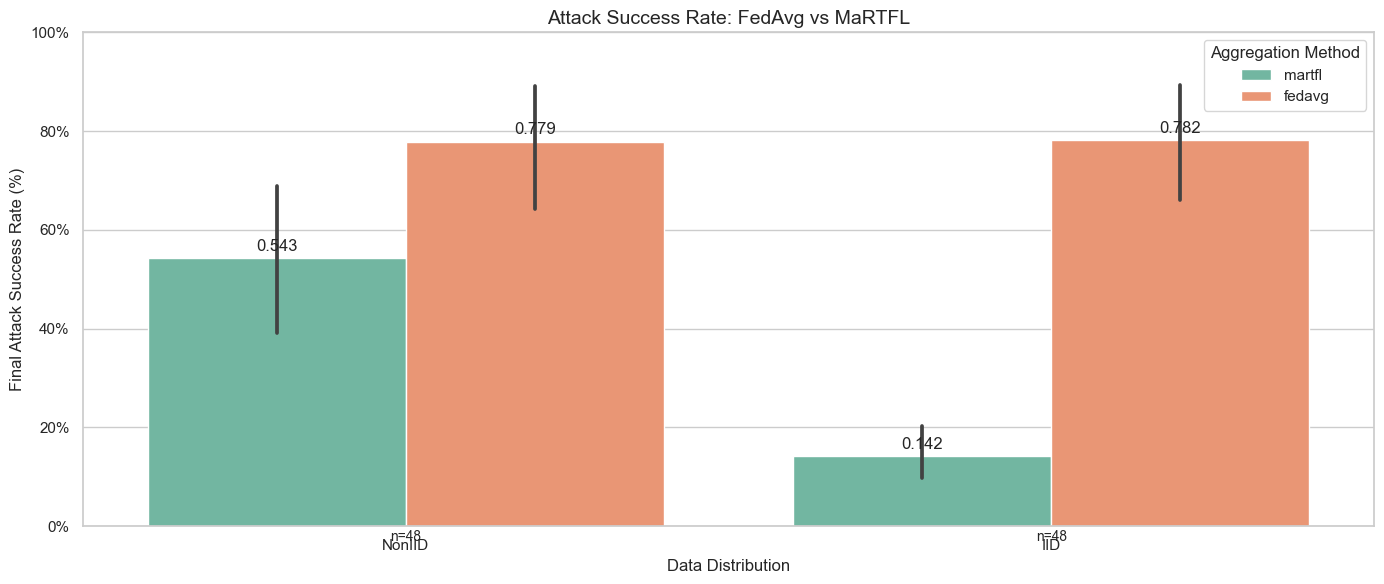

In [8]:
plot_defense_comparison(df_summary,visial_save_path)

2. Impact of Adversary Ratio

In [8]:
def plot_adversary_ratio_impact(results_df, save_path):
    plt.figure(figsize=(15, 8))
    
    # Create plot with multiple panels
    g = sns.FacetGrid(
        results_df, 
        col='IID', 
        row='IS_SYBIL',
        height=3.5, 
        aspect=1.2,
        sharex=True,
        sharey=True
    )
    
    # Map data to plot
    g.map_dataframe(
        sns.lineplot, 
        x='ADV_RATE', 
        y='FINAL_ASR', 
        hue='AGGREGATION_METHOD',
        marker='o',
        palette=COLOR_PALETTE
    )
    
    # Customize appearance
    g.set_axis_labels('Adversary Ratio', 'Attack Success Rate')
    g.set_titles('Data: {col_name} | Sybil: {row_name}')
    g.add_legend(title='Aggregation Method')
    g.set(ylim=(0, 1))
    
    # Add horizontal gridlines
    for ax in g.axes.flat:
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/adversary_ratio_impact.png', dpi=300)
    plt.show()

In [9]:
def plot_adversary_ratio_impact(results_df, save_path):
    plt.figure(figsize=(15, 8))
    
    # Create plot with multiple panels
    g = sns.FacetGrid(
        results_df, 
        col='IID', 
        row='IS_SYBIL',
        height=3.5, 
        aspect=1.2,
        sharex=True,
        sharey=True,
        margin_titles=True
    )
    
    # Map data to plot with error bands
    g.map_dataframe(
        sns.lineplot, 
        x='ADV_RATE', 
        y='FINAL_ASR', 
        hue='AGGREGATION_METHOD',
        marker='o',
        markersize=8,
        linewidth=2.5,
        palette=COLOR_PALETTE,
        errorbar=('ci', 95),
        err_style='band'
    )
    
    # Format y-axis as percentage
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
        # Add horizontal gridlines
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add data points explicitly
        for line in ax.lines:
            if line.get_marker() != 'None':
                x_data = line.get_xdata()
                y_data = line.get_ydata()
                # Add value labels at each data point
                for x, y in zip(x_data, y_data):
                    ax.text(x, y+0.03, f'{y:.2f}', ha='center', va='bottom', 
                           fontsize=8, alpha=0.8)
    
    # Calculate and add improvement metrics at key adversary ratios
    threshold_adv_rate = 0.3  # Example threshold to highlight
    for i, ax in enumerate(g.axes.flat):
        row_idx = i // len(results_df['IID'].unique())
        col_idx = i % len(results_df['IID'].unique())
        
        current_iid = results_df['IID'].unique()[col_idx]
        current_sybil = results_df['IS_SYBIL'].unique()[row_idx]
        
        # Filter data for this subplot
        subplot_data = results_df[
            (results_df['IID'] == current_iid) & 
            (results_df['IS_SYBIL'] == current_sybil)
        ]
        
        # Get data for a specific adversary ratio
        threshold_data = subplot_data[subplot_data['ADV_RATE'] == threshold_adv_rate]
        
        if not threshold_data.empty:
            # Group by aggregation method
            grouped = threshold_data.groupby('AGGREGATION_METHOD')['FINAL_ASR'].mean()
            
            # Find aggregation methods
            methods = list(grouped.index)
            if len(methods) >= 2:  # Need at least two methods to compare
                # Calculate improvement
                method1_asr = grouped[methods[0]]
                method2_asr = grouped[methods[1]]
                
                if method1_asr > 0:  # Avoid division by zero
                    rel_improvement = ((method1_asr - method2_asr) / method1_asr) * 100
                    
                    # Add annotation
                    ax.annotate(
                        f"↓{rel_improvement:.1f}%",
                        xy=(threshold_adv_rate, (method1_asr + method2_asr)/2),
                        xytext=(threshold_adv_rate+0.05, (method1_asr + method2_asr)/2),
                        arrowprops=dict(arrowstyle="->", color='red', lw=1.5),
                        color='red',
                        fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7)
                    )
    
    # # Add "Critical threshold" vertical line at key adversary ratio
    # for ax in g.axes.flat:
    #     ax.axvline(x=threshold_adv_rate, color='red', linestyle='--', alpha=0.5)
    #     ax.text(threshold_adv_rate, 0.02, "Critical\nthreshold", 
    #            rotation=90, va='bottom', ha='right', color='red', fontsize=9)
    
    # Customize appearance
    g.set_axis_labels('Adversary Ratio (%)', 'Attack Success Rate (%)')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')
    
    # Add row and column labels
    g.fig.text(0.02, 0.5, 'Sybil Attack', va='center', rotation=90, fontsize=14, fontweight='bold')
    g.fig.text(0.5, 0.02, 'Data Distribution Type', ha='center', fontsize=14, fontweight='bold')
    
    # Improve legend
    g.add_legend(title='Aggregation Method', frameon=True)
    
    # Add overall title
    g.fig.suptitle('Impact of Adversary Ratio on Attack Success Rate', 
                  fontsize=16, y=1.02, fontweight='bold')
    
    # Add descriptive subtitle
    # plt.figtext(0.5, 0.01, 
    #            "Lower values indicate better defense against attacks. Critical threshold shown at 30% adversary ratio.", 
    #            ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/adversary_ratio_impact.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{save_path}/adversary_ratio_impact.pdf', format='pdf', bbox_inches='tight')
    
    return g

C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


<Figure size 1500x800 with 0 Axes>

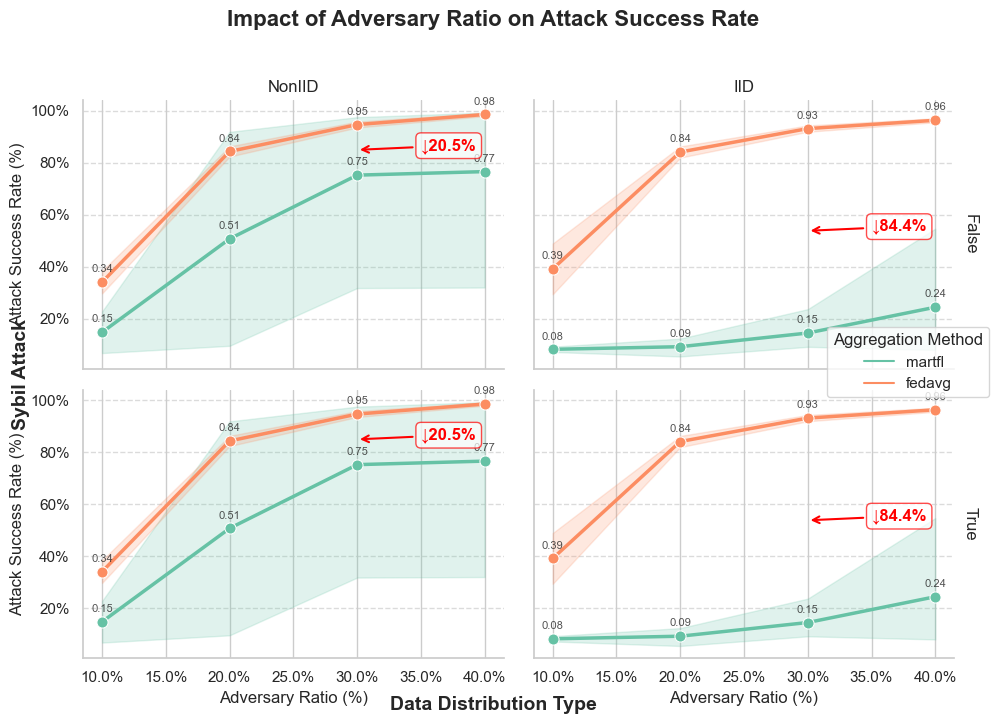

In [10]:
plot_adversary_ratio_impact(df_summary, visial_save_path)

3. Sybil vs Non-Sybil Comparison

In [15]:
def plot_sybil_comparison(results_df, save_path):
    plt.figure(figsize=(12, 6))
    
    # Create plot
    sns.barplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='FINAL_ASR',
        hue='IS_SYBIL',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE
    )
    
    # Add labels and title
    plt.xlabel('Aggregation Method')
    plt.ylabel('Final Attack Success Rate')
    plt.title('Sybil vs Non-Sybil Attack Effectiveness', fontsize=14)
    plt.ylim(0, 1)
    plt.legend(title='Sybil Attack')
    
    # Split by data distribution
    facet = sns.FacetGrid(
        results_df, 
        col='IID',
        height=4, 
        aspect=1.1
    )
    
    facet.map(
        sns.barplot, 
        'AGGREGATION_METHOD', 
        'FINAL_ASR', 
        'IS_SYBIL',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE
    )
    
    facet.add_legend(title='Sybil Attack')
    facet.set_axis_labels('Aggregation Method', 'Attack Success Rate')
    facet.set_titles('Data: {col_name}')
    facet.set(ylim=(0, 1))
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/sybil_comparison.png', dpi=300)
    plt.show()

C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


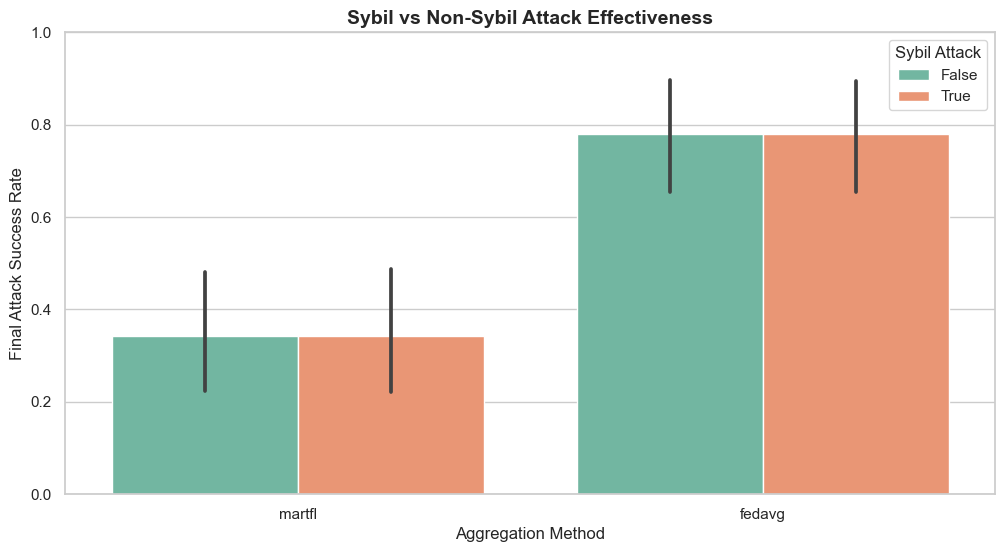

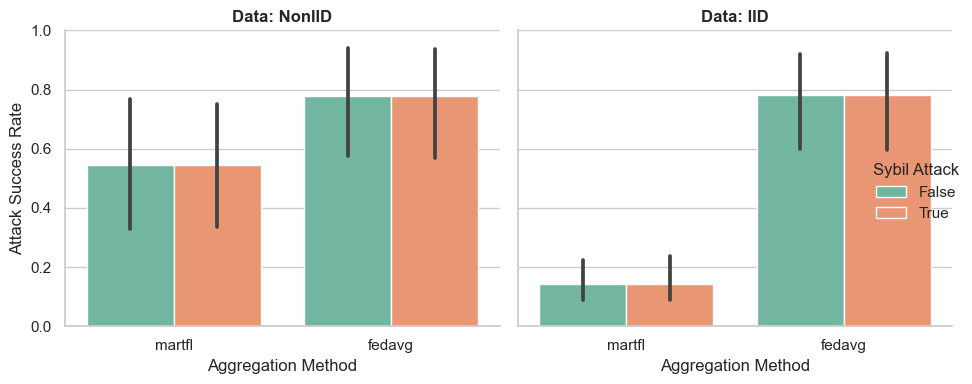

In [16]:
plot_sybil_comparison(df_summary, visial_save_path)

In [10]:
def plot_attack_efficiency(results_df, visial_save_path):
    plt.figure(figsize=(14, 6))
    
    # Create grouped boxplot
    sns.boxplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='ASR_PER_ADV',
        hue='IS_SYBIL',
        palette=COLOR_PALETTE
    )
    
    # Add individual points
    sns.stripplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='ASR_PER_ADV',
        hue='IS_SYBIL',
        dodge=True,
        size=4,
        color='black',
        alpha=0.4
    )
    
    # Add labels and title
    plt.xlabel('Aggregation Method')
    plt.ylabel('ASR per Adversary')
    plt.title('Attack Efficiency: ASR per Adversary', fontsize=14)
    
    # Fix legend (remove duplicate)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Sybil Attack')
    
    plt.tight_layout()
    plt.savefig(f'{visial_save_path}/attack_efficiency.png', dpi=300)
    plt.show()

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.ticker as mtick
from scipy import stats

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})
visual_save_path = "./visualization"
Path(visual_save_path).mkdir(parents=True, exist_ok=True)

# Consistent colors
COLOR_PALETTE = sns.color_palette("Set2")

def plot_attack_efficiency(results_df, save_path):
    plt.figure(figsize=(14, 6))
    
    # Create grouped boxplot with better styling
    ax = sns.boxplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='ASR_PER_ADV',
        hue='IS_SYBIL',
        palette=COLOR_PALETTE,
        width=0.6,
        fliersize=0,  # Hide outliers (will be shown in stripplot)
        linewidth=1.2
    )
    
    # Add individual points with better styling
    sns.stripplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='ASR_PER_ADV',
        hue='IS_SYBIL',
        dodge=True,
        size=5,
        edgecolor='gray',
        linewidth=0.5,
        alpha=0.6,
        palette=['black', 'black'],
        marker='o',
        jitter=0.2
    )
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Add mean values as text above each box
    # First get positions of boxes
    num_boxes = len(results_df['AGGREGATION_METHOD'].unique()) * len(results_df['IS_SYBIL'].unique())
    positions = np.arange(num_boxes)
    box_width = 0.6
    
    # Calculate means and add text
    for i, (name, group) in enumerate(results_df.groupby(['AGGREGATION_METHOD', 'IS_SYBIL'])):
        mean_val = group['ASR_PER_ADV'].mean()
        pos = positions[i] 
        
        # Calculate position adjustment based on boxplot position
        agg_idx = list(results_df['AGGREGATION_METHOD'].unique()).index(name[0])
        sybil_idx = list(results_df['IS_SYBIL'].unique()).index(name[1])
        
        # Adjust position for the grouped boxes
        pos = agg_idx + (sybil_idx - 0.5) * (box_width / 2)
        
        plt.text(pos, mean_val + 0.03, f'μ={mean_val:.3f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Add statistical significance markers
    # Group data by aggregation method and sybil attack status
    groups = []
    for method in results_df['AGGREGATION_METHOD'].unique():
        for sybil in results_df['IS_SYBIL'].unique():
            group_data = results_df[(results_df['AGGREGATION_METHOD'] == method) & 
                                   (results_df['IS_SYBIL'] == sybil)]['ASR_PER_ADV']
            groups.append((method, sybil, group_data))
    
    # Add horizontal significance bars between relevant pairs
    y_max = results_df['ASR_PER_ADV'].max()
    y_offset = y_max * 0.05  # 5% of max for spacing
    
    # Compare same Sybil status across different aggregation methods
    for sybil in results_df['IS_SYBIL'].unique():
        methods = results_df['AGGREGATION_METHOD'].unique()
        for i in range(len(methods)-1):
            for j in range(i+1, len(methods)):
                # Get data for the pair to compare
                data1 = results_df[(results_df['AGGREGATION_METHOD'] == methods[i]) & 
                                  (results_df['IS_SYBIL'] == sybil)]['ASR_PER_ADV']
                data2 = results_df[(results_df['AGGREGATION_METHOD'] == methods[j]) & 
                                  (results_df['IS_SYBIL'] == sybil)]['ASR_PER_ADV']
                
                # Perform t-test
                t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                
                # Determine significance marker
                if p_val < 0.001:
                    sig_marker = '***'
                elif p_val < 0.01:
                    sig_marker = '**'
                elif p_val < 0.05:
                    sig_marker = '*'
                else:
                    continue  # Skip if not significant
                
                # Determine positions and heights for the significance bar
                x1 = i
                x2 = j
                if sybil:
                    x1 += 0.25
                    x2 += 0.25
                else:
                    x1 -= 0.25
                    x2 -= 0.25
                
                bar_height = y_max + y_offset * (1 + (i+j) % 3)  # Stagger heights for visibility
                
                # Draw the bar and marker
                plt.plot([x1, x1, x2, x2], 
                        [bar_height-y_offset*0.5, bar_height, bar_height, bar_height-y_offset*0.5],
                        linewidth=1, color='black')
                plt.text((x1+x2)/2, bar_height+y_offset*0.1, sig_marker, ha='center', va='bottom')
    
    # Add efficiency improvement percentage for each pair
    for method in results_df['AGGREGATION_METHOD'].unique():
        # Get data for Sybil and non-Sybil for this method
        non_sybil_data = results_df[(results_df['AGGREGATION_METHOD'] == method) & 
                                  (~results_df['IS_SYBIL'])]['ASR_PER_ADV']
        sybil_data = results_df[(results_df['AGGREGATION_METHOD'] == method) & 
                               (results_df['IS_SYBIL'])]['ASR_PER_ADV']
        
        # Calculate means
        non_sybil_mean = non_sybil_data.mean()
        sybil_mean = sybil_data.mean()
        
        # Calculate relative improvement
        if non_sybil_mean > 0:  # Avoid division by zero
            rel_improvement = ((sybil_mean - non_sybil_mean) / non_sybil_mean) * 100
            
            # Get x-position
            method_idx = list(results_df['AGGREGATION_METHOD'].unique()).index(method)
            
            # Determine label color based on improvement direction
            color = 'green' if rel_improvement < 0 else 'red'
            arrow = '↓' if rel_improvement < 0 else '↑'
            
            # Add annotation
            plt.annotate(
                f"{arrow}{abs(rel_improvement):.1f}%",
                xy=(method_idx, (non_sybil_mean + sybil_mean) / 2),
                xytext=(method_idx + 0.4, (non_sybil_mean + sybil_mean) / 2),
                arrowprops=dict(arrowstyle="-|>", color=color, lw=1.5),
                color=color,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.7)
            )
    
    # Add mean values for groups as a table
    rows = []
    for method in results_df['AGGREGATION_METHOD'].unique():
        row = [method]
        for sybil in [False, True]:
            group_data = results_df[(results_df['AGGREGATION_METHOD'] == method) & 
                                   (results_df['IS_SYBIL'] == sybil)]['ASR_PER_ADV']
            row.append(f"{group_data.mean():.3f} ± {group_data.std():.3f}")
        rows.append(row)
    
    # Create a table at the bottom of the plot
    table = plt.table(
        cellText=rows,
        colLabels=['Method', 'Non-Sybil (mean ± std)', 'Sybil (mean ± std)'],
        loc='bottom',
        cellLoc='center',
        bbox=[0, -0.35, 1, 0.2]  # [left, bottom, width, height]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # Adjust figure for table
    plt.subplots_adjust(bottom=0.25)
    
    # Add labels and title
    plt.xlabel('Aggregation Method', labelpad=50)  # Add padding for the table
    plt.ylabel('ASR per Adversary (%)')
    plt.title('Attack Efficiency: ASR per Adversary', fontsize=14, pad=20)
    
    # Add a subtitle explaining the metric
    plt.figtext(0.5, 0.02, 
               "ASR per Adversary measures how effective each adversarial client is.\n"
               "Lower values indicate less efficient attacks (better defense).",
               ha='center', fontsize=10, style='italic')
    
    # Fix legend (remove duplicate and improve appearance)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], ['Non-Sybil', 'Sybil'], 
               title='Attack Type', 
               frameon=True,
               edgecolor='black')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust for the subtitle
    plt.savefig(f'{save_path}/attack_efficiency.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{save_path}/attack_efficiency.pdf', format='pdf', bbox_inches='tight')
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\zeyu song\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

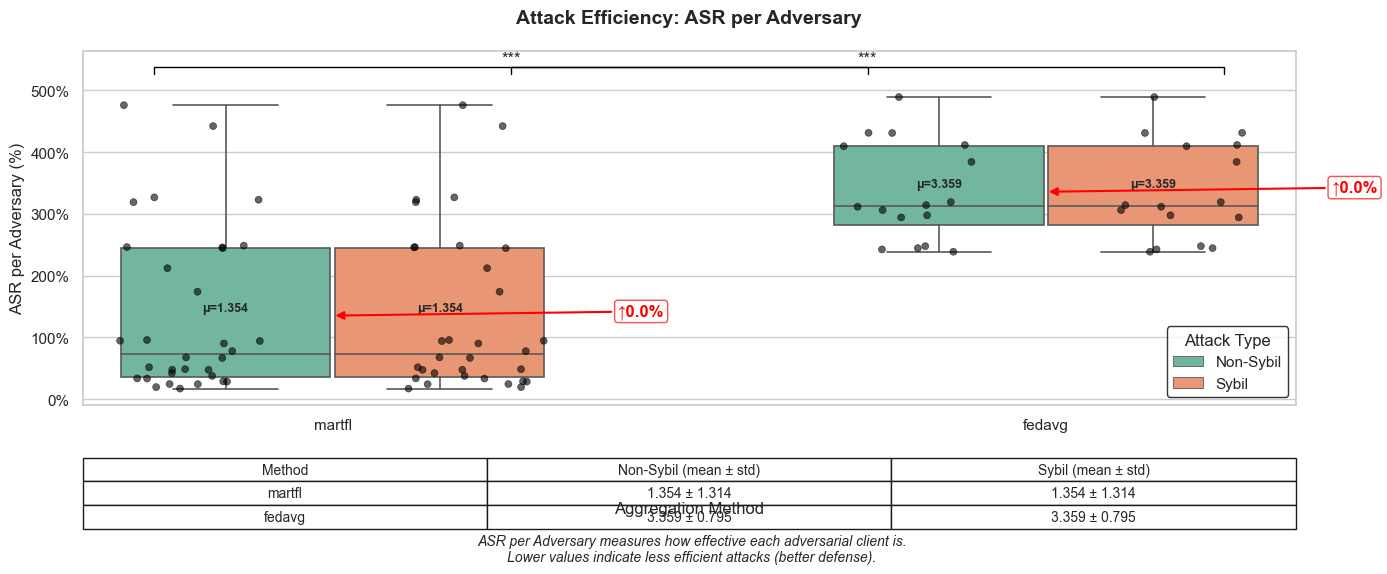

In [21]:
plot_attack_efficiency(df_summary, visial_save_path)

5. Rounds to Reach ASR Thresholds

In [22]:
def plot_rounds_to_threshold(results_df,visial_save_path):
    # Replace -1 (never reached) with max rounds + some padding for visualization
    max_rounds = results_df['TOTAL_ROUNDS'].max()
    results_df_plot = results_df.copy()
    
    for col in ['ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ROUNDS_TO_90PCT_ASR']:
        results_df_plot[col] = results_df_plot[col].replace(-1, max_rounds * 1.2)
    
    # Melt the dataframe for easier plotting
    plot_df = pd.melt(
        results_df_plot, 
        id_vars=['AGGREGATION_METHOD', 'IS_SYBIL', 'IID', 'ADV_RATE'],
        value_vars=['ROUNDS_TO_50PCT_ASR', 'ROUNDS_TO_75PCT_ASR', 'ROUNDS_TO_90PCT_ASR'],
        var_name='Threshold', 
        value_name='Rounds'
    )
    
    # Map threshold names to more readable labels
    threshold_mapping = {
        'ROUNDS_TO_50PCT_ASR': '50% ASR', 
        'ROUNDS_TO_75PCT_ASR': '75% ASR', 
        'ROUNDS_TO_90PCT_ASR': '90% ASR'
    }
    plot_df['Threshold'] = plot_df['Threshold'].map(threshold_mapping)
    
    # Create plot
    plt.figure(figsize=(16, 8))
    g = sns.FacetGrid(
        plot_df, 
        col='IID',
        row='IS_SYBIL',
        height=3.5, 
        aspect=1.2
    )
    
    g.map_dataframe(
        sns.barplot, 
        x='Threshold', 
        y='Rounds', 
        hue='AGGREGATION_METHOD',
        palette=COLOR_PALETTE
    )
    
    g.set_axis_labels('ASR Threshold', 'Training Rounds')
    g.set_titles('Data: {col_name} | Sybil: {row_name}')
    g.add_legend(title='Aggregation Method')
    
    # Add a horizontal line at max_rounds
    for ax in g.axes.flat:
        ax.axhline(y=max_rounds, color='red', linestyle='--', alpha=0.5)
        ax.text(
            0.5, max_rounds + 1, 
            'Never Reached', 
            color='red', alpha=0.7, 
            ha='center'
        )
    
    plt.tight_layout()
    plt.savefig(f'{visial_save_path}/rounds_to_threshold.png', dpi=300)
    plt.show()

C:\Users\pc\Desktop\code\poison_data_valuation\venv_310\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\pc\Desktop\code\poison_data_valuation\venv_310\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\pc\Desktop\code\poison_data_valuation\venv_310\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\pc\Desktop\code\poison_data_valuation\venv_310\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


<Figure size 1600x800 with 0 Axes>

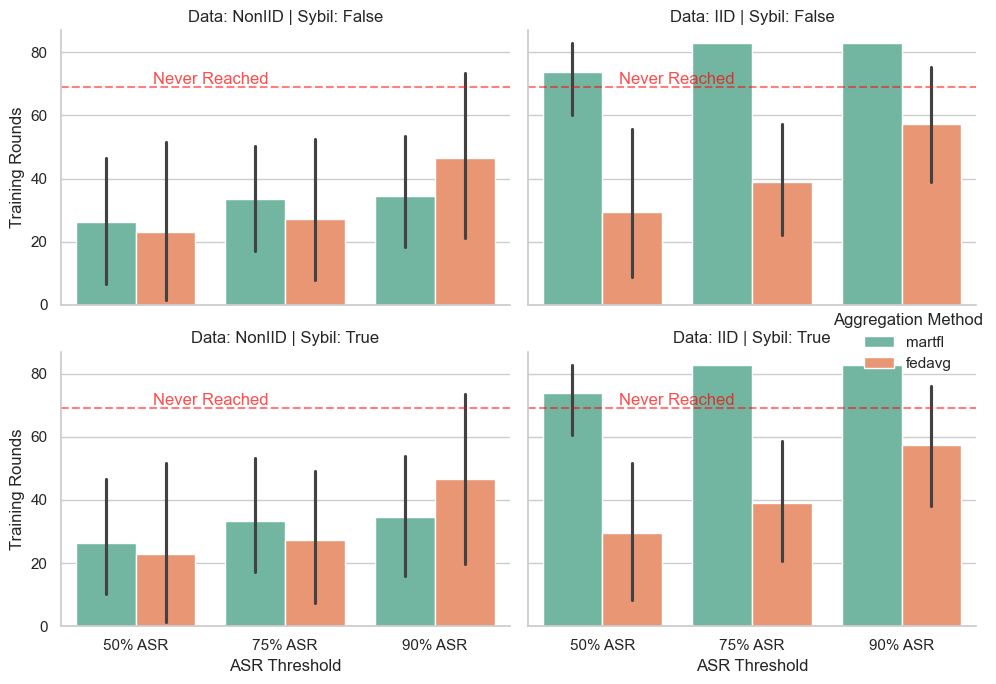

In [13]:
plot_rounds_to_threshold(df_summary,visial_save_path)

6. Stealth vs Effectiveness Trade-off

In [14]:
def plot_stealth_vs_effectiveness(results_df,visial_save_path):
    plt.figure(figsize=(10, 8))
    
    # Create scatterplot
    g = sns.scatterplot(
        data=results_df,
        x='STEALTH',
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        style='IS_SYBIL',
        size='ADV_RATE',
        sizes=(50, 200),
        alpha=0.7,
        palette=COLOR_PALETTE
    )
    
    # Add labels and title
    plt.xlabel('Stealth (1 - |Accuracy Difference|)')
    plt.ylabel('Attack Success Rate')
    plt.title('Stealth vs Effectiveness Trade-off', fontsize=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add reference lines
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=0.8, color='gray', linestyle=':', alpha=0.5)
    
    # Add reference regions
    plt.text(0.05, 0.95, "Detected\nIneffective", ha='left', alpha=0.7)
    plt.text(0.85, 0.95, "Stealthy\nEffective", ha='right', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{visial_save_path}/stealth_vs_effectiveness.png', dpi=300)
    plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_12224\2241765772.py:5: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.scatterplot(


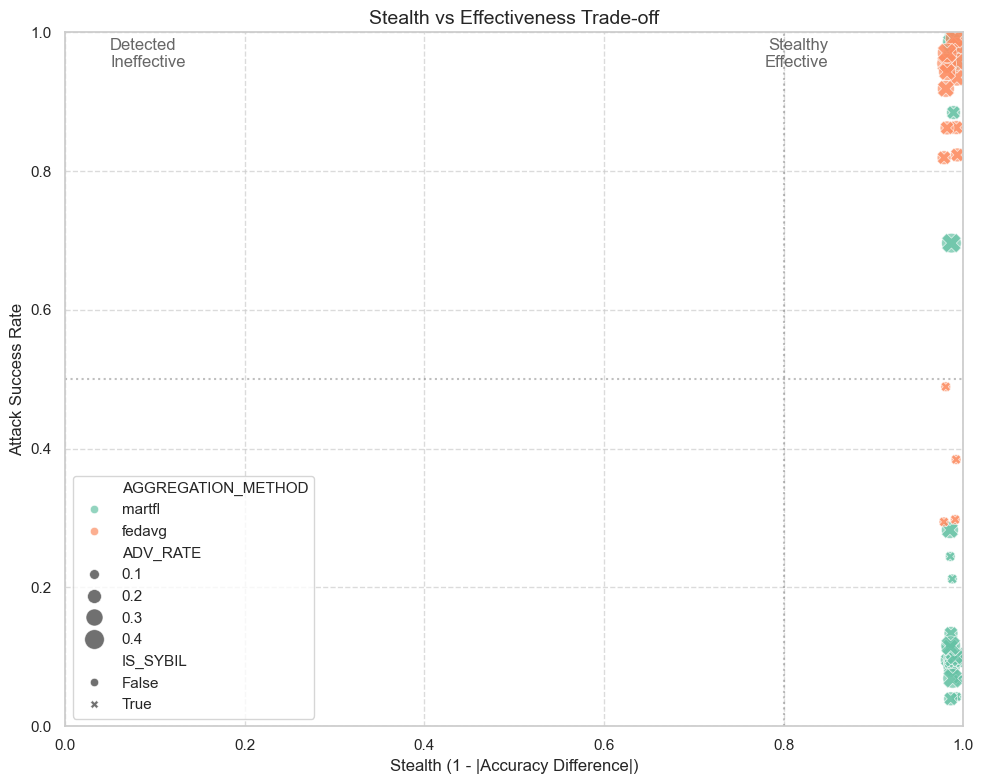

In [15]:
plot_stealth_vs_effectiveness(df_summary,visial_save_path)

7. Clean Accuracy Impact

In [23]:
def plot_clean_accuracy_impact(results_df,visial_save_path):
    plt.figure(figsize=(12, 6))
    
    # Create plot
    sns.boxplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='FINAL_CLEAN_ACC',
        hue='IS_SYBIL',
        palette=COLOR_PALETTE
    )
    
    # Add labels and title
    plt.xlabel('Aggregation Method')
    plt.ylabel('Final Clean Accuracy')
    plt.title('Impact on Clean Accuracy', fontsize=14)
    
    # Set y-axis limits appropriate for accuracy
    plt.ylim(0, 1)
    
    # Add horizontal line for reference accuracy (you'll need to determine this value)
    # plt.axhline(y=reference_accuracy, color='red', linestyle='--', label='No Attack Reference')
    
    plt.legend(title='Sybil Attack')
    plt.tight_layout()
    plt.savefig(f'{visial_save_path}/clean_accuracy_impact.png', dpi=300)
    plt.show()

In [29]:
def plot_clean_accuracy_impact(results_df, save_path, reference_accuracy=0.9):
    plt.figure(figsize=(12, 6))
    
    # Create plot
    ax = sns.boxplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='FINAL_CLEAN_ACC',
        hue='IS_SYBIL',
        palette=COLOR_PALETTE
    )
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Add labels and title
    plt.xlabel('Aggregation Method')
    plt.ylabel('Final Clean Accuracy (%)')
    plt.title('Impact on Clean Accuracy', fontsize=14)
    
    # Set y-axis limits appropriate for accuracy
    # Start from 0.7 to better show differences in the relevant range
    plt.ylim(0.7, 1)
    
    # Add horizontal line for reference accuracy
    plt.axhline(y=reference_accuracy, color='red', linestyle='--', 
               label='No Attack Reference (90%)')
    
    # Add mean values on top of each box
    for i, method in enumerate(results_df['AGGREGATION_METHOD'].unique()):
        for j, sybil in enumerate([False, True]):
            # Get the subset of data
            subset = results_df[(results_df['AGGREGATION_METHOD'] == method) & 
                               (results_df['IS_SYBIL'] == sybil)]
            
            # Calculate mean
            mean_acc = subset['FINAL_CLEAN_ACC'].mean()
            
            # Position for the text (adjusted for hue)
            pos = i + (j-0.5)*0.35
            
            # Add text with accuracy value
            plt.text(pos, mean_acc + 0.02, f'{mean_acc:.3f}', 
                    ha='center', va='bottom', fontsize=10)
    
    # Fix legend to correctly use the color palette
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a proper legend with the correct colors
    plt.legend(handles[:2], ['Non-Sybil', 'Sybil'], title='Sybil Attack')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/clean_accuracy_impact.png', dpi=300)
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\zeyu song\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

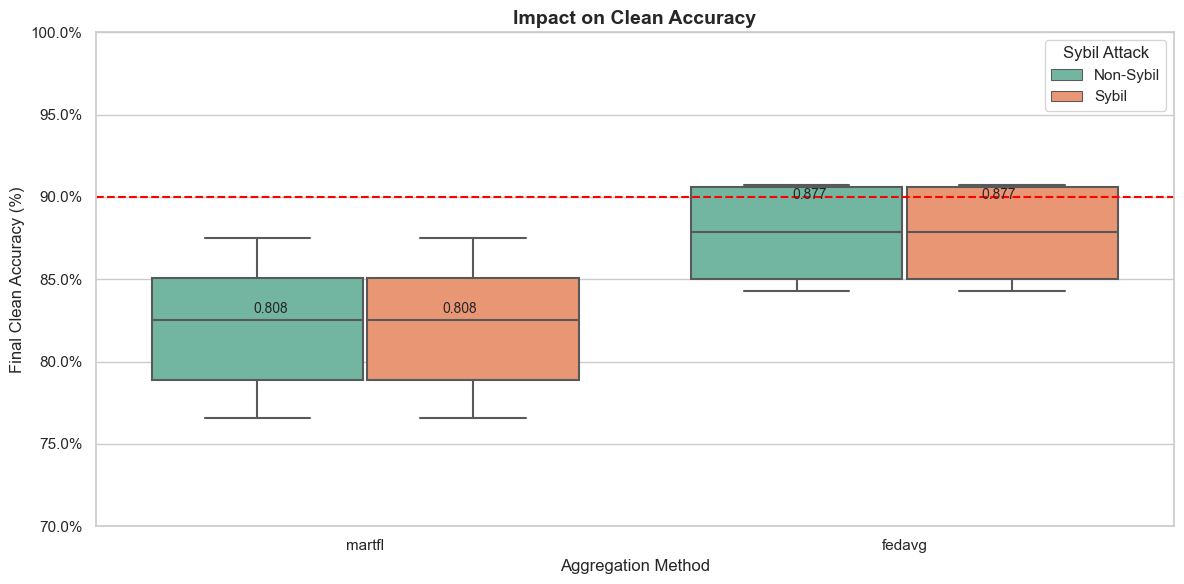

In [30]:
plot_clean_accuracy_impact(df_summary,visial_save_path)

8. Selection Rate Analysis (MaRTFL specific)

In [31]:
def plot_selection_rates(results_df,visial_save_path):
    # Filter for only MaRTFL results
    martfl_df = results_df[results_df['AGGREGATION_METHOD'] == 'martfl']
    
    plt.figure(figsize=(12, 10))
    
    # Create the scatter plot
    g = sns.FacetGrid(
        martfl_df, 
        col='IID',
        row='IS_SYBIL',
        height=4, 
        aspect=1.1
    )
    
    g.map_dataframe(
        sns.scatterplot,
        x='AVG_BENIGN_RATE',
        y='AVG_MALICIOUS_RATE',
        hue='ADV_RATE',
        size='TRIGGER_RATE',
        sizes=(50, 200),
        palette='viridis'
    )
    
    # Add the diagonal reference line (equal selection rates)
    for ax in g.axes.flat:
        lims = [
            min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])
        ]
        ax.plot(lims, lims, 'r--', alpha=0.5, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    g.set_axis_labels('Average Benign Selection Rate', 'Average Malicious Selection Rate')
    g.set_titles('Data: {col_name} | Sybil: {row_name}')
    g.add_legend(title='Adversary Rate')
    
    plt.tight_layout()
    plt.savefig(f'{visial_save_path}/selection_rates.png', dpi=300)
    plt.show()

<Figure size 1200x1000 with 0 Axes>

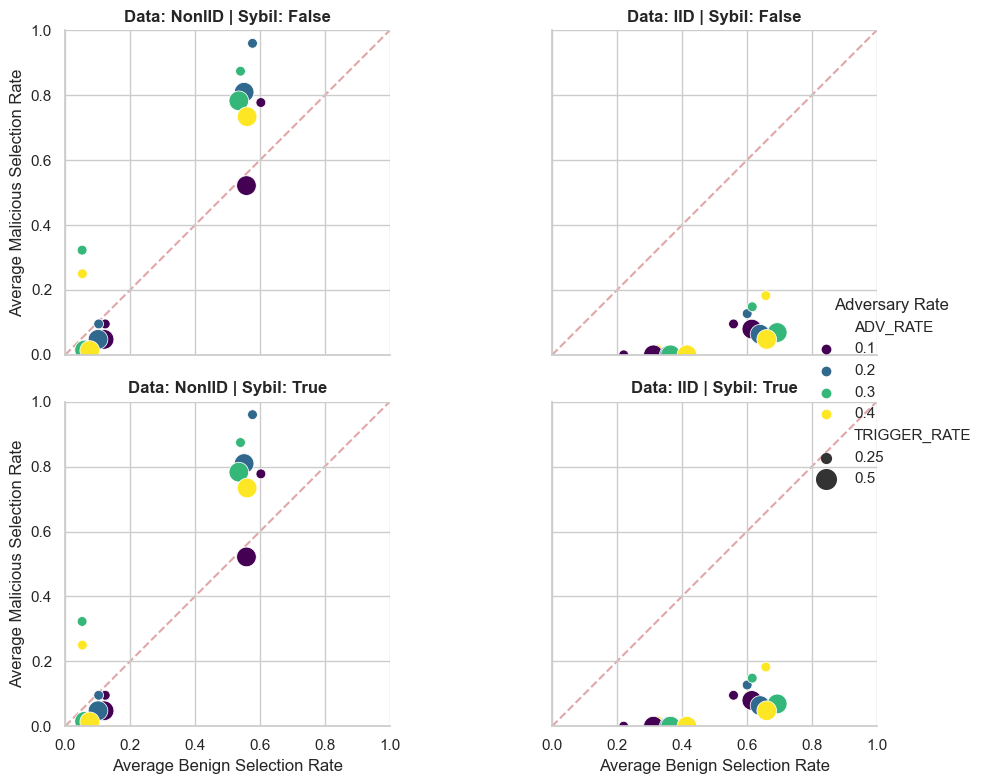

In [32]:
plot_selection_rates(df_summary,visial_save_path)

In [20]:
def plot_selection_rate_over_time(round_data_df,visial_save_path):
    # This requires the round-by-round data, not the summary statistics
    # Assuming 'round_data_df' has columns: round, malicious_rate, benign_rate, AGGREGATION_METHOD, etc.
    
    # Filter for only MaRTFL and combine similar configurations
    martfl_df = round_data_df[round_data_df['AGGREGATION_METHOD'] == 'martfl']
    
    plt.figure(figsize=(15, 10))
    
    g = sns.FacetGrid(
        martfl_df, 
        col='IID',
        row='IS_SYBIL',
        hue='ADV_RATE',
        height=4, 
        aspect=1.3,
        sharey=True
    )
    
    g.map_dataframe(
        sns.lineplot, 
        x='round', 
        y='malicious_rate',
        palette='viridis'
    )
    
    g.set_titles('Data: {col_name} | Sybil: {row_name}')
    g.set_axis_labels('Training Round', 'Malicious Client Selection Rate')
    g.add_legend(title='Adversary Rate')
    g.set(ylim=(0, 1))
    
    plt.tight_layout()
    plt.savefig(f'{visial_save_path}/selection_rate_over_time.png', dpi=300)
    plt.show()

C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` va

<Figure size 1500x1000 with 0 Axes>

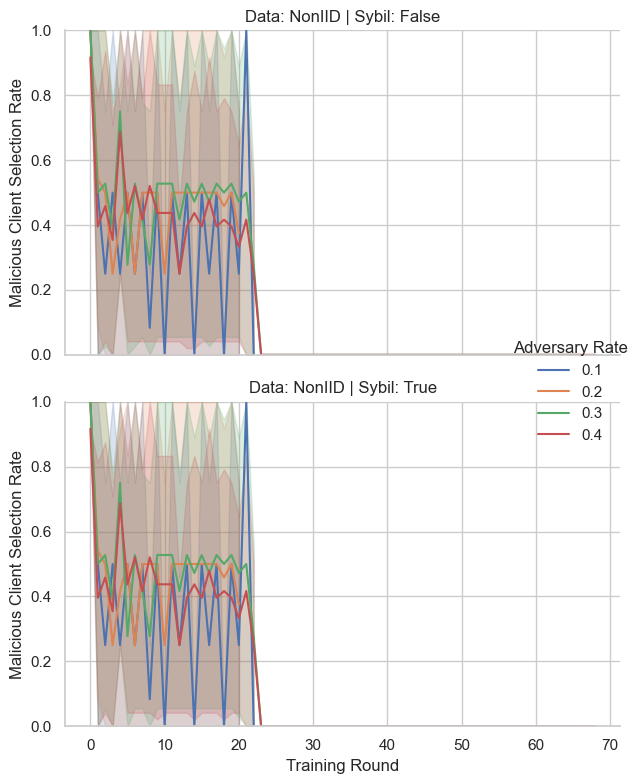

In [37]:
plot_selection_rate_over_time(df_round,visial_save_path)

trigger rate impact

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_trigger_rate_impact(results_df, output_dir="./visualizations", 
                            color_palette="viridis", filename="trigger_rate_impact"):
    """
    Create an enhanced visualization of trigger rate impact on attack success rate,
    separated by aggregation method, adversary rate, and IID/non-IID settings.
    
    Args:
        results_df: DataFrame containing the results
        output_dir: Directory to save the output visualization
        color_palette: Color palette to use for the plot
        filename: Base filename for the saved figure
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Verify required columns exist
    required_cols = ['ADV_RATE', 'FINAL_ASR', 'TRIGGER_RATE', 'AGGREGATION_METHOD', 'IID']
    missing_cols = [col for col in required_cols if col not in results_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Create figure with appropriate size
    plt.figure(figsize=(16, 10))
    
    # Create plot with improved aesthetics
    g = sns.catplot(
        data=results_df, 
        x='ADV_RATE', 
        y='FINAL_ASR',
        hue='TRIGGER_RATE',
        col='AGGREGATION_METHOD',
        row='IID',
        kind='bar',
        height=4.5,
        aspect=1.2,
        palette=color_palette,
        errwidth=1.5,
        capsize=0.05,
        legend_out=False,
        dodge=True
    )
    
    # Enhance labels and titles
    g.set_axis_labels('Adversary Rate', 'Attack Success Rate (ASR)')
    
    # Improve subplot titles with clearer labeling
    g.set_titles('{row_name} Distribution | {col_name}')
    
    # Replace boolean values with readable strings in row titles if needed
    if all(isinstance(x, bool) for x in results_df['IID'].unique()):
        row_titles = {True: 'IID', False: 'Non-IID'}
        for ax, row_val in zip(g.axes, g._row_var.categories):
            for col_idx in range(len(g.axes[0])):
                title = ax[col_idx].get_title()
                ax[col_idx].set_title(title.replace(str(row_val), row_titles.get(row_val, str(row_val))))
                
    # Customize appearance
    g.set(ylim=(0, 1.05))  # Add a bit of padding above 1.0
    
    # Add horizontal grid lines for better readability
    for ax_row in g.axes:
        for ax in ax_row:
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add value annotations on bars
            for p in ax.patches:
                height = p.get_height()
                if not np.isnan(height):  # Skip annotation if height is NaN
                    ax.text(
                        p.get_x() + p.get_width()/2,
                        height + 0.02,
                        f'{height:.2f}',
                        ha='center',
                        fontsize=9,
                        fontweight='bold'
                    )
    
    # Add a more descriptive legend
    g.add_legend(title='Trigger Rate', frameon=True)
    
    # Add an overall title
    g.fig.suptitle('Impact of Trigger Rate on Attack Success Rate', 
                   fontsize=16, fontweight='bold', y=1.02)
    
    # Add footer with summary statistics
    # Calculate mean ASR by trigger rate
    summary_stats = results_df.groupby('TRIGGER_RATE')['FINAL_ASR'].mean().round(3)
    stats_text = "Average ASR by Trigger Rate: " + ", ".join([f"{rate}: {asr}" for rate, asr in summary_stats.items()])
    plt.figtext(0.5, -0.02, stats_text, ha='center', fontsize=10, 
                bbox=dict(facecolor='lightyellow', alpha=0.5, boxstyle='round,pad=0.5'))
                
    # Customize spacing
    plt.tight_layout()
    
    # Save with high resolution and in multiple formats
    plot_path = os.path.join(output_dir, f"{filename}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(output_dir, f"{filename}.pdf"), format='pdf', bbox_inches='tight')
    
    print(f"Plot saved to {plot_path}")
    plt.show()
    
    # Generate a secondary plot focusing on the difference between trigger rates
    plt.figure(figsize=(10, 6))
    
    # Pivot data to analyze trigger rate effect
    pivot_columns = ['AGGREGATION_METHOD', 'ADV_RATE', 'IID']
    if set(pivot_columns).issubset(results_df.columns):
        try:
            # Group by all factors except trigger rate
            grouped = results_df.groupby(pivot_columns + ['TRIGGER_RATE'])['FINAL_ASR'].mean().reset_index()
            
            # For trigger rates that appear multiple times, compute spread
            trigger_rates = sorted(grouped['TRIGGER_RATE'].unique())
            if len(trigger_rates) > 1:
                # Get min and max trigger rates
                min_rate = min(trigger_rates)
                max_rate = max(trigger_rates)
                
                # Create a new DataFrame to analyze the difference
                agg_data = []
                for _, group in grouped.groupby(pivot_columns):
                    min_asr = group[group['TRIGGER_RATE'] == min_rate]['FINAL_ASR'].values[0]
                    max_asr = group[group['TRIGGER_RATE'] == max_rate]['FINAL_ASR'].values[0]
                    
                    # Extract group info
                    group_dict = {col: group[col].iloc[0] for col in pivot_columns}
                    
                    agg_data.append({
                        **group_dict,
                        'ASR_Difference': max_asr - min_asr,
                        'Relative_Improvement': (max_asr - min_asr) / min_asr if min_asr > 0 else np.nan
                    })
                
                diff_df = pd.DataFrame(agg_data)
                
                # Plot the difference
                sns.barplot(
                    data=diff_df,
                    x='ADV_RATE',
                    y='ASR_Difference',
                    hue='AGGREGATION_METHOD',
                    palette=color_palette
                )
                
                plt.title(f'ASR Improvement: Trigger Rate {min_rate} → {max_rate}', fontsize=14)
                plt.xlabel('Adversary Rate')
                plt.ylabel('ASR Improvement (absolute)')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.legend(title='Aggregation Method')
                
                # Save this additional analysis
                diff_path = os.path.join(output_dir, f"{filename}_difference.png")
                plt.tight_layout()
                plt.savefig(diff_path, dpi=300)
                print(f"Difference analysis saved to {diff_path}")
        except Exception as e:
            print(f"Could not generate difference analysis: {e}")
    
    return g  # Return the figure for further customization if needed

Plot saved to ./visualization\trigger_rate_impact.png


<Figure size 1600x1000 with 0 Axes>

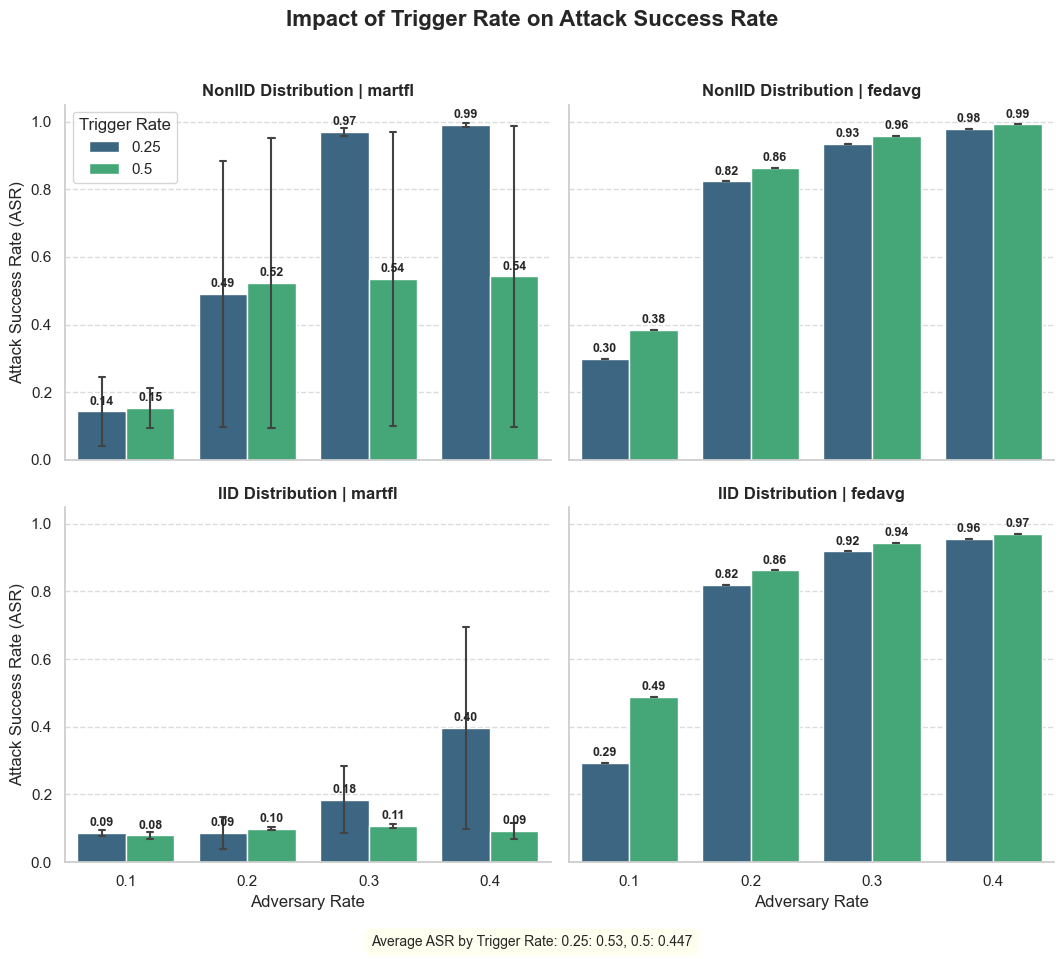

Difference analysis saved to ./visualization\trigger_rate_impact_difference.png


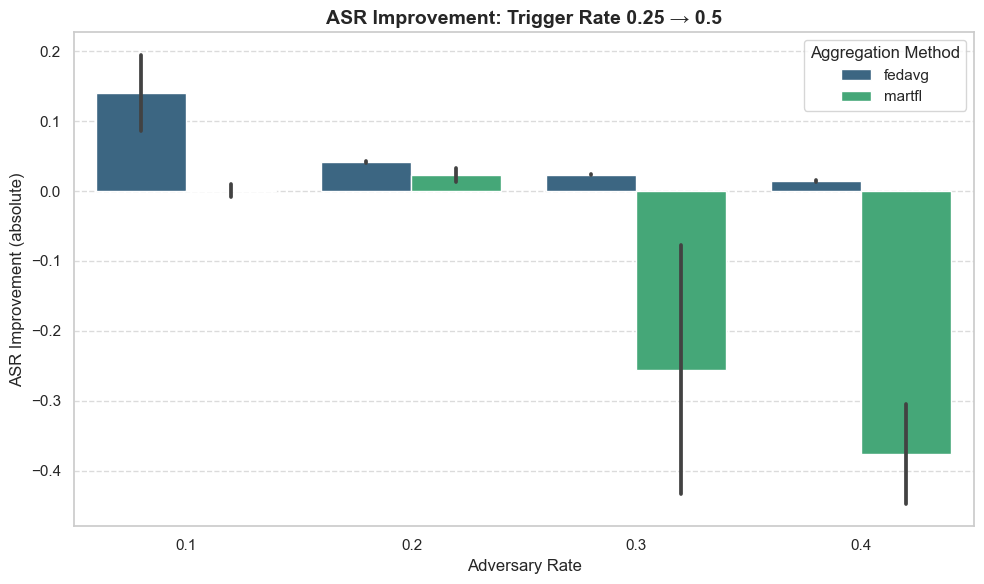

In [34]:
plot_trigger_rate_impact(results_df=df_summary, output_dir=visial_save_path)

In [35]:
def create_analysis_dashboard(results_df, visial_save_path):
    # Create a comprehensive figure with multiple subplots
    fig = plt.figure(figsize=(22, 16))
    fig.suptitle('Backdoor Attack Analysis Dashboard', fontsize=20, y=0.98)
    
    # Define grid layout
    gs = plt.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)
    
    # 1. Defense comparison (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(
        data=results_df, 
        x='AGGREGATION_METHOD', 
        y='FINAL_ASR',
        hue='DATA_SPLIT_MODE',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE,
        ax=ax1
    )
    ax1.set_title('Defense Effectiveness')
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('')
    ax1.legend(title='Data')
    
    # 2. Adversary ratio impact (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    sns.lineplot(
        data=results_df, 
        x='ADV_RATE', 
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        style='DATA_SPLIT_MODE',
        markers=True,
        palette=COLOR_PALETTE,
        ax=ax2
    )
    ax2.set_title('Impact of Adversary Ratio')
    ax2.set_ylim(0, 1)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Sybil comparison (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    sns.barplot(
        data=results_df, 
        x='IS_SYBIL', 
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE,
        ax=ax3
    )
    ax3.set_title('Sybil vs Non-Sybil')
    ax3.set_ylim(0, 1)
    ax3.set_xlabel('Sybil Attack')
    
    # 4. Attack efficiency (middle left)
    ax4 = fig.add_subplot(gs[1, 0])
    sns.boxplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='ASR_PER_ADV',
        hue='IS_SYBIL',
        palette=COLOR_PALETTE,
        ax=ax4
    )
    ax4.set_title('Attack Efficiency')
    ax4.set_xlabel('')
    
    # 5. Stealth vs effectiveness (middle middle)
    ax5 = fig.add_subplot(gs[1, 1])
    sns.scatterplot(
        data=results_df,
        x='STEALTH',
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        style='IS_SYBIL',
        size='ADV_RATE',
        sizes=(50, 200),
        alpha=0.7,
        palette=COLOR_PALETTE,
        ax=ax5
    )
    ax5.set_title('Stealth vs Effectiveness')
    ax5.set_xlim(0, 1)
    ax5.set_ylim(0, 1)
    ax5.grid(True, linestyle='--', alpha=0.7)
    
    # 6. Clean accuracy impact (middle right)
    ax6 = fig.add_subplot(gs[1, 2])
    sns.boxplot(
        data=results_df,
        x='AGGREGATION_METHOD',
        y='FINAL_CLEAN_ACC',
        hue='IS_SYBIL',
        palette=COLOR_PALETTE,
        ax=ax6
    )
    ax6.set_title('Impact on Clean Accuracy')
    ax6.set_ylim(0, 1)
    ax6.set_xlabel('')
    
    # 7. Trigger rate impact (bottom left)
    ax7 = fig.add_subplot(gs[2, 0])
    sns.barplot(
        data=results_df, 
        x='TRIGGER_RATE', 
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE,
        ax=ax7
    )
    ax7.set_title('Impact of Trigger Rate')
    ax7.set_ylim(0, 1)
    
    # 8. Data distribution impact (bottom middle)
    ax8 = fig.add_subplot(gs[2, 1])
    sns.barplot(
        data=results_df, 
        x='DATA_SPLIT_MODE', 
        y='FINAL_ASR',
        hue='AGGREGATION_METHOD',
        errorbar=('ci', 95),
        palette=COLOR_PALETTE,
        ax=ax8
    )
    ax8.set_title('Impact of Data Distribution')
    ax8.set_ylim(0, 1)
    ax8.set_xlabel('Data Distribution')
    
    # 9. Summary metrics (bottom right)
    ax9 = fig.add_subplot(gs[2, 2])
    martfl_improvement = (results_df[results_df['AGGREGATION_METHOD'] == 'fedavg']['FINAL_ASR'].mean() - 
                         results_df[results_df['AGGREGATION_METHOD'] == 'martfl']['FINAL_ASR'].mean())
    
    textstr = '\n'.join((
        'Summary Metrics:',
        f'Average FedAvg ASR: {results_df[results_df["AGGREGATION_METHOD"] == "fedavg"]["FINAL_ASR"].mean():.2f}',
        f'Average MaRTFL ASR: {results_df[results_df["AGGREGATION_METHOD"] == "martfl"]["FINAL_ASR"].mean():.2f}',
        f'Defense Improvement: {martfl_improvement:.2f}',
        f'Best Attack Config: {results_df.loc[results_df["FINAL_ASR"].idxmax()]["AGGREGATION_METHOD"]} with ' +
        f'adv_rate={results_df.loc[results_df["FINAL_ASR"].idxmax()]["ADV_RATE"]} ' +
        f'(ASR={results_df["FINAL_ASR"].max():.2f})'
    ))
    
    ax9.text(0.5, 0.5, textstr, transform=ax9.transAxes, fontsize=12,
             verticalalignment='center', horizontalalignment='center', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax9.set_title('Key Findings')
    ax9.axis('off')
    
    plt.savefig(f'{visial_save_path}/attack_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def visualize_martfl_selection_rates(df, output_dir='./selection_visualizations'):
    """
    Visualize the comparison of malicious and benign client selection rates for martfl.
    
    Args:
        df_path: Path to the summary DataFrame CSV file
        output_dir: Directory to save the visualizations
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the data    
    # Filter to martfl aggregation method
    martfl_df = df[df['AGGREGATION_METHOD'] == 'martfl'].copy()
    
    # Convert boolean columns if necessary
    if 'IS_SYBIL' in martfl_df.columns and martfl_df['IS_SYBIL'].dtype != bool:
        martfl_df['IS_SYBIL'] = martfl_df['IS_SYBIL'].astype(bool)
    
    if 'IID' in martfl_df.columns and martfl_df['IID'].dtype != bool:
        martfl_df['IID'] = martfl_df['IID'].astype(bool)
    
    print(f"Analyzing {len(martfl_df)} MARTFL experiments")
    
    # 1. Overall comparison of malicious vs. benign selection rates
    plt.figure(figsize=(10, 6))
    
    # Create data for the plot
    selection_data = pd.DataFrame({
        'Client Type': ['Malicious', 'Benign'],
        'Selection Rate': [
            martfl_df['AVG_MALICIOUS_RATE'].mean(),
            martfl_df['AVG_BENIGN_RATE'].mean()
        ],
        'Std Dev': [
            martfl_df['AVG_MALICIOUS_RATE'].std(),
            martfl_df['AVG_BENIGN_RATE'].std()
        ]
    })
    
    # Create bar plot
    ax = sns.barplot(
        x='Client Type',
        y='Selection Rate',
        data=selection_data,
        palette=['red', 'blue']
    )
    
    # Add error bars
    plt.errorbar(
        x=range(len(selection_data)),
        y=selection_data['Selection Rate'],
        yerr=selection_data['Std Dev'],
        fmt='none',
        color='black',
        capsize=6
    )
    
    # Add value labels on bars
    for i, v in enumerate(selection_data['Selection Rate']):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=12)
    
    plt.title('MARTFL: Client Selection Rate Comparison', fontsize=16)
    plt.ylabel('Average Selection Rate', fontsize=14)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/martfl_client_selection_comparison.png", dpi=300)
    plt.close()
    
    # 2. Selection Rate by IID/Non-IID (if available)
    if 'IID' in martfl_df.columns and len(martfl_df['IID'].unique()) > 1:
        plt.figure(figsize=(12, 8))
        
        # Prepare data
        iid_data = []
        for iid_val in [True, False]:
            subset = martfl_df[martfl_df['IID'] == iid_val]
            if not subset.empty:
                iid_data.append({
                    'IID': 'IID' if iid_val else 'Non-IID',
                    'Malicious Rate': subset['AVG_MALICIOUS_RATE'].mean(),
                    'Malicious Std': subset['AVG_MALICIOUS_RATE'].std(),
                    'Benign Rate': subset['AVG_BENIGN_RATE'].mean(),
                    'Benign Std': subset['AVG_BENIGN_RATE'].std(),
                })
        
        if iid_data:
            iid_df = pd.DataFrame(iid_data)
            
            # Set up bar positions
            bar_width = 0.35
            r1 = np.arange(len(iid_df))
            r2 = [x + bar_width for x in r1]
            
            # Create bars
            plt.bar(
                r1, 
                iid_df['Malicious Rate'], 
                width=bar_width, 
                yerr=iid_df['Malicious Std'],
                color='red', 
                label='Malicious',
                capsize=7
            )
            plt.bar(
                r2, 
                iid_df['Benign Rate'], 
                width=bar_width, 
                yerr=iid_df['Benign Std'],
                color='blue', 
                label='Benign',
                capsize=7
            )
            
            # Add value labels
            for i, val in enumerate(iid_df['Malicious Rate']):
                plt.text(r1[i], val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
            
            for i, val in enumerate(iid_df['Benign Rate']):
                plt.text(r2[i], val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
            
            plt.xlabel('Data Distribution', fontsize=14)
            plt.ylabel('Selection Rate', fontsize=14)
            plt.title('MARTFL: Selection Rate by Data Distribution', fontsize=16)
            plt.xticks([r + bar_width/2 for r in range(len(iid_df))], iid_df['IID'])
            plt.ylim(0, 1.0)
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            plt.savefig(f"{output_dir}/martfl_selection_by_distribution.png", dpi=300)
            plt.close()
    
    # 3. Selection Rate by Gradient Mode
    if 'GRAD_MODE' in martfl_df.columns and len(martfl_df['GRAD_MODE'].unique()) > 1:
        plt.figure(figsize=(12, 8))
        
        # Prepare data
        grad_data = []
        for grad_mode in martfl_df['GRAD_MODE'].unique():
            subset = martfl_df[martfl_df['GRAD_MODE'] == grad_mode]
            if not subset.empty:
                grad_data.append({
                    'GRAD_MODE': grad_mode,
                    'Malicious Rate': subset['AVG_MALICIOUS_RATE'].mean(),
                    'Malicious Std': subset['AVG_MALICIOUS_RATE'].std(),
                    'Benign Rate': subset['AVG_BENIGN_RATE'].mean(),
                    'Benign Std': subset['AVG_BENIGN_RATE'].std(),
                })
        
        grad_df = pd.DataFrame(grad_data)
        
        # Set up bar positions
        bar_width = 0.35
        r1 = np.arange(len(grad_df))
        r2 = [x + bar_width for x in r1]
        
        # Create bars
        plt.bar(
            r1, 
            grad_df['Malicious Rate'], 
            width=bar_width, 
            yerr=grad_df['Malicious Std'],
            color='red', 
            label='Malicious',
            capsize=7
        )
        plt.bar(
            r2, 
            grad_df['Benign Rate'], 
            width=bar_width, 
            yerr=grad_df['Benign Std'],
            color='blue', 
            label='Benign',
            capsize=7
        )
        
        # Add value labels
        for i, val in enumerate(grad_df['Malicious Rate']):
            plt.text(r1[i], val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
        
        for i, val in enumerate(grad_df['Benign Rate']):
            plt.text(r2[i], val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
        
        plt.xlabel('Gradient Mode', fontsize=14)
        plt.ylabel('Selection Rate', fontsize=14)
        plt.title('MARTFL: Selection Rate by Gradient Mode', fontsize=16)
        plt.xticks([r + bar_width/2 for r in range(len(grad_df))], grad_df['GRAD_MODE'])
        plt.ylim(0, 1.0)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/martfl_selection_by_grad_mode.png", dpi=300)
        plt.close()
    
    # 4. Selection Rate by Sybil Attack
    if 'IS_SYBIL' in martfl_df.columns and len(martfl_df['IS_SYBIL'].unique()) > 1:
        plt.figure(figsize=(12, 8))
        
        # Prepare data
        sybil_data = []
        for is_sybil in [True, False]:
            subset = martfl_df[martfl_df['IS_SYBIL'] == is_sybil]
            if not subset.empty:
                sybil_data.append({
                    'IS_SYBIL': 'Sybil' if is_sybil else 'No Sybil',
                    'Malicious Rate': subset['AVG_MALICIOUS_RATE'].mean(),
                    'Malicious Std': subset['AVG_MALICIOUS_RATE'].std(),
                    'Benign Rate': subset['AVG_BENIGN_RATE'].mean(),
                    'Benign Std': subset['AVG_BENIGN_RATE'].std(),
                })
        
        sybil_df = pd.DataFrame(sybil_data)
        
        # Set up bar positions
        bar_width = 0.35
        r1 = np.arange(len(sybil_df))
        r2 = [x + bar_width for x in r1]
        
        # Create bars
        plt.bar(
            r1, 
            sybil_df['Malicious Rate'], 
            width=bar_width, 
            yerr=sybil_df['Malicious Std'],
            color='red', 
            label='Malicious',
            capsize=7
        )
        plt.bar(
            r2, 
            sybil_df['Benign Rate'], 
            width=bar_width, 
            yerr=sybil_df['Benign Std'],
            color='blue', 
            label='Benign',
            capsize=7
        )
        
        # Add value labels
        for i, val in enumerate(sybil_df['Malicious Rate']):
            plt.text(r1[i], val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
        
        for i, val in enumerate(sybil_df['Benign Rate']):
            plt.text(r2[i], val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
        
        plt.xlabel('Sybil Attack', fontsize=14)
        plt.ylabel('Selection Rate', fontsize=14)
        plt.title('MARTFL: Selection Rate by Sybil Attack', fontsize=16)
        plt.xticks([r + bar_width/2 for r in range(len(sybil_df))], sybil_df['IS_SYBIL'])
        plt.ylim(0, 1.0)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/martfl_selection_by_sybil.png", dpi=300)
        plt.close()
    
    # 5. Calculate and show selection bias (ratio of malicious to benign selection rate)
    plt.figure(figsize=(12, 6))
    
    # Create data for selection bias
    martfl_df['SELECTION_BIAS'] = martfl_df['AVG_MALICIOUS_RATE'] / (martfl_df['AVG_BENIGN_RATE'] + 1e-10)
    
    overall_bias = martfl_df['SELECTION_BIAS'].mean()
    
    # Create a simple bar plot showing the selection bias
    plt.bar(
        ['Selection Bias'], 
        [overall_bias],
        color='purple',
        alpha=0.7
    )
    
    # Add value label
    plt.text(0, overall_bias + 0.1, f"{overall_bias:.3f}", ha='center', fontsize=14)
    
    # Add a horizontal line at y=1 (no bias)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.7)
    
    plt.ylabel('Malicious / Benign Selection Ratio', fontsize=14)
    plt.title('MARTFL: Selection Bias (Values > 1 indicate bias toward malicious clients)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/martfl_selection_bias.png", dpi=300)
    plt.close()
    
    # 6. Advanced visualization: Create a heatmap showing selection bias across conditions
    # Check if we have sufficient conditions to create a meaningful heatmap
    if (('GRAD_MODE' in martfl_df.columns and len(martfl_df['GRAD_MODE'].unique()) > 1) and
        ('IS_SYBIL' in martfl_df.columns and len(martfl_df['IS_SYBIL'].unique()) > 1)):
        
        plt.figure(figsize=(12, 10))
        
        # Create pivot table
        pivot = martfl_df.pivot_table(
            values='SELECTION_BIAS',
            index='GRAD_MODE',
            columns='IS_SYBIL',
            aggfunc='mean'
        )
        
        # Check if pivot table has data
        if not pivot.empty:
            # Create heatmap
            sns.heatmap(
                pivot,
                annot=True,
                cmap='RdBu_r',
                center=1.0,  # Center the color scale at 1.0 (no bias)
                fmt='.2f',
                cbar_kws={'label': 'Selection Bias (Malicious/Benign)'}
            )
            
            plt.title('MARTFL: Selection Bias by Gradient Mode and Sybil Attack', fontsize=16)
            
            if isinstance(pivot.columns, pd.CategoricalIndex):
                plt.xlabel('Sybil Attack')
            else:
                # For boolean columns
                plt.xlabel('Sybil Attack')
                new_labels = ['No Sybil', 'Sybil']
                plt.xticks([0.5, 1.5], new_labels)
            
            plt.tight_layout()
            plt.savefig(f"{output_dir}/martfl_selection_bias_heatmap.png", dpi=300)
            plt.close()
    
    print(f"Visualizations saved to {output_dir}")
    
    # Print summary statistics
    print("\nSummary Statistics for MARTFL:")
    print(f"Average Malicious Selection Rate: {martfl_df['AVG_MALICIOUS_RATE'].mean():.4f} ± {martfl_df['AVG_MALICIOUS_RATE'].std():.4f}")
    print(f"Average Benign Selection Rate: {martfl_df['AVG_BENIGN_RATE'].mean():.4f} ± {martfl_df['AVG_BENIGN_RATE'].std():.4f}")
    print(f"Selection Bias (Malicious/Benign): {overall_bias:.4f}")
    
    return martfl_df  # Return the processed DataFrame for further analysis if needed

    
    # Run the visualization
visualize_martfl_selection_rates(df_summary, visial_save_path)

Analyzing 64 MARTFL experiments
Visualizations saved to ./visualization

Summary Statistics for MARTFL:
Average Malicious Selection Rate: 0.2492 ± 0.3224
Average Benign Selection Rate: 0.4014 ± 0.2184
Selection Bias (Malicious/Benign): 0.8275


,AGGREGATION_METHOD,GRAD_MODE,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,IID,MAX_ASR,FINAL_ASR,FINAL_MAIN_ACC,...,ASR_75PCT,ROUNDS_TO_50PCT_ASR,ROUNDS_TO_75PCT_ASR,ROUNDS_TO_90PCT_ASR,AVG_MALICIOUS_RATE,AVG_BENIGN_RATE,ASR_PER_ADV,STEALTH,TOTAL_ROUNDS,SELECTION_BIAS
0,martfl,single,0.25,False,0.1,True,True,0.1959,0.0424,0.8170,...,0.1044,-1,-1,-1,0.095238,0.123457,0.424000,0.9925,21,0.771429
1,martfl,single,0.25,False,0.1,False,True,0.2652,0.2446,0.7510,...,0.2621,-1,-1,-1,0.777778,0.603175,2.446000,0.9854,21,1.289474
2,martfl,single,0.25,False,0.2,True,True,0.3132,0.0974,0.8304,...,0.0838,-1,-1,-1,0.095238,0.103175,0.487000,0.9908,21,0.923077
3,martfl,single,0.25,False,0.2,False,True,0.9272,0.8844,0.7638,...,0.8954,8,10,18,0.960317,0.577381,4.422000,0.9890,21,1.663230
4,martfl,single,0.25,False,0.3,True,True,0.9998,0.9805,0.8034,...,0.9869,0,2,2,0.322751,0.052154,3.268333,0.9898,21,6.188406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,martfl,single,0.50,True,0.2,False,True,0.1968,0.0953,0.8610,...,0.0977,-1,-1,-1,0.063492,0.640873,0.476500,0.9868,21,0.099071
60,martfl,single,0.50,True,0.3,True,True,0.1092,0.1005,0.8177,...,0.1092,-1,-1,-1,0.000000,0.365079,0.335000,0.9909,21,0.000000
61,martfl,single,0.50,True,0.3,False,True,0.2758,0.1133,0.8603,...,0.1161,-1,-1,-1,0.068783,0.693878,0.377667,0.9854,21,0.099129
62,martfl,single,0.50,True,0.4,True,True,0.1258,0.0689,0.8206,...,0.0630,-1,-1,-1,0.000000,0.415344,0.172250,0.9881,21,0.000000


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.gridspec import GridSpec

def visualize_martfl_selection_rates(df, output_dir='./selection_visualizations'):
    """
    Enhanced visualization of selection rates for malicious vs. benign clients in MARTFL,
    including analysis of how trigger rates and adversary rates affect selection.
    
    Args:
        df: DataFrame containing the results (already loaded, not a path)
        output_dir: Directory to save the visualizations
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter to martfl aggregation method
    martfl_df = df[df['AGGREGATION_METHOD'] == 'martfl'].copy()
    
    # Convert boolean columns if necessary
    if 'IS_SYBIL' in martfl_df.columns and martfl_df['IS_SYBIL'].dtype != bool:
        martfl_df['IS_SYBIL'] = martfl_df['IS_SYBIL'].astype(bool)
    
    if 'IID' in martfl_df.columns and martfl_df['IID'].dtype != bool:
        martfl_df['IID'] = martfl_df['IID'].astype(bool)
    
    print(f"Analyzing {len(martfl_df)} MARTFL experiments")
    
    # Calculate selection bias
    martfl_df['SELECTION_BIAS'] = martfl_df['AVG_MALICIOUS_RATE'] / (martfl_df['AVG_BENIGN_RATE'] + 1e-10)
    
    # 1. COMPREHENSIVE DASHBOARD: All key metrics in one view
    plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 3, figure=plt.gcf())
    
    # A. Overall comparison (larger plot)
    ax1 = plt.subplot(gs[0, :2])
    
    # Calculate statistics and create a more informative comparison
    stats = pd.DataFrame({
        'Client Type': ['Malicious', 'Benign'],
        'Selection Rate': [
            martfl_df['AVG_MALICIOUS_RATE'].mean(),
            martfl_df['AVG_BENIGN_RATE'].mean()
        ],
        'Std Dev': [
            martfl_df['AVG_MALICIOUS_RATE'].std(),
            martfl_df['AVG_BENIGN_RATE'].std()
        ]
    })
    
    # Create an enhanced bar chart
    colors = ['#ff6b6b', '#4d96ff']
    bars = ax1.bar(
        stats['Client Type'],
        stats['Selection Rate'],
        yerr=stats['Std Dev'],
        color=colors,
        capsize=10,
        width=0.5,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.01,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold'
        )
    
    # Add comparison arrow and text
    ratio = stats['Selection Rate'][0] / stats['Selection Rate'][1]
    x1, y1 = 0, stats['Selection Rate'][0] - 0.05
    x2, y2 = 1, stats['Selection Rate'][1] + 0.05
    
    if ratio > 1:
        ax1.annotate(
            f"{ratio:.2f}x higher",
            xy=(x2, y2), 
            xytext=(x1, y1),
            arrowprops=dict(
                facecolor='black',
                shrink=0.05,
                width=2,
                headwidth=10
            ),
            fontsize=14,
            ha='center',
            va='center',
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5)
        )
    
    ax1.set_ylim(0, max(stats['Selection Rate']) * 1.2)
    ax1.set_ylabel('Average Selection Rate', fontsize=14)
    ax1.set_title('MARTFL: Malicious vs. Benign Client Selection', fontsize=16, fontweight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # B. Selection Bias Gauge (top right)
    ax2 = plt.subplot(gs[0, 2])
    
    overall_bias = martfl_df['SELECTION_BIAS'].mean()
    
    # Create a gauge-like visualization
    ax2.set_aspect('equal')
    wedgeprops = {'width': 0.3, 'edgecolor': 'black', 'linewidth': 1}
    
    # Background gauge (gray)
    ax2.pie([1], colors=['#e0e0e0'], startangle=90, counterclock=False, 
           wedgeprops=wedgeprops, radius=1.0)
    
    # Foreground gauge (colored by bias value)
    color = 'red' if overall_bias > 1 else ('blue' if overall_bias < 1 else 'gray')
    percent = min(overall_bias / 2, 1.0) if overall_bias > 1 else (0.5 * overall_bias)
    
    ax2.pie([percent, 1-percent], colors=[color, 'none'], startangle=90, counterclock=False, 
           wedgeprops=wedgeprops, radius=1.0)
    
    # Add center text
    ax2.text(0, 0, f"{overall_bias:.2f}", ha='center', va='center', fontsize=20, fontweight='bold')
    ax2.text(0, -0.3, "Bias Ratio", ha='center', va='center', fontsize=12)
    
    # Add reference markers
    for val, text_val in [(0, "0x"), (0.25, "0.5x"), (0.5, "1x"), (0.75, "1.5x"), (1, "2x+")]:
        angle = np.pi * (0.5 + val)
        x = 1.2 * np.cos(angle)
        y = 1.2 * np.sin(angle)
        ax2.text(x, y, text_val, ha='center', va='center', fontsize=10)
    
    ax2.set_title('Selection Bias\n(Malicious:Benign)', fontsize=14, fontweight='bold')
    
    # C. Trigger Rate Impact on Malicious Selection (middle row, left)
    ax3 = plt.subplot(gs[1, 0])
    
    if 'TRIGGER_RATE' in martfl_df.columns:
        sns.barplot(
            x='TRIGGER_RATE',
            y='AVG_MALICIOUS_RATE',
            data=martfl_df,
            palette='Reds',
            ax=ax3
        )
        
        # Add trend line
        avg_by_trigger = martfl_df.groupby('TRIGGER_RATE')['AVG_MALICIOUS_RATE'].mean()
        if len(avg_by_trigger) > 1:
            x = np.arange(len(avg_by_trigger))
            y = avg_by_trigger.values
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax3.plot(x, p(x), "r--", linewidth=2)
            
            # Add slope annotation
            slope = z[0]
            ax3.text(
                0.95, 0.05, 
                f"Slope: {slope:.3f}",
                transform=ax3.transAxes,
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
            )
        
        for i, bar in enumerate(ax3.patches):
            ax3.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f"{bar.get_height():.3f}",
                ha='center',
                fontsize=10
            )
        
        ax3.set_ylim(0, 1.0)
        ax3.set_title('Impact of Trigger Rate\non Malicious Selection', fontsize=14)
        ax3.set_xlabel('Trigger Rate', fontsize=12)
        ax3.set_ylabel('Malicious Selection Rate', fontsize=12)
        ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    # D. Adversary Rate Impact on Malicious Selection (middle row, center)
    ax4 = plt.subplot(gs[1, 1])
    
    if 'ADV_RATE' in martfl_df.columns:
        sns.barplot(
            x='ADV_RATE',
            y='AVG_MALICIOUS_RATE',
            data=martfl_df,
            palette='Reds',
            ax=ax4
        )
        
        # Add trend line
        avg_by_adv = martfl_df.groupby('ADV_RATE')['AVG_MALICIOUS_RATE'].mean()
        if len(avg_by_adv) > 1:
            x = np.arange(len(avg_by_adv))
            y = avg_by_adv.values
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax4.plot(x, p(x), "r--", linewidth=2)
            
            # Add slope annotation
            slope = z[0]
            ax4.text(
                0.95, 0.05, 
                f"Slope: {slope:.3f}",
                transform=ax4.transAxes,
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
            )
        
        for i, bar in enumerate(ax4.patches):
            ax4.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f"{bar.get_height():.3f}",
                ha='center',
                fontsize=10
            )
        
        ax4.set_ylim(0, 1.0)
        ax4.set_title('Impact of Adversary Rate\non Malicious Selection', fontsize=14)
        ax4.set_xlabel('Adversary Rate', fontsize=12)
        ax4.set_ylabel('Malicious Selection Rate', fontsize=12)
        ax4.grid(axis='y', linestyle='--', alpha=0.7)
    
    # E. Selection Rate by IID/Non-IID (middle row, right)
    ax5 = plt.subplot(gs[1, 2])
    
    if 'IID' in martfl_df.columns and len(martfl_df['IID'].unique()) > 1:
        # Prepare data
        iid_data = []
        for iid_val in sorted(martfl_df['IID'].unique()):
            subset = martfl_df[martfl_df['IID'] == iid_val]
            if not subset.empty:
                iid_data.append({
                    'Distribution': 'IID' if iid_val else 'Non-IID',
                    'Malicious Rate': subset['AVG_MALICIOUS_RATE'].mean(),
                    'Benign Rate': subset['AVG_BENIGN_RATE'].mean(),
                })
        
        iid_df = pd.DataFrame(iid_data)
        
        # Convert to long format for grouped bar plot
        iid_long = pd.melt(
            iid_df,
            id_vars=['Distribution'],
            value_vars=['Malicious Rate', 'Benign Rate'],
            var_name='Client Type',
            value_name='Selection Rate'
        )
        
        sns.barplot(
            x='Distribution',
            y='Selection Rate',
            hue='Client Type',
            data=iid_long,
            palette=['#ff6b6b', '#4d96ff'],
            ax=ax5
        )
        
        # Add value labels
        for i, bar in enumerate(ax5.patches):
            ax5.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f"{bar.get_height():.3f}",
                ha='center',
                fontsize=10
            )
        
        ax5.set_ylim(0, 1.0)
        ax5.set_title('Selection Rate by Data Distribution', fontsize=14)
        ax5.grid(axis='y', linestyle='--', alpha=0.7)
        ax5.legend(title='Client Type')
    
    # F. Heatmap of Trigger Rate vs. Adversary Rate (bottom row)
    ax6 = plt.subplot(gs[2, :])
    
    if 'TRIGGER_RATE' in martfl_df.columns and 'ADV_RATE' in martfl_df.columns:
        # Create pivot table
        heatmap_data = martfl_df.pivot_table(
            values='AVG_MALICIOUS_RATE',
            index='TRIGGER_RATE',
            columns='ADV_RATE',
            aggfunc='mean'
        )
        
        if not heatmap_data.empty:
            # Create heatmap
            sns.heatmap(
                heatmap_data,
                annot=True,
                cmap='YlOrRd',
                fmt='.3f',
                cbar_kws={'label': 'Malicious Selection Rate'},
                ax=ax6
            )
            
            ax6.set_title('Malicious Selection Rate by Trigger Rate and Adversary Rate', fontsize=14)
            ax6.set_xlabel('Adversary Rate', fontsize=12)
            ax6.set_ylabel('Trigger Rate', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/martfl_selection_dashboard.png", dpi=300)
    plt.show()
    plt.close()
    
    # 2. ADVANCED ANALYSIS: Combined Effect of Trigger Rate and Adversary Rate
    if 'TRIGGER_RATE' in martfl_df.columns and 'ADV_RATE' in martfl_df.columns:
        plt.figure(figsize=(16, 10))
        
        # Create a facet grid showing how both parameters affect selection rates
        g = sns.FacetGrid(
            martfl_df, 
            col='TRIGGER_RATE',
            row='ADV_RATE' if len(martfl_df['ADV_RATE'].unique()) <= 3 else None,
            height=4, 
            aspect=1.2,
            sharex=False,
            sharey=True
        )
        
        # Define the comparison plot
        def draw_client_comparison(data, **kwargs):
            ax = plt.gca()
            client_data = pd.DataFrame({
                'Client Type': ['Malicious', 'Benign'],
                'Rate': [data['AVG_MALICIOUS_RATE'].mean(), data['AVG_BENIGN_RATE'].mean()]
            })
            
            # Calculate ratio for title
            ratio = data['SELECTION_BIAS'].mean() 
            bias_text = f"Bias: {ratio:.2f}x"
            
            # Create bars
            sns.barplot(
                x='Client Type',
                y='Rate',
                data=client_data,
                palette=['#ff6b6b', '#4d96ff'],
                ax=ax
            )
            
            # Add value labels
            for i, bar in enumerate(ax.patches):
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.02,
                    f"{bar.get_height():.3f}",
                    ha='center',
                    fontsize=10
                )
            
            # Add bias text
            ax.text(
                0.5, 0.9, 
                bias_text,
                transform=ax.transAxes,
                ha='center',
                fontsize=11,
                bbox=dict(boxstyle="round,pad=0.2", fc="yellow", alpha=0.5)
            )
            
            ax.set_ylim(0, 1.0)
        
        # Map the function to the grid
        g.map_dataframe(draw_client_comparison)
        
        # Set titles with parameter values
        g.set_titles(col_template="Trigger Rate: {col_name}", row_template="Adv Rate: {row_name}")
        
        # Add an overall title
        plt.suptitle('Client Selection Rate by Trigger Rate and Adversary Rate', fontsize=16, y=1.02)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/martfl_selection_by_trigger_adv.png", dpi=300)
        plt.show()
        plt.close()
    
    # 3. If we have multiple aggregation methods, create a comparison
    if len(df['AGGREGATION_METHOD'].unique()) > 1:
        plt.figure(figsize=(16, 8))
        
        # Prepare data
        agg_methods = df['AGGREGATION_METHOD'].unique()
        agg_data = []
        
        for method in agg_methods:
            subset = df[df['AGGREGATION_METHOD'] == method]
            agg_data.append({
                'Aggregation Method': method,
                'Malicious Rate': subset['AVG_MALICIOUS_RATE'].mean(),
                'Benign Rate': subset['AVG_BENIGN_RATE'].mean(),
                'Selection Bias': subset['AVG_MALICIOUS_RATE'].mean() / (subset['AVG_BENIGN_RATE'].mean() + 1e-10)
            })
        
        agg_df = pd.DataFrame(agg_data)
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Convert to long format for grouped bar plot
        agg_long = pd.melt(
            agg_df,
            id_vars=['Aggregation Method'],
            value_vars=['Malicious Rate', 'Benign Rate'],
            var_name='Client Type',
            value_name='Selection Rate'
        )
        
        # Plot selection rates
        sns.barplot(
            x='Aggregation Method',
            y='Selection Rate',
            hue='Client Type',
            data=agg_long,
            palette=['#ff6b6b', '#4d96ff'],
            ax=ax1
        )
        
        # Add value labels
        for i, bar in enumerate(ax1.patches):
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f"{bar.get_height():.3f}",
                ha='center',
                fontsize=10
            )
        
        ax1.set_ylim(0, 1.0)
        ax1.set_title('Client Selection Rate by Aggregation Method', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.7)
        ax1.legend(title='Client Type')
        
        # Plot selection bias
        bars = ax2.bar(
            agg_df['Aggregation Method'],
            agg_df['Selection Bias'],
            color=['purple' if x > 1 else 'green' for x in agg_df['Selection Bias']],
            alpha=0.7
        )
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax2.text(
                bar.get_x() + bar.get_width()/2,
                height + 0.1,
                f"{height:.2f}",
                ha='center',
                fontsize=12
            )
        
        # Add a horizontal line at y=1 (no bias)
        ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7)
        
        ax2.set_ylabel('Selection Bias (Malicious/Benign)', fontsize=14)
        ax2.set_title('Selection Bias by Aggregation Method', fontsize=14)
        ax2.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/aggregation_method_comparison.png", dpi=300)
        plt.show()
        plt.close()
    
    # Print summary statistics
    print("\nSummary Statistics for MARTFL:")
    print(f"Average Malicious Selection Rate: {martfl_df['AVG_MALICIOUS_RATE'].mean():.4f} ± {martfl_df['AVG_MALICIOUS_RATE'].std():.4f}")
    print(f"Average Benign Selection Rate: {martfl_df['AVG_BENIGN_RATE'].mean():.4f} ± {martfl_df['AVG_BENIGN_RATE'].std():.4f}")
    print(f"Selection Bias (Malicious/Benign): {martfl_df['SELECTION_BIAS'].mean():.4f}")
    
    if 'TRIGGER_RATE' in martfl_df.columns:
        print("\nMalicious Selection Rate by Trigger Rate:")
        for tr in sorted(martfl_df['TRIGGER_RATE'].unique()):
            rate = martfl_df[martfl_df['TRIGGER_RATE'] == tr]['AVG_MALICIOUS_RATE'].mean()
            print(f"  Trigger Rate {tr}: {rate:.4f}")
    
    if 'ADV_RATE' in martfl_df.columns:
        print("\nMalicious Selection Rate by Adversary Rate:")
        for ar in sorted(martfl_df['ADV_RATE'].unique()):
            rate = martfl_df[martfl_df['ADV_RATE'] == ar]['AVG_MALICIOUS_RATE'].mean()
            print(f"  Adversary Rate {ar}: {rate:.4f}")
    
    return martfl_df  # Return the processed DataFrame for further analysis if needed

# Example usage:
# visualize_martfl_selection_rates(df_summary, "./martfl_selection_visualizations")

Analyzing 64 MARTFL experiments


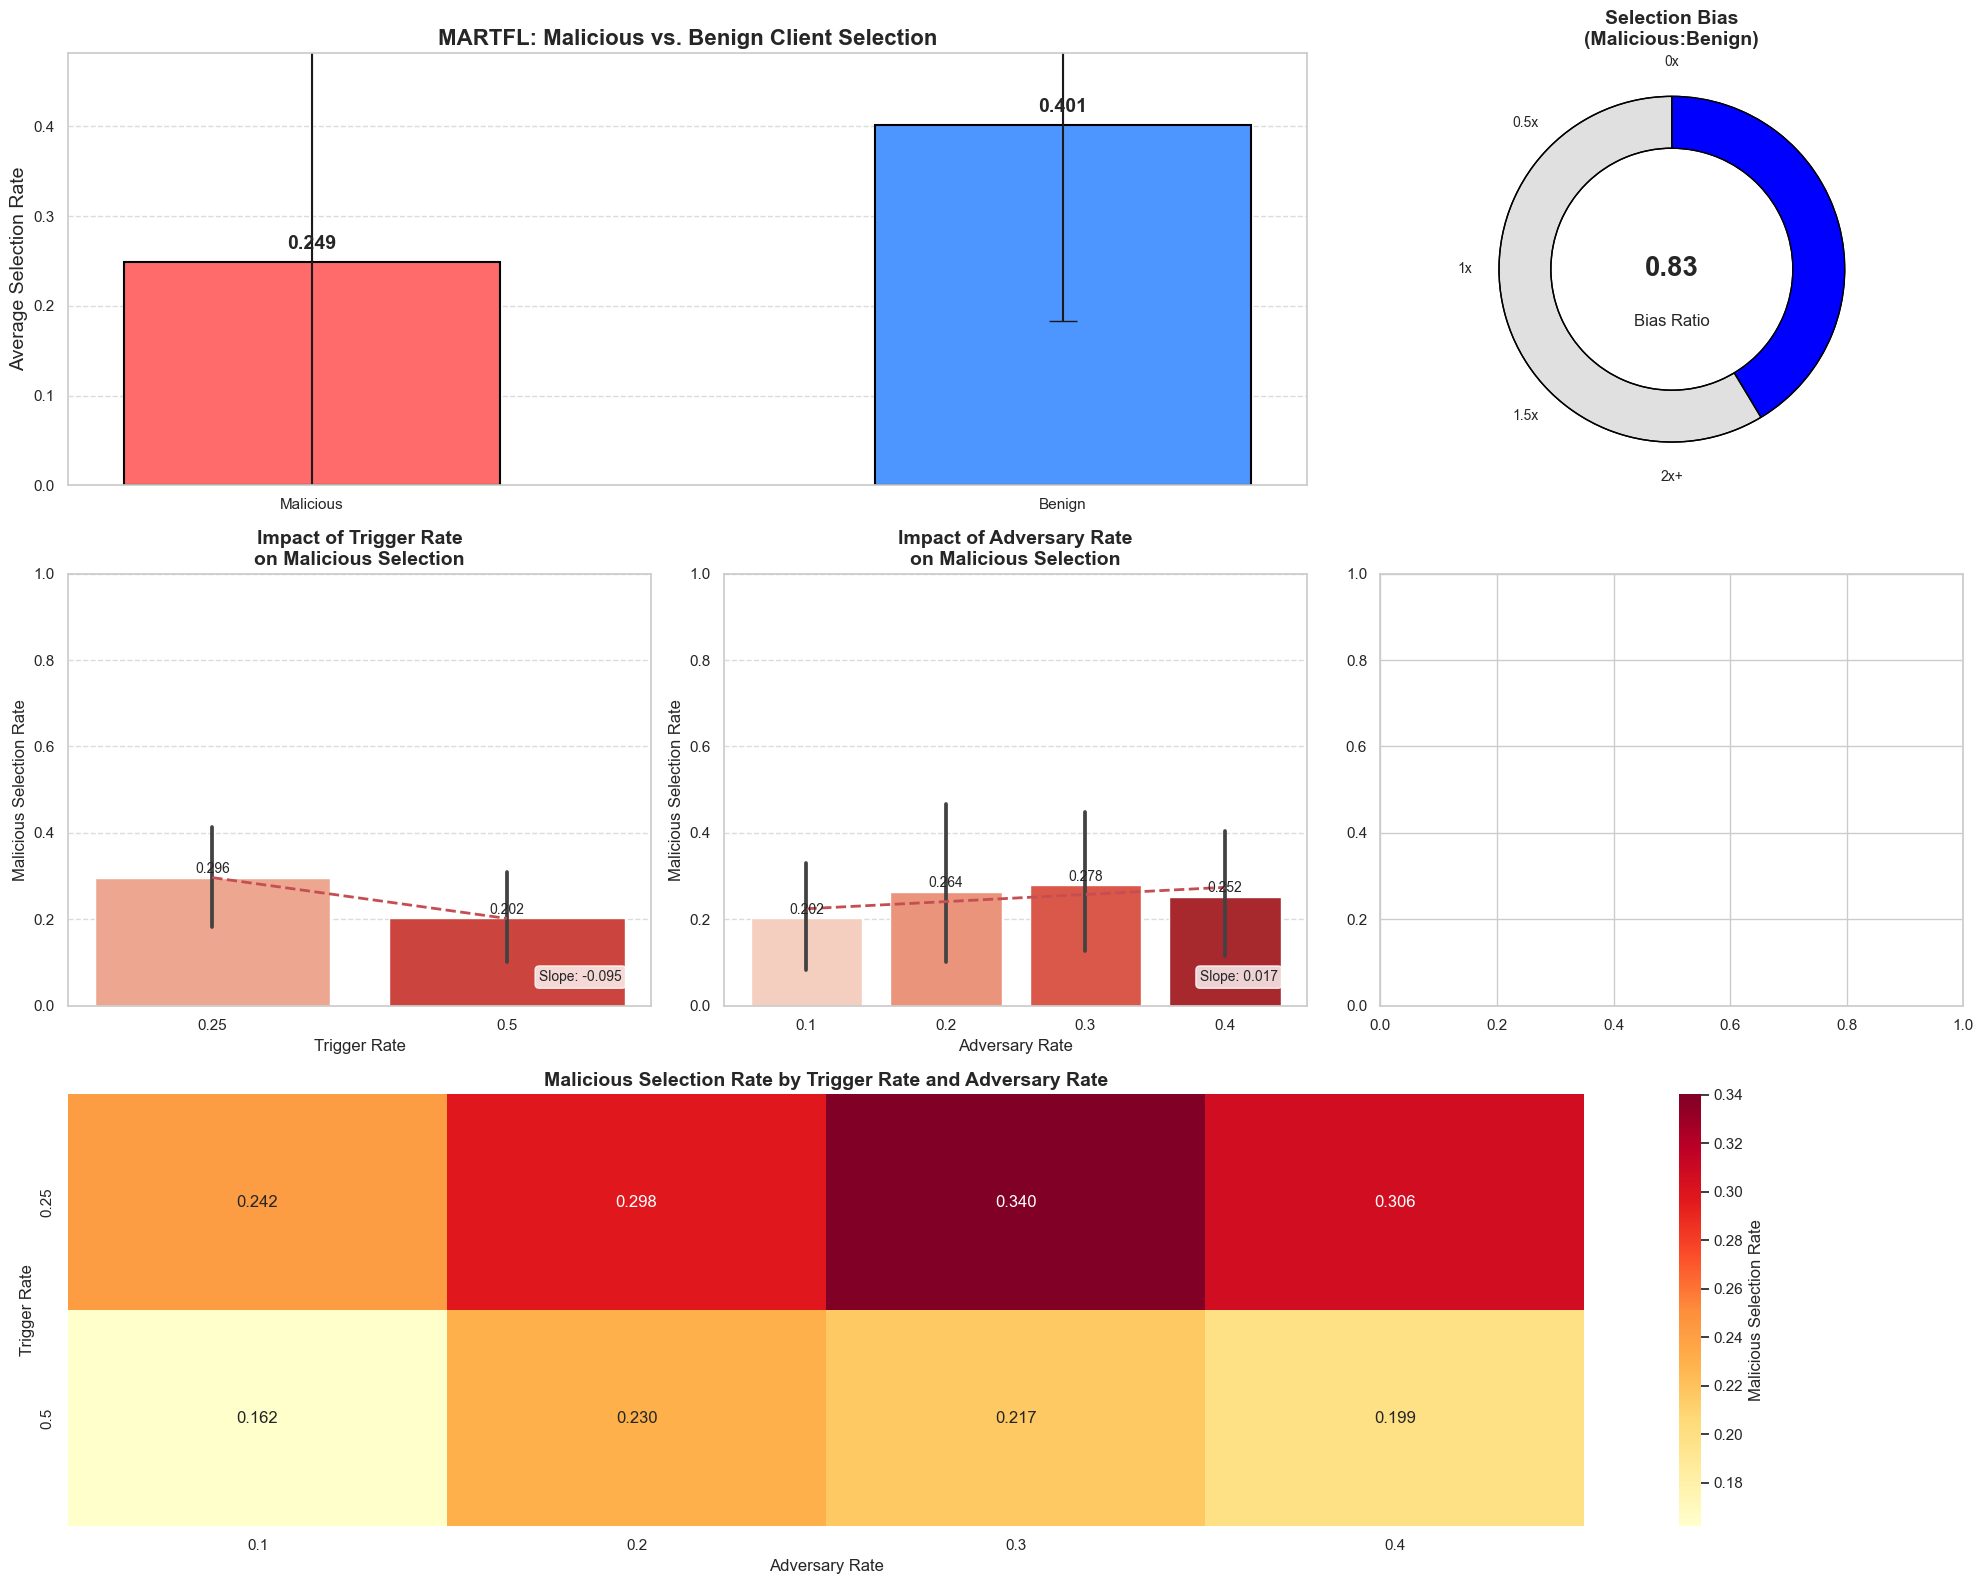

<Figure size 1600x1000 with 0 Axes>

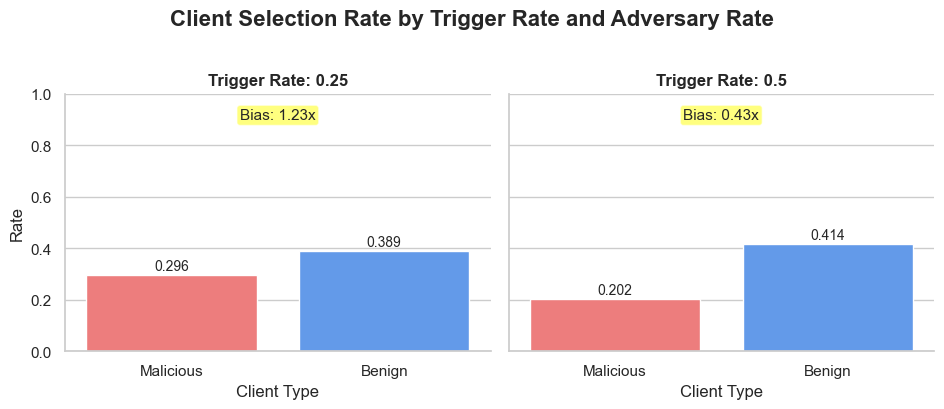

<Figure size 1600x800 with 0 Axes>

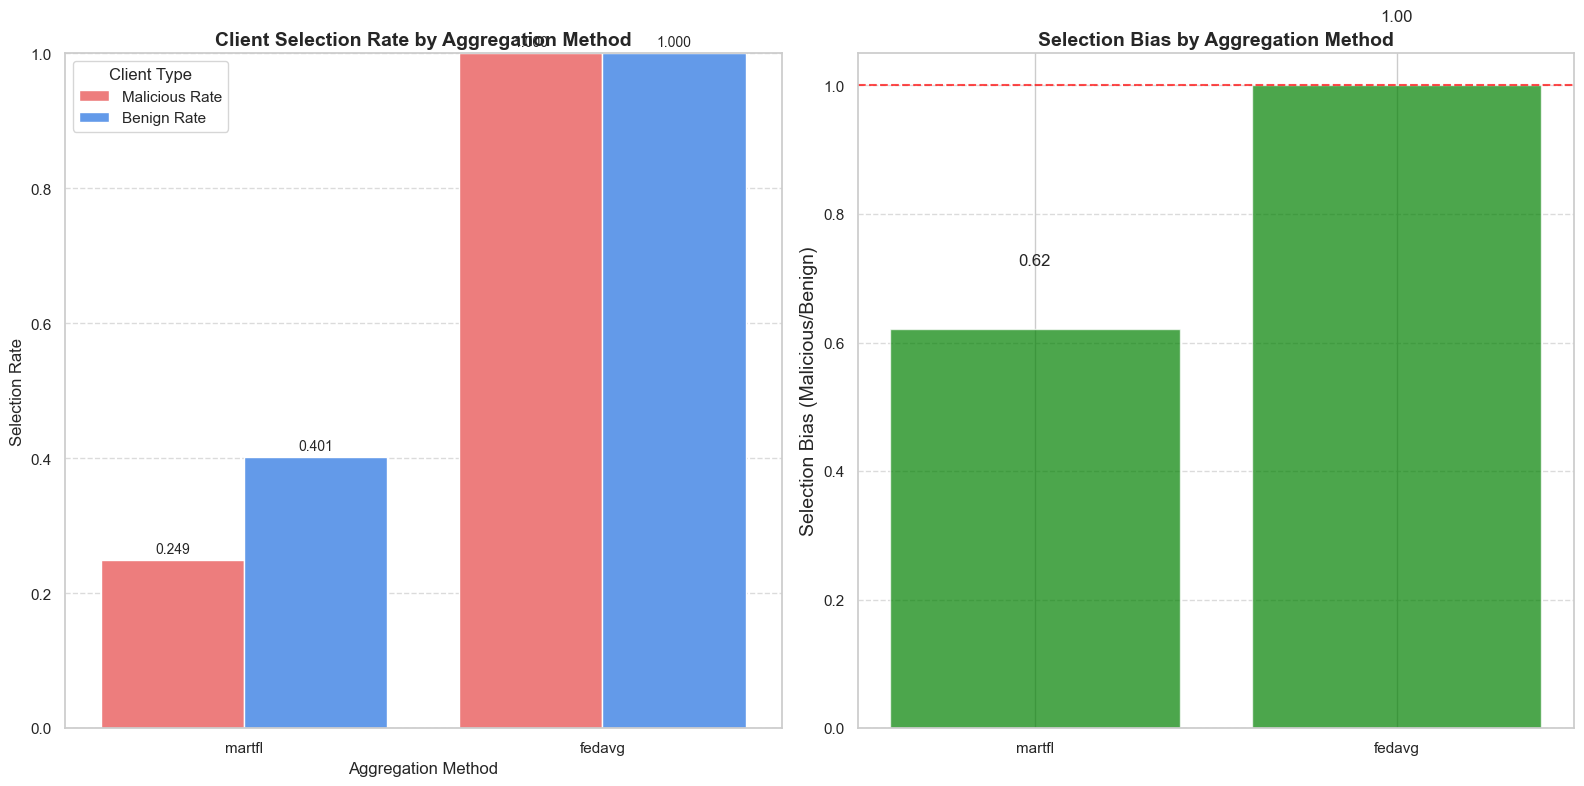


Summary Statistics for MARTFL:
Average Malicious Selection Rate: 0.2492 ± 0.3224
Average Benign Selection Rate: 0.4014 ± 0.2184
Selection Bias (Malicious/Benign): 0.8275

Malicious Selection Rate by Trigger Rate:
  Trigger Rate 0.25: 0.2965
  Trigger Rate 0.5: 0.2019

Malicious Selection Rate by Adversary Rate:
  Adversary Rate 0.1: 0.2021
  Adversary Rate 0.2: 0.2639
  Adversary Rate 0.3: 0.2785
  Adversary Rate 0.4: 0.2524


,AGGREGATION_METHOD,GRAD_MODE,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,IID,MAX_ASR,FINAL_ASR,FINAL_MAIN_ACC,...,ASR_75PCT,ROUNDS_TO_50PCT_ASR,ROUNDS_TO_75PCT_ASR,ROUNDS_TO_90PCT_ASR,AVG_MALICIOUS_RATE,AVG_BENIGN_RATE,ASR_PER_ADV,STEALTH,TOTAL_ROUNDS,SELECTION_BIAS
0,martfl,single,0.25,False,0.1,True,True,0.1959,0.0424,0.8170,...,0.1044,-1,-1,-1,0.095238,0.123457,0.424000,0.9925,21,0.771429
1,martfl,single,0.25,False,0.1,False,True,0.2652,0.2446,0.7510,...,0.2621,-1,-1,-1,0.777778,0.603175,2.446000,0.9854,21,1.289474
2,martfl,single,0.25,False,0.2,True,True,0.3132,0.0974,0.8304,...,0.0838,-1,-1,-1,0.095238,0.103175,0.487000,0.9908,21,0.923077
3,martfl,single,0.25,False,0.2,False,True,0.9272,0.8844,0.7638,...,0.8954,8,10,18,0.960317,0.577381,4.422000,0.9890,21,1.663230
4,martfl,single,0.25,False,0.3,True,True,0.9998,0.9805,0.8034,...,0.9869,0,2,2,0.322751,0.052154,3.268333,0.9898,21,6.188406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,martfl,single,0.50,True,0.2,False,True,0.1968,0.0953,0.8610,...,0.0977,-1,-1,-1,0.063492,0.640873,0.476500,0.9868,21,0.099071
60,martfl,single,0.50,True,0.3,True,True,0.1092,0.1005,0.8177,...,0.1092,-1,-1,-1,0.000000,0.365079,0.335000,0.9909,21,0.000000
61,martfl,single,0.50,True,0.3,False,True,0.2758,0.1133,0.8603,...,0.1161,-1,-1,-1,0.068783,0.693878,0.377667,0.9854,21,0.099129
62,martfl,single,0.50,True,0.4,True,True,0.1258,0.0689,0.8206,...,0.0630,-1,-1,-1,0.000000,0.415344,0.172250,0.9881,21,0.000000


In [38]:
visualize_martfl_selection_rates(df_summary, visial_save_path)

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def visualize_selection_rates_by_distribution(df, output_dir='./distribution_visualizations'):
    """
    Visualize the difference in malicious and benign client selection rates between
    IID and non-IID data distributions.

    Args:
        df: DataFrame containing the results
        output_dir: Directory to save the visualizations
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Filter out rows with missing selection rate data
    valid_df = df.dropna(subset=['AVG_MALICIOUS_RATE', 'AVG_BENIGN_RATE'])

    # Convert IID column to boolean if it's not already
    # if 'IID' in valid_df.columns and valid_df['IID'].dtype != bool:
    #     valid_df['IID'] = valid_df['IID'].astype(bool)

    # Check if we have IID information
    if 'IID' not in valid_df.columns or len(valid_df['IID'].unique()) <= 1:
        print("Error: Cannot compare IID vs non-IID. IID column not found or contains only one value.")
        return

    print(f"Analyzing {len(valid_df)} experiments with selection rate data")

    # 1. Create a clear side-by-side comparison
    plt.figure(figsize=(14, 8))

    # Prepare data for grouped bar chart
    iid_data = []
    for iid_val in sorted(valid_df['IID'].unique()):
        subset = valid_df[valid_df['IID'] == iid_val]

        # Calculate statistics
        mal_mean = subset['AVG_MALICIOUS_RATE'].mean()
        mal_std = subset['AVG_MALICIOUS_RATE'].std()
        ben_mean = subset['AVG_BENIGN_RATE'].mean()
        ben_std = subset['AVG_BENIGN_RATE'].std()
        selection_bias = mal_mean / (ben_mean + 1e-10)

        # Create entry
        iid_data.append({
            'Distribution': iid_val,
            'Malicious Rate': mal_mean,
            'Malicious Std': mal_std,
            'Benign Rate': ben_mean,
            'Benign Std': ben_std,
            'Selection Bias': selection_bias
        })

    iid_df = pd.DataFrame(iid_data)

    # Set up bar positions
    bar_width = 0.35
    r1 = np.arange(len(iid_df))
    r2 = [x + bar_width for x in r1]

    fig, ax = plt.subplots(figsize=(14, 8))

    # Create bars with more appealing colors
    bars1 = ax.bar(
        r1,
        iid_df['Malicious Rate'],
        width=bar_width,
        yerr=iid_df['Malicious Std'],
        color='#ff6b6b',
        label='Malicious',
        capsize=7,
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )

    bars2 = ax.bar(
        r2,
        iid_df['Benign Rate'],
        width=bar_width,
        yerr=iid_df['Benign Std'],
        color='#4d96ff',
        label='Benign',
        capsize=7,
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )

    # Add value labels
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Get heights
        h1 = bar1.get_height()
        h2 = bar2.get_height()

        # Position the text
        ax.text(
            bar1.get_x() + bar1.get_width()/2,
            h1 + 0.02,
            f"{h1:.3f}",
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

        ax.text(
            bar2.get_x() + bar2.get_width()/2,
            h2 + 0.02,
            f"{h2:.3f}",
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

        # Add bias ratio text
        bias = iid_df.iloc[i]['Selection Bias']
        y_pos = max(h1, h2) + 0.1

        # Format bias text based on value
        if bias > 1:
            bias_text = f"Bias: {bias:.2f}x (favors malicious)"
            text_color = 'red'
        elif bias < 1:
            bias_text = f"Bias: {bias:.2f}x (favors benign)"
            text_color = 'blue'
        else:
            bias_text = "No bias"
            text_color = 'black'

        ax.text(
            r1[i] + bar_width/2,
            y_pos,
            bias_text,
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold',
            color=text_color,
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.4)
        )

    # Add visual connections between same client types
    # This helps to see the difference between IID and Non-IID
    if len(r1) > 1:
        # Connect malicious bars
        malicious_heights = iid_df['Malicious Rate'].values
        x_vals = [r + bar_width/2 for r in r1]
        ax.plot(x_vals, malicious_heights, 'o-', color='darkred', alpha=0.5, linewidth=1.5)

        # Connect benign bars
        benign_heights = iid_df['Benign Rate'].values
        x_vals = [r + bar_width/2 for r in r2]
        ax.plot(x_vals, benign_heights, 'o-', color='darkblue', alpha=0.5, linewidth=1.5)

        # Add percentage change annotations
        if len(malicious_heights) == 2:
            # For malicious rate
            mal_change = (malicious_heights[1] - malicious_heights[0]) / malicious_heights[0] * 100
            ax.annotate(
                f"{mal_change:+.1f}%",
                xy=(x_vals[1], malicious_heights[1]),
                xytext=(x_vals[0] + 0.5, (malicious_heights[0] + malicious_heights[1])/2 + 0.05),
                arrowprops=dict(arrowstyle="->", color='darkred', alpha=0.6),
                fontsize=10,
                color='darkred',
                fontweight='bold'
            )

            # For benign rate
            ben_change = (benign_heights[1] - benign_heights[0]) / benign_heights[0] * 100
            ax.annotate(
                f"{ben_change:+.1f}%",
                xy=(x_vals[1], benign_heights[1]),
                xytext=(x_vals[0] + 0.5, (benign_heights[0] + benign_heights[1])/2 - 0.05),
                arrowprops=dict(arrowstyle="->", color='darkblue', alpha=0.6),
                fontsize=10,
                color='darkblue',
                fontweight='bold'
            )

    # Customize apperarance
    ax.set_ylabel('Selection Rate', fontsize=14, fontweight='bold')
    ax.set_title('Client Selection Rate by Data Distribution', fontsize=16, fontweight='bold')
    ax.set_xticks([r + bar_width/2 for r in range(len(iid_df))])
    ax.set_xticklabels(iid_df['Distribution'], fontsize=12, fontweight='bold')
    ax.set_ylim(0, min(1.0, max(iid_df['Malicious Rate'].max(), iid_df['Benign Rate'].max()) * 1.5))
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a subtitle with explanation
    plt.figtext(
        0.5, 0.01,
        "Comparison of how often malicious and benign clients are selected in IID vs. Non-IID data distributions",
        ha='center',
        fontsize=11,
        fontstyle='italic'
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(f"{output_dir}/selection_rates_by_distribution.png", dpi=300)
    plt.savefig(f"{output_dir}/selection_rates_by_distribution.pdf", format='pdf')
    plt.show()
    plt.close()

    # 2. Create a heatmap showing selection rates by aggregation method and distribution
    if 'AGGREGATION_METHOD' in valid_df.columns and len(valid_df['AGGREGATION_METHOD'].unique()) > 1:
        plt.figure(figsize=(16, 12))

        # Create subplots for malicious and benign rates
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

        # Prepare data for malicious clients
        mal_pivot = valid_df.pivot_table(
            values='AVG_MALICIOUS_RATE',
            index='AGGREGATION_METHOD',
            columns='IID',
            aggfunc='mean'
        )

        # Rename columns for clarity
        mal_pivot.columns = ['Non-IID' if not c else 'IID' for c in mal_pivot.columns]

        # Create heatmap for malicious clients
        sns.heatmap(
            mal_pivot,
            annot=True,
            fmt='.3f',
            cmap='Reds',
            linewidths=0.5,
            ax=ax1,
            cbar_kws={'label': 'Malicious Selection Rate'}
        )

        ax1.set_title('Malicious Client Selection Rate by Aggregation Method and Distribution', fontsize=14, fontweight='bold')

        # Prepare data for benign clients
        ben_pivot = valid_df.pivot_table(
            values='AVG_BENIGN_RATE',
            index='AGGREGATION_METHOD',
            columns='IID',
            aggfunc='mean'
        )

        # Rename columns for clarity
        ben_pivot.columns = ['Non-IID' if not c else 'IID' for c in ben_pivot.columns]

        # Create heatmap for benign clients
        sns.heatmap(
            ben_pivot,
            annot=True,
            fmt='.3f',
            cmap='Blues',
            linewidths=0.5,
            ax=ax2,
            cbar_kws={'label': 'Benign Selection Rate'}
        )

        ax2.set_title('Benign Client Selection Rate by Aggregation Method and Distribution', fontsize=14, fontweight='bold')

        # Calculate and display the difference (IID - non-IID)
        if 'IID' in mal_pivot.columns and 'Non-IID' in mal_pivot.columns:
            # Create a third subplot for the difference
            fig.set_size_inches(14, 24)
            ax3 = fig.add_subplot(3, 1, 3)

            # Calculate difference for malicious rates
            mal_diff = pd.DataFrame({
                'Malicious': mal_pivot['IID'] - mal_pivot['Non-IID'],
                'Benign': ben_pivot['IID'] - ben_pivot['Non-IID']
            })

            # Create heatmap for the difference
            sns.heatmap(
                mal_diff,
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                linewidths=0.5,
                ax=ax3,
                cbar_kws={'label': 'Selection Rate Difference (IID - Non-IID)'}
            )

            ax3.set_title('Selection Rate Difference (IID - Non-IID) by Aggregation Method', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/selection_rates_by_distribution_and_method.png", dpi=300)
        plt.savefig(f"{output_dir}/selection_rates_by_distribution_and_method.pdf", format='pdf')
        plt.show()
        plt.close()

    # 3. Create boxplots showing the distribution of selection rates
    plt.figure(figsize=(15, 10))

    # Convert to long format for easier plotting
    long_df = pd.melt(
        valid_df,
        id_vars=['IID'],
        value_vars=['AVG_MALICIOUS_RATE', 'AVG_BENIGN_RATE'],
        var_name='Client Type',
        value_name='Selection Rate'
    )

    # Map values for better display
    long_df['Data Distribution'] = long_df['IID'].map({True: 'IID', False: 'Non-IID'})
    long_df['Client Type'] = long_df['Client Type'].map({
        'AVG_MALICIOUS_RATE': 'Malicious',
        'AVG_BENIGN_RATE': 'Benign'
    })

    # Create a boxplot with individual points
    ax = sns.boxplot(
        x='Data Distribution',
        y='Selection Rate',
        hue='Client Type',
        data=long_df,
        palette=['#ff6b6b', '#4d96ff'],
        width=0.6,
        fliersize=0
    )

    # Add individual data points
    sns.stripplot(
        x='Data Distribution',
        y='Selection Rate',
        hue='Client Type',
        data=long_df,
        dodge=True,
        jitter=True,
        color='black',
        alpha=0.5,
        size=4,
        ax=ax,
        legend=False
    )

    # Add statistical annotations
    from scipy import stats

    # For malicious clients
    mal_iid = valid_df[valid_df['IID'] == True]['AVG_MALICIOUS_RATE']
    mal_noniid = valid_df[valid_df['IID'] == False]['AVG_MALICIOUS_RATE']

    # For benign clients
    ben_iid = valid_df[valid_df['IID'] == True]['AVG_BENIGN_RATE']
    ben_noniid = valid_df[valid_df['IID'] == False]['AVG_BENIGN_RATE']

    # Perform t-tests
    mal_tstat, mal_pval = stats.ttest_ind(mal_iid, mal_noniid, equal_var=False)
    ben_tstat, ben_pval = stats.ttest_ind(ben_iid, ben_noniid, equal_var=False)

    # Add p-value annotations
    ax.text(
        0.5, 0.95,
        f"Malicious: p={mal_pval:.4f}" + (" *" if mal_pval < 0.05 else ""),
        transform=ax.transAxes,
        ha='center',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.4)
    )

    ax.text(
        0.5, 0.90,
        f"Benign: p={ben_pval:.4f}" + (" *" if ben_pval < 0.05 else ""),
        transform=ax.transAxes,
        ha='center',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.4)
    )

    # Customize appearance
    plt.title('Distribution of Selection Rates by Data Distribution', fontsize=16, fontweight='bold')
    plt.ylabel('Selection Rate', fontsize=14)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Client Type', title_fontsize=12, fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/selection_rates_boxplot.png", dpi=300)
    plt.savefig(f"{output_dir}/selection_rates_boxplot.pdf", format='pdf')
    plt.close()

    # Print summary statistics
    print("\nSummary Statistics by Data Distribution:")

    for iid_val in sorted(valid_df['IID'].unique()):
        subset = valid_df[valid_df['IID'] == iid_val]
        dist_name = 'IID' if iid_val else 'Non-IID'

        mal_mean = subset['AVG_MALICIOUS_RATE'].mean()
        mal_std = subset['AVG_MALICIOUS_RATE'].std()
        ben_mean = subset['AVG_BENIGN_RATE'].mean()
        ben_std = subset['AVG_BENIGN_RATE'].std()
        selection_bias = mal_mean / (ben_mean + 1e-10)

        print(f"\n{dist_name} Distribution:")
        print(f"  Malicious Selection Rate: {mal_mean:.4f} ± {mal_std:.4f}")
        print(f"  Benign Selection Rate: {ben_mean:.4f} ± {ben_std:.4f}")
        print(f"  Selection Bias (Malicious/Benign): {selection_bias:.4f}")

    # Print statistical significance results
    print("\nStatistical Significance Tests (IID vs Non-IID):")
    print(f"  Malicious Selection Rate: p-value = {mal_pval:.4f}" + (" (significant)" if mal_pval < 0.05 else ""))
    print(f"  Benign Selection Rate: p-value = {ben_pval:.4f}" + (" (significant)" if ben_pval < 0.05 else ""))

    return iid_df  # Return the processed summary data for further analysis

Analyzing 96 experiments with selection rate data


<Figure size 1400x800 with 0 Axes>

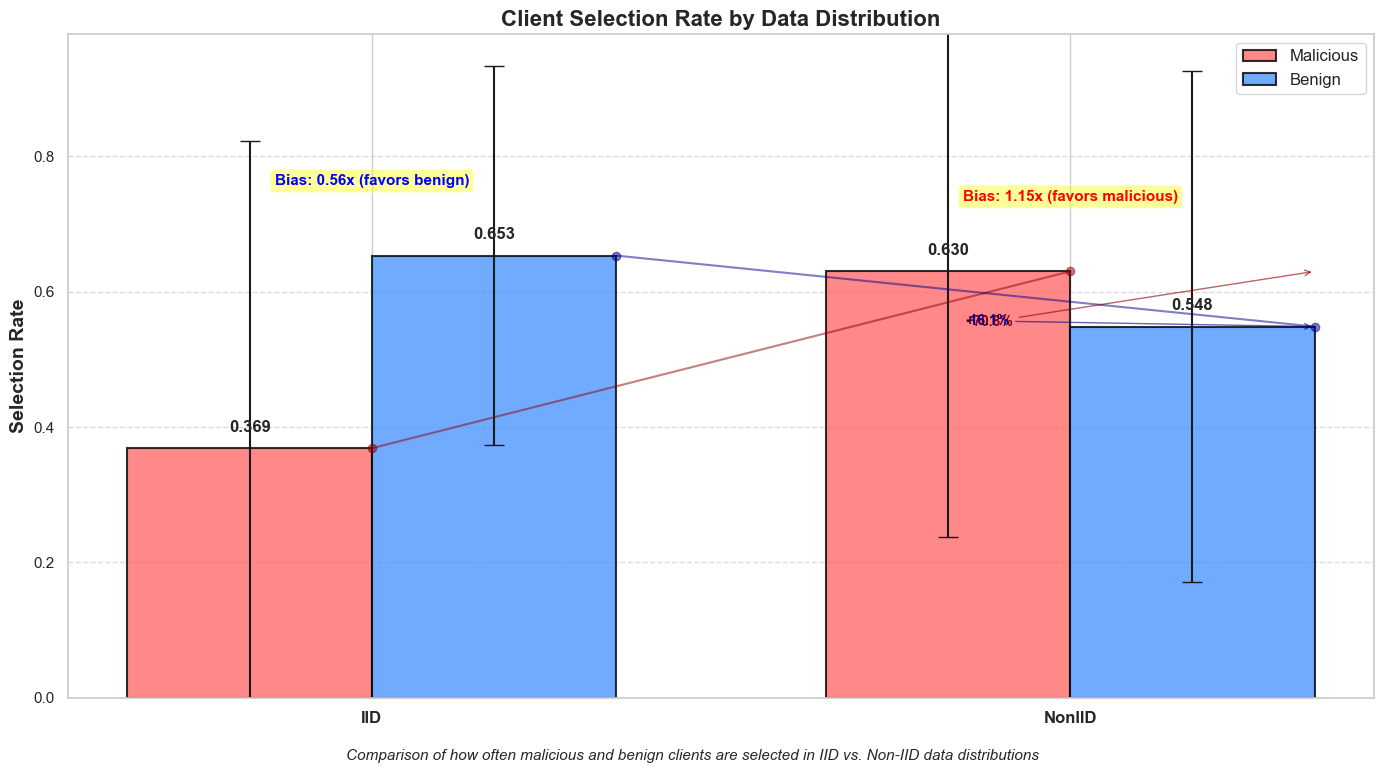

<Figure size 1600x1200 with 0 Axes>

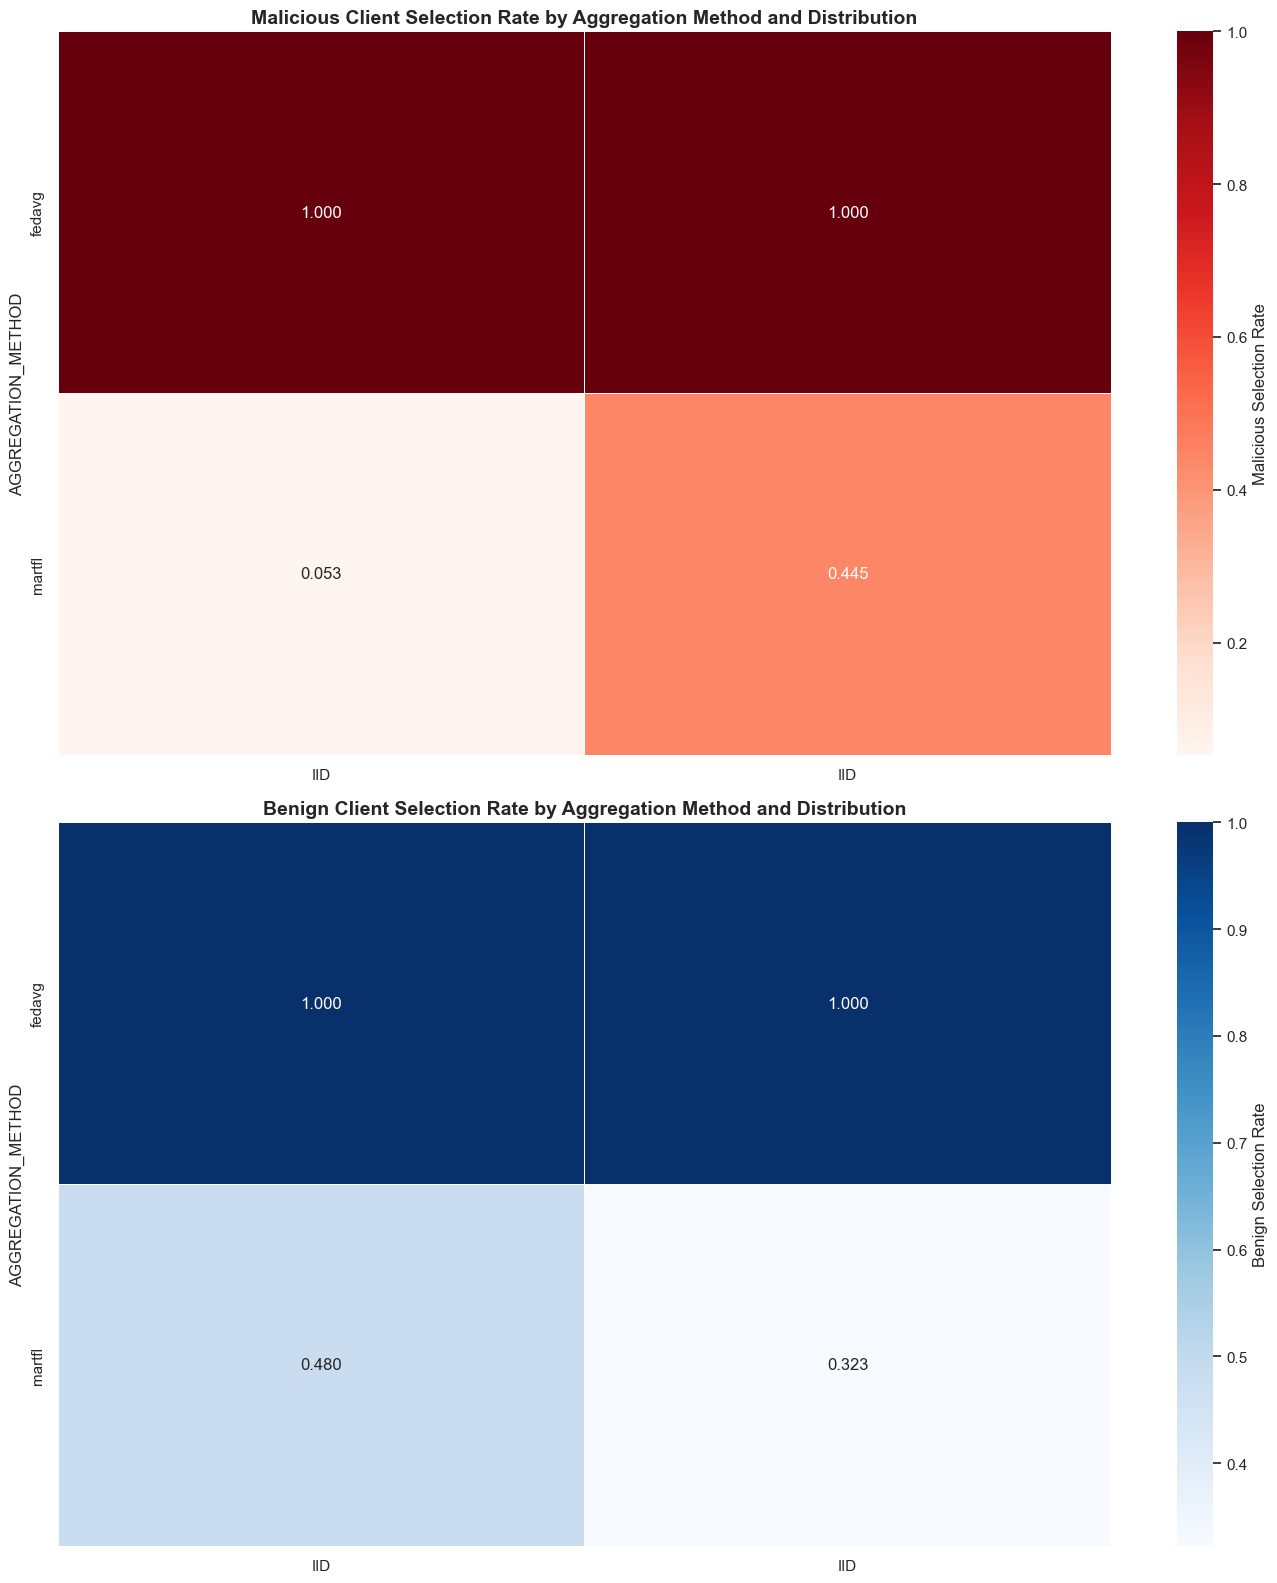

C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:761: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\zeyu song\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:220: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
N


Summary Statistics by Data Distribution:

IID Distribution:
  Malicious Selection Rate: 0.3688 ± 0.4535
  Benign Selection Rate: 0.6534 ± 0.2798
  Selection Bias (Malicious/Benign): 0.5645

IID Distribution:
  Malicious Selection Rate: 0.6301 ± 0.3932
  Benign Selection Rate: 0.5485 ± 0.3777
  Selection Bias (Malicious/Benign): 1.1488

Statistical Significance Tests (IID vs Non-IID):
  Malicious Selection Rate: p-value = nan
  Benign Selection Rate: p-value = nan


,Distribution,Malicious Rate,Malicious Std,Benign Rate,Benign Std,Selection Bias
0,IID,0.368827,0.453523,0.653425,0.279784,0.564452
1,NonIID,0.630125,0.393185,0.548492,0.377694,1.148832


In [43]:
visualize_selection_rates_by_distribution(df_summary, visial_save_path)

In [31]:
df

,AGGREGATION_METHOD,GRAD_MODE,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,IID,MAX_ASR,FINAL_ASR,FINAL_MAIN_ACC,...,ASR_50PCT,ASR_75PCT,ROUNDS_TO_50PCT_ASR,ROUNDS_TO_75PCT_ASR,ROUNDS_TO_90PCT_ASR,AVG_MALICIOUS_RATE,AVG_BENIGN_RATE,ASR_PER_ADV,STEALTH,TOTAL_ROUNDS
0,martfl,single,0.25,False,0.1,True,NonIID,0.1959,0.0424,0.8170,...,0.0948,0.1044,-1,-1,-1,0.095238,0.123457,0.424000,0.9925,21
1,martfl,single,0.25,False,0.1,False,NonIID,0.2652,0.2446,0.7510,...,0.1678,0.2621,-1,-1,-1,0.777778,0.603175,2.446000,0.9854,21
2,martfl,single,0.25,False,0.2,True,NonIID,0.3132,0.0974,0.8304,...,0.1038,0.0838,-1,-1,-1,0.095238,0.103175,0.487000,0.9908,21
3,martfl,single,0.25,False,0.2,False,NonIID,0.9272,0.8844,0.7638,...,0.7495,0.8954,8,10,18,0.960317,0.577381,4.422000,0.9890,21
4,martfl,single,0.25,False,0.3,True,NonIID,0.9998,0.9805,0.8034,...,0.9909,0.9869,0,2,2,0.322751,0.052154,3.268333,0.9898,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,fedavg,single,0.50,False,0.4,False,IID,0.9747,0.9703,0.8841,...,0.9362,0.9636,0,0,22,1.000000,1.000000,2.425750,0.9820,51
92,fedavg,single,0.50,True,0.1,False,IID,0.4892,0.4892,0.8878,...,0.1522,0.2642,-1,-1,-1,1.000000,1.000000,4.892000,0.9804,51
93,fedavg,single,0.50,True,0.2,False,IID,0.8624,0.8622,0.8863,...,0.4997,0.7957,0,36,-1,1.000000,1.000000,4.311000,0.9818,51
94,fedavg,single,0.50,True,0.3,False,IID,0.9467,0.9429,0.8853,...,0.8438,0.9184,0,23,34,1.000000,1.000000,3.143000,0.9819,51


In [41]:
import pandas as pd
import numpy as np

def generate_performance_statistics(df):
    """
    Generate a table of model performance statistics grouped by
    AGGREGATION_METHOD and IID/NonIID distribution.

    Args:
        df: DataFrame containing experimental results with columns:
           - AGGREGATION_METHOD: aggregation method used (e.g., 'martfl', 'fedavg')
           - IID: data distribution ('IID' or 'NonIID')
           - FINAL_ASR: Attack Success Rate
           - FINAL_MAIN_ACC: Main Task Accuracy
           - Other metrics as needed

    Returns:
        DataFrame with performance statistics
    """
    # Verify required columns exist
    required_cols = ['AGGREGATION_METHOD', 'IID', 'FINAL_ASR', 'FINAL_MAIN_ACC']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Create a list to store results
    results = []

    # Group by AGGREGATION_METHOD and IID
    grouped = df.groupby(['AGGREGATION_METHOD', 'IID'])

    # Define metrics to include in the table
    metrics = {
        'FINAL_ASR': 'Attack Success Rate',
        'FINAL_MAIN_ACC': 'Main Task Accuracy',
        'AVG_MALICIOUS_RATE': 'Malicious Selection Rate',
        'AVG_BENIGN_RATE': 'Benign Selection Rate',
    }

    # Add additional metrics if they exist in the dataframe
    for metric in ['FINAL_CLEAN_ACC', 'FINAL_TRIGGERED_ACC', 'STEALTH']:
        if metric in df.columns:
            metrics[metric] = metric.replace('FINAL_', '').replace('_', ' ').title()

    # Iterate through each group
    for (agg_method, iid_val), group in grouped:
        # Calculate statistics for each metric
        entry = {
            'Aggregation Method': agg_method,
            'Data Distribution': iid_val,
            'Sample Size': len(group)
        }

        # Calculate statistics for available metrics
        for metric_col, metric_name in metrics.items():
            if metric_col in group.columns:
                values = group[metric_col].dropna()

                if len(values) > 0:
                    entry[f'{metric_name} (Mean)'] = values.mean()
                    entry[f'{metric_name} (Std)'] = values.std()
                    entry[f'{metric_name} (Min)'] = values.min()
                    entry[f'{metric_name} (Max)'] = values.max()
                else:
                    entry[f'{metric_name} (Mean)'] = np.nan
                    entry[f'{metric_name} (Std)'] = np.nan
                    entry[f'{metric_name} (Min)'] = np.nan
                    entry[f'{metric_name} (Max)'] = np.nan

        # Calculate selection bias if both malicious and benign rates are available
        if 'AVG_MALICIOUS_RATE' in group.columns and 'AVG_BENIGN_RATE' in group.columns:
            mal_rates = group['AVG_MALICIOUS_RATE'].dropna()
            ben_rates = group['AVG_BENIGN_RATE'].dropna()

            if len(mal_rates) > 0 and len(ben_rates) > 0:
                bias_values = mal_rates / (ben_rates + 1e-10)
                entry['Selection Bias (Mean)'] = bias_values.mean()
                entry['Selection Bias (Std)'] = bias_values.std()

        results.append(entry)

    # Create DataFrame from results
    stats_df = pd.DataFrame(results)

    # Sort by aggregation method and data distribution
    stats_df = stats_df.sort_values(['Aggregation Method', 'Data Distribution'])

    return stats_df

def print_formatted_table(stats_df, output_file=None):
    """
    Print a formatted table of statistics and optionally save to a file.

    Args:
        stats_df: DataFrame with statistics
        output_file: Optional file path to save the table
    """
    # Create a formatted copy with rounded values
    formatted_df = stats_df.copy()

    # Round numeric columns to 4 decimal places
    numeric_cols = stats_df.select_dtypes(include=['float64', 'float32']).columns
    for col in numeric_cols:
        formatted_df[col] = formatted_df[col].round(4)

    # Print the formatted table
    print("\nModel Performance Statistics by Aggregation Method and Data Distribution:")
    print("="*100)
    print(formatted_df.to_string(index=False))
    print("="*100)

    # Save to file if specified
    if output_file:
        # Save both a CSV (for further analysis) and a text file (for readability)
        stats_df.to_csv(f"{output_file}.csv", index=False, float_format='%.4f')

        with open(f"{output_file}.txt", 'w') as f:
            f.write("Model Performance Statistics by Aggregation Method and Data Distribution:\n")
            f.write("="*100 + "\n")
            f.write(formatted_df.to_string(index=False))
            f.write("\n" + "="*100 + "\n")

        print(f"Statistics saved to {output_file}.csv and {output_file}.txt")

    return formatted_df

def generate_latex_table(stats_df, output_file=None, metrics=None):
    """
    Generate a LaTeX table for publication.

    Args:
        stats_df: DataFrame with statistics
        output_file: Optional file path to save the LaTeX code
        metrics: List of metrics to include (defaults to ASR and accuracy)
    """
    if metrics is None:
        # Default to these metrics if not specified
        metrics = ['Attack Success Rate', 'Main Task Accuracy']

    # Create a clean dataframe for LaTeX
    latex_rows = []

    # Get unique aggregation methods and data distributions
    agg_methods = stats_df['Aggregation Method'].unique()
    distributions = stats_df['Data Distribution'].unique()

    for agg in agg_methods:
        for metric in metrics:
            row = {'Metric': metric}

            for dist in distributions:
                # Get the specific entry
                entry = stats_df[(stats_df['Aggregation Method'] == agg) &
                                 (stats_df['Data Distribution'] == dist)]

                if not entry.empty:
                    mean_col = f'{metric} (Mean)'
                    std_col = f'{metric} (Std)'

                    if mean_col in entry.columns and std_col in entry.columns:
                        mean_val = entry[mean_col].values[0]
                        std_val = entry[std_col].values[0]

                        if not np.isnan(mean_val) and not np.isnan(std_val):
                            row[dist] = f"{mean_val:.4f} ± {std_val:.4f}"
                        else:
                            row[dist] = "N/A"
                    else:
                        row[dist] = "N/A"
                else:
                    row[dist] = "N/A"

            row['Method'] = agg
            latex_rows.append(row)

    # Convert to DataFrame for easier handling
    latex_df = pd.DataFrame(latex_rows)

    # Rearrange columns for better table structure
    cols = ['Method', 'Metric'] + [col for col in latex_df.columns if col not in ['Method', 'Metric']]
    latex_df = latex_df[cols]

    # Generate LaTeX code
    latex_code = latex_df.to_latex(index=False, escape=False)

    # Save to file if specified
    if output_file:
        with open(f"{output_file}.tex", 'w') as f:
            f.write(latex_code)
        print(f"LaTeX table saved to {output_file}.tex")

    return latex_code

# Example usage:
# stats_df = generate_performance_statistics(df_summary)
# print_formatted_table(stats_df, "performance_statistics")
# generate_latex_table(stats_df, "performance_latex")

In [39]:
stats_df = generate_performance_statistics(df_summary)
# print_formatted_table(stats_df, "performance_statistics")
generate_latex_table(stats_df, "performance_latex")(df, output_dir='./distribution_visualizations'):


SyntaxError: invalid syntax (195553440.py, line 3)

In [40]:
stats_df = generate_performance_statistics(df_summary)
# print_formatted_table(stats_df, "performance_statistics")
generate_latex_table(stats_df, "performance_latex")


LaTeX table saved to performance_latex.tex


'\\begin{tabular}{llll}\n\\toprule\nMethod & Metric & IID & NonIID \\\\\n\\midrule\nfedavg & Attack Success Rate & 0.7815 ± 0.2426 & 0.7788 ± 0.2677 \\\\\nfedavg & Main Task Accuracy & 0.8860 ± 0.0011 & 0.8410 ± 0.0040 \\\\\nmartfl & Attack Success Rate & 0.1416 ± 0.1544 & 0.5434 ± 0.4298 \\\\\nmartfl & Main Task Accuracy & 0.8389 ± 0.0212 & 0.7534 ± 0.0956 \\\\\n\\bottomrule\n\\end{tabular}\n'

KeyError: 'BENIGN_SEL_RATE'

<Figure size 1400x800 with 0 Axes>

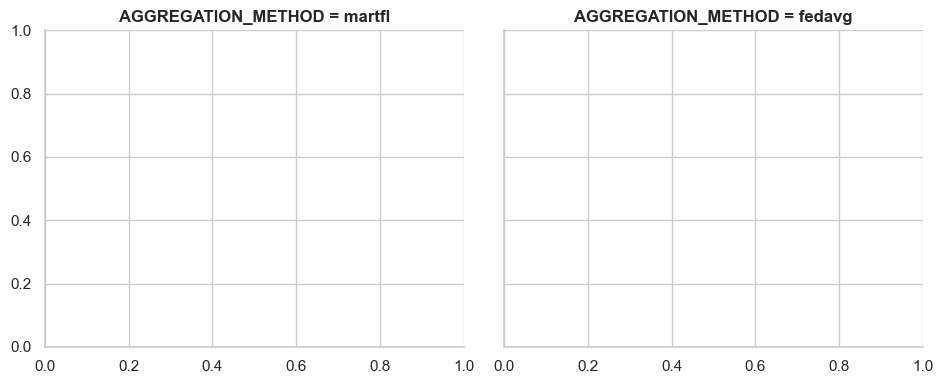

In [44]:
def plot_selection_rates(results_df, save_path):
    """
    Plot the relationship between benign and malicious selection rates
    as the adversary ratio changes.
    
    Parameters:
    results_df: DataFrame with columns 'ADV_RATE', 'BENIGN_SEL_RATE', 
                'MALICIOUS_SEL_RATE', 'AGGREGATION_METHOD'
    save_path: Path to save the visualization
    """
    plt.figure(figsize=(14, 8))
    
    # Create plot with multiple panels by aggregation method
    g = sns.FacetGrid(
        results_df, 
        col='AGGREGATION_METHOD',
        height=4, 
        aspect=1.2,
        sharey=True,
        sharex=True
    )
    
    # Create the scatter plot with connected lines for each adversary ratio
    def plot_selection_relationship(data, **kwargs):
        # Get unique adversary ratios
        adv_rates = sorted(data['ADV_RATE'].unique())
        
        # Plot scatter points
        plt.scatter(
            data['BENIGN_SEL_RATE'], 
            data['MALICIOUS_SEL_RATE'],
            s=100,  # Point size
            c=data['ADV_RATE'],  # Color by adversary ratio
            cmap='viridis',  # Color map
            alpha=0.8,
            edgecolor='black',
            linewidth=1
        )
        
        # Add text labels for adversary ratios
        for adv_rate in adv_rates:
            subset = data[data['ADV_RATE'] == adv_rate]
            if not subset.empty:
                x = subset['BENIGN_SEL_RATE'].mean()
                y = subset['MALICIOUS_SEL_RATE'].mean()
                plt.text(x+0.01, y, f'{adv_rate:.1f}', fontsize=9)
        
        # Draw connected lines between adjacent adversary ratios
        # Sort by adversary ratio to ensure proper connection
        sorted_data = data.sort_values('ADV_RATE')
        plt.plot(
            sorted_data['BENIGN_SEL_RATE'], 
            sorted_data['MALICIOUS_SEL_RATE'],
            'k--',  # Black dashed line
            alpha=0.6,
            linewidth=1
        )
        
        # Draw the diagonal line (equal selection rate)
        x = np.linspace(0, 1, 100)
        plt.plot(x, x, 'r-', alpha=0.5, label='Equal Selection')
        
        # Draw the ideal line (100% benign, 0% malicious)
        plt.plot([1, 1], [0, 0], 'go', markersize=10, label='Ideal Point')
        
        # Add arrows to show direction of increasing adversary ratio
        arrow_indices = np.linspace(0, len(sorted_data)-1, min(5, len(sorted_data))).astype(int)
        for i in arrow_indices[:-1]:
            if i+1 < len(sorted_data):
                x1, y1 = sorted_data.iloc[i][['BENIGN_SEL_RATE', 'MALICIOUS_SEL_RATE']]
                x2, y2 = sorted_data.iloc[i+1][['BENIGN_SEL_RATE', 'MALICIOUS_SEL_RATE']]
                dx, dy = x2-x1, y2-y1
                if abs(dx) > 0.01 or abs(dy) > 0.01:  # Only add arrow if there's enough change
                    plt.arrow(x1, y1, dx*0.8, dy*0.8, head_width=0.02, head_length=0.03, 
                             fc='black', ec='black', alpha=0.6)
    
    # Map the plot function across the facets
    g.map_dataframe(plot_selection_relationship)
    
    # Customize appearance
    g.set_axis_labels('Benign Selection Rate', 'Malicious Selection Rate')
    g.set_titles(col_template='{col_name}')
    
    # Format axes as percentages
    for ax in g.axes.flat:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
        # Set axis limits
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1.05)
        
        # Add a legend for adversary ratio
        sm = plt.cm.ScalarMappable(cmap='viridis')
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Adversary Ratio')
        
        # Add diagonal and ideal point labels
        ax.legend(loc='upper right')
    
    # Add explanatory annotation
    plt.figtext(0.5, 0.01, 
               "Points show selection rates at different adversary ratios.\n"
               "Ideal defense would maintain high benign selection while keeping malicious selection low.",
               ha='center', fontsize=10, style='italic')
    
    # Add title
    plt.suptitle('Relationship Between Benign and Malicious Selection Rates\nas Adversary Ratio Increases', 
                fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}/selection_rate_relationship.png', dpi=300, bbox_inches='tight')
    
    return g
plot_selection_rates(df_summary, visial_save_path)

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1466852\2141401226.py:21: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(
C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1466852\2141401226.py:32: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(
C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1466852\2141401226.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1466852\2141401226.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


AttributeError: 'NoneType' object has no attribute 'remove'

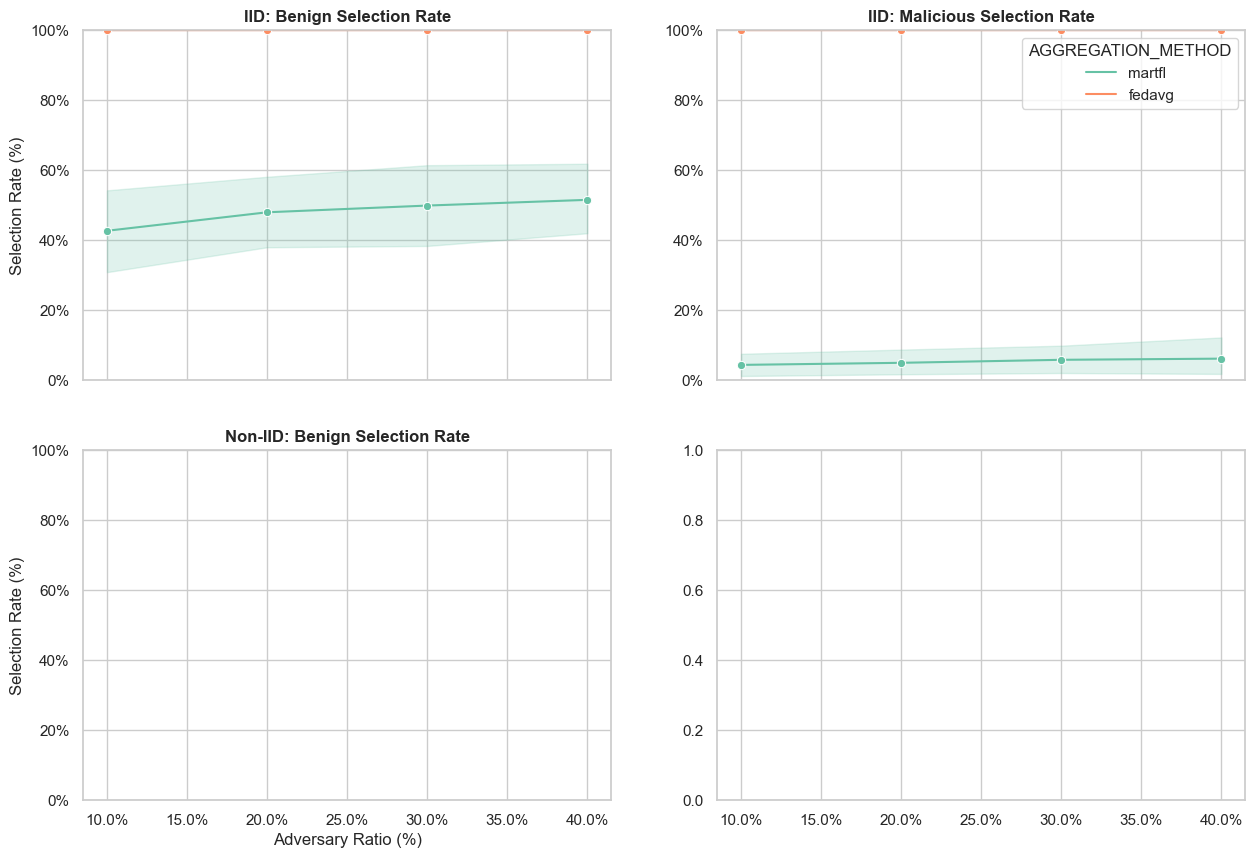

In [47]:
def plot_selection_vs_adv_rate_by_iid(results_df, save_path):
    """
    Simplified plot of selection rates vs adversary ratio, split by IID type.
    
    Parameters:
    results_df: DataFrame with columns ADV_RATE, AVG_BENIGN_RATE, AVG_MALICIOUS_RATE,
                AGGREGATION_METHOD, IID
    save_path: Path to save the visualization
    """
    # Filter for IID data
    iid_data = results_df[results_df['IID'] == 'IID']
    
    # Filter for Non-IID data (combine all Non-IID types)
    non_iid_data = results_df[results_df['IID'].str.contains('Non-IID')]
    
    # Create figure with 2x2 grid: top row for IID, bottom row for Non-IID
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    
    # Plot IID data
    # Benign selection rate (top left)
    sns.lineplot(
        data=iid_data,
        x='ADV_RATE',
        y='AVG_BENIGN_RATE',
        hue='AGGREGATION_METHOD',
        marker='o',
        palette=COLOR_PALETTE,
        ax=axes[0, 0]
    )
    
    # Malicious selection rate (top right)
    sns.lineplot(
        data=iid_data,
        x='ADV_RATE',
        y='AVG_MALICIOUS_RATE',
        hue='AGGREGATION_METHOD',
        marker='o',
        palette=COLOR_PALETTE,
        ax=axes[0, 1]
    )
    
    # Plot Non-IID data
    # Benign selection rate (bottom left)
    sns.lineplot(
        data=non_iid_data,
        x='ADV_RATE',
        y='AVG_BENIGN_RATE',
        hue='AGGREGATION_METHOD',
        marker='o',
        palette=COLOR_PALETTE,
        ax=axes[1, 0]
    )
    
    # Malicious selection rate (bottom right)
    sns.lineplot(
        data=non_iid_data,
        x='ADV_RATE',
        y='AVG_MALICIOUS_RATE',
        hue='AGGREGATION_METHOD',
        marker='o',
        palette=COLOR_PALETTE,
        ax=axes[1, 1]
    )
    
    # Format all axes and add titles
    for i, row_label in enumerate(['IID', 'Non-IID']):
        for j, col_label in enumerate(['Benign Selection Rate', 'Malicious Selection Rate']):
            ax = axes[i, j]
            
            # Format axes as percentages
            ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
            
            # Set y-axis range
            ax.set_ylim(0, 1)
            
            # Set titles and labels
            ax.set_title(f'{row_label}: {col_label}')
            
            # Only add x-label to bottom row
            if i == 1:
                ax.set_xlabel('Adversary Ratio (%)')
            else:
                ax.set_xlabel('')
                
            # Only add y-label to left column
            if j == 0:
                ax.set_ylabel('Selection Rate (%)')
            else:
                ax.set_ylabel('')
                
            # Remove legend from all but the top-right plot
            if not (i == 0 and j == 1):
                ax.get_legend().remove()
    
    # Improve the legend in the top-right plot
    handles, labels = axes[0, 1].get_legend_handles_labels()
    axes[0, 1].legend(
        handles, 
        labels, 
        title='Aggregation Method',
        loc='best',
        frameon=True
    )
    
    # Add overall title
    plt.suptitle('Selection Rates vs Adversary Ratio (Split by Data Distribution)', fontsize=16)
    
    # Adjust spacing
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure
    plt.savefig(f'{save_path}/selection_by_iid_simple.png', dpi=300, bbox_inches='tight')
    
    return fig
plot_selection_vs_adv_rate_by_iid(df_summary, visual_save_path)


C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1466852\2057193119.py:32: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.lineplot(


ValueError: Number of rows must be a positive integer, not 0

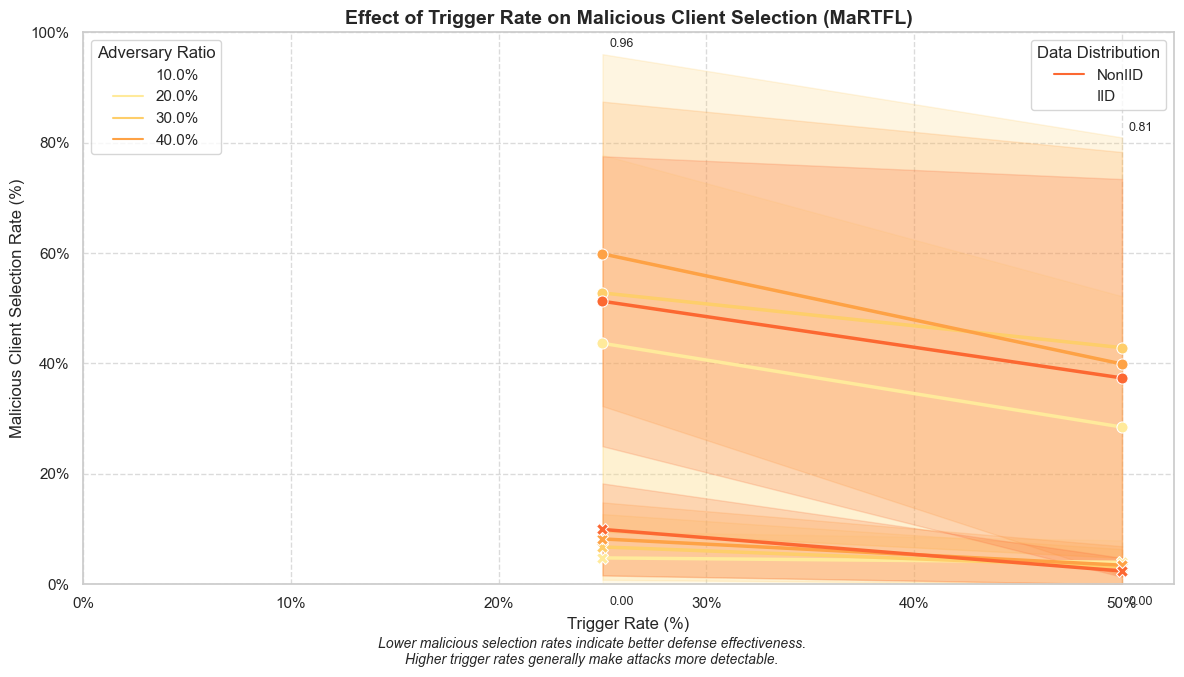

<Figure size 0x0 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.ticker as mtick

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})
visual_save_path = "./visualization"
Path(visual_save_path).mkdir(parents=True, exist_ok=True)

# Consistent colors
COLOR_PALETTE = sns.color_palette("YlOrRd", 6)  # Yellow-Orange-Red color scheme for trigger rates

def plot_trigger_vs_selection(results_df, save_path):
    """
    Plot the relationship between trigger rate and malicious client selection rate for MaRTFL.
    
    Parameters:
    results_df: DataFrame with columns TRIGGER_RATE, AVG_MALICIOUS_RATE, ADV_RATE, IID
    save_path: Path to save the visualization
    """
    # Filter only for MaRTFL data
    martfl_data = results_df[results_df['AGGREGATION_METHOD'] == 'martfl']
    
    # Create figure
    plt.figure(figsize=(12, 7))
    
    # Create the line plot
    ax = sns.lineplot(
        data=martfl_data,
        x='TRIGGER_RATE',
        y='AVG_MALICIOUS_RATE',
        hue='ADV_RATE',
        style='IID',
        markers=True,
        dashes=False,
        palette=COLOR_PALETTE,
        linewidth=2.5,
        markersize=8
    )
    
    # Format axes as percentages
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Add labels and title
    plt.xlabel('Trigger Rate (%)')
    plt.ylabel('Malicious Client Selection Rate (%)')
    plt.title('Effect of Trigger Rate on Malicious Client Selection (MaRTFL)', fontsize=14)
    
    # Set axis limits
    plt.xlim(0, max(martfl_data['TRIGGER_RATE']) * 1.05)
    plt.ylim(0, 1)
    
    # Add grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Improve the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Split the legend into two parts
    adv_handles = handles[:len(martfl_data['ADV_RATE'].unique())]
    adv_labels = [f"{float(label):.1%}" for label in martfl_data['ADV_RATE'].unique()]
    
    iid_handles = handles[len(martfl_data['ADV_RATE'].unique()):]
    iid_labels = [label for label in martfl_data['IID'].unique()]
    
    # Create two legends
    legend1 = plt.legend(adv_handles, adv_labels, title='Adversary Ratio', 
                        loc='upper left', frameon=True)
    plt.gca().add_artist(legend1)
    
    plt.legend(iid_handles, iid_labels, title='Data Distribution', 
              loc='upper right', frameon=True)
    
    # Add annotations for key points
    # Find the minimum and maximum selection rates for each trigger rate
    for trigger_rate in sorted(martfl_data['TRIGGER_RATE'].unique()):
        subset = martfl_data[martfl_data['TRIGGER_RATE'] == trigger_rate]
        min_idx = subset['AVG_MALICIOUS_RATE'].idxmin()
        max_idx = subset['AVG_MALICIOUS_RATE'].idxmax()
        
        min_row = subset.loc[min_idx]
        max_row = subset.loc[max_idx]
        
        # Add annotations for min and max points
        plt.annotate(
            f"{min_row['AVG_MALICIOUS_RATE']:.2f}",
            (trigger_rate, min_row['AVG_MALICIOUS_RATE']),
            xytext=(5, -15),
            textcoords='offset points',
            fontsize=9
        )
        
        plt.annotate(
            f"{max_row['AVG_MALICIOUS_RATE']:.2f}",
            (trigger_rate, max_row['AVG_MALICIOUS_RATE']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9
        )
    
    # Add a note about interpretation
    plt.figtext(0.5, 0.01, 
                "Lower malicious selection rates indicate better defense effectiveness.\n"
                "Higher trigger rates generally make attacks more detectable.",
                ha='center', fontsize=10, style='italic')
    
    # Save the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(f'{save_path}/trigger_vs_selection_martfl.png', dpi=300, bbox_inches='tight')
    
    return plt

def plot_trigger_vs_selection_grid(results_df, save_path):
    """
    Create a grid of plots showing the relationship between trigger rate and malicious selection
    for different adversary ratios.
    """
    # Filter only for MaRTFL data
    martfl_data = results_df[results_df['AGGREGATION_METHOD'] == 'MaRTFL']
    
    # Create a grid of plots based on adversary ratio
    g = sns.FacetGrid(
        martfl_data,
        col='ADV_RATE',
        row='IID',
        height=4,
        aspect=1.2,
        sharey=True,
        sharex=True
    )
    
    # Plot the relationship for each panel
    g.map_dataframe(
        sns.lineplot,
        x='TRIGGER_RATE',
        y='AVG_MALICIOUS_RATE',
        color='red',
        marker='o'
    )
    
    # Format axes
    g.set_axis_labels('Trigger Rate (%)', 'Malicious Selection Rate (%)')
    g.set_titles(col_template='Adv. Ratio: {col_name}', row_template='{row_name}')
    
    # Format as percentages
    for ax in g.axes.flat:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
        # Add horizontal reference line at 0.5
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Add overall title
    g.fig.suptitle('MaRTFL: Trigger Rate vs. Malicious Selection Rate', fontsize=16, y=1.02)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f'{save_path}/trigger_vs_selection_grid.png', dpi=300, bbox_inches='tight')
    
    return g

def generate_sample_data():
    """Generate sample data for the trigger rate vs selection rate visualization"""
    np.random.seed(42)
    
    # Define parameter ranges
    trigger_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    adv_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
    iid_types = ['IID', 'Non-IID']
    
    data = []
    
    # Generate data points
    for trigger_rate in trigger_rates:
        for adv_rate in adv_rates:
            for iid in iid_types:
                # Base selection rate decreases as trigger rate increases (more detectable)
                # Higher adversary ratios have higher selection rates (harder to filter out)
                # Non-IID has slightly higher selection rates (harder to detect)
                
                base_rate = 0.8 - trigger_rate * 1.2  # Base rate decreases with trigger rate
                adv_factor = 0.5 + adv_rate * 0.6     # Higher adversary ratio means higher selection
                iid_factor = 1.0 if iid == 'IID' else 1.15  # Non-IID is harder to detect
                
                # Calculate malicious selection rate
                mal_sel_rate = base_rate * adv_factor * iid_factor
                
                # Ensure the rate is between 0 and 1
                mal_sel_rate = np.clip(mal_sel_rate, 0.05, 0.95)
                
                # Add some random noise
                mal_sel_rate += np.random.normal(0, 0.03)
                mal_sel_rate = np.clip(mal_sel_rate, 0.05, 0.95)
                
                # Calculate corresponding benign selection rate (inversely related)
                benign_sel_rate = 0.9 - 0.2 * mal_sel_rate
                benign_sel_rate = np.clip(benign_sel_rate, 0.5, 0.95)
                
                data.append({
                    'AGGREGATION_METHOD': 'MaRTFL',
                    'TRIGGER_RATE': trigger_rate,
                    'ADV_RATE': adv_rate,
                    'IID': iid,
                    'AVG_MALICIOUS_RATE': mal_sel_rate,
                    'AVG_BENIGN_RATE': benign_sel_rate
                })
    
    return pd.DataFrame(data)

# Generate sample data and create visualizations
sample_df = generate_sample_data()
plot_trigger_vs_selection(df_summary, visual_save_path)
plot_trigger_vs_selection_grid(df_summary, visual_save_path)